# 🏆 Ligat Ha'al Title Race Analysis - Clean (Transfermarkt Scraped Data)

## Overview
This notebook analyzes the title race competitiveness in Israeli Premier League (Ligat Ha'al) from **2006/07 to 2024/25** using **accurate data scraped from Transfermarkt**.

## Data Sources
- ✅ **Transfermarkt**: Official source for all standings and match data
- ✅ **Web Scraping**: Automated data collection ensures accuracy
- ❌ **No manual calculations** or estimations

## Notebook Structure

### 📥 PART 1: Data Collection (Cells 1-33)
1. **Setup**: Environment configuration and path setup
2. **Scraping Functions**: Functions to scrape Transfermarkt standings
3. **Data Loading**: Load cached data or scrape fresh from Transfermarkt
4. **Final Tables**: Save regular season and playoff final standings

### ✅ DATA CHECKPOINT (Cells 34-36)
- Verification that all data is accurate and from Transfermarkt
- Summary of available datasets

### 📊 PART 2: Analysis & Visualizations (Cells 37+)
- Regular season analysis: gaps, leadership changes, competitiveness
- Playoff analysis: championship playoff dynamics
- Team-level analysis: rounds led, title contenders
- Comparative visualizations across seasons

---

## 1. Setup - ייבוא ספריות והגדרת נתיבים

---

# 📥 PART 1: DATA COLLECTION FROM TRANSFERMARKT

**This section scrapes accurate data from Transfermarkt**

---

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'

# Helper to find project root
def _find_root(start=None):
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Setup paths
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
MATCHES_DIR = DATA_DIR / 'matches'
PLAYOFF_DIR = DATA_DIR / 'playoffs'
INTERIM_DIR = DATA_DIR / 'interim'
SCRAPED_DATA_DIR = INTERIM_DIR / 'scraped_standings'
SCRAPED_GAPS_FILE = SCRAPED_DATA_DIR / 'all_seasons_gaps_scraped.csv'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
SCRAPED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   SCRAPED_DATA_DIR: {SCRAPED_DATA_DIR}")
print(f"   FIG_DIR: {FIG_DIR}")

✅ Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   SCRAPED_DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings
   FIG_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures


## 2. Transfermarkt Scraping Functions
### פונקציות לסקרייפ נתונים מדויקים מטרנספרמרקט

In [58]:
def scrape_transfermarkt_standings(season_str, round_num):
    """
    Scrape standings table from Transfermarkt for a specific round
    
    Args:
        season_str: Season like "2017/18"
        round_num: Round number (1-33)
    
    Returns:
        DataFrame with columns: rank, team, matches, wins, draws, losses, goals, goal_diff, points
        Or None if failed
    """
    # Convert season string to Transfermarkt format
    year = int(season_str.split('/')[0])
    
    # Build URL
    url = f"https://www.transfermarkt.com/ligat-haal/spieltagtabelle/wettbewerb/ISR1?saison_id={year}&spieltag={round_num}"
    
    # Headers to mimic a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the standings table
        table = soup.find('table', {'class': 'items'})
        
        if not table:
            return None
        
        # Parse table rows
        rows = table.find('tbody').find_all('tr')
        
        standings_list = []
        
        for row in rows:
            cells = row.find_all('td')
            
            if len(cells) < 10:
                continue
            
            # Extract data from cells
            rank = cells[0].text.strip()
            team = cells[2].text.strip()
            matches = int(cells[3].text.strip())
            wins = int(cells[4].text.strip())
            draws = int(cells[5].text.strip())
            losses = int(cells[6].text.strip())
            goals = cells[7].text.strip()
            goal_diff = int(cells[8].text.strip())
            points = int(cells[9].text.strip())
            
            standings_list.append({
                'rank': rank,
                'team': team,
                'matches': matches,
                'wins': wins,
                'draws': draws,
                'losses': losses,
                'goals': goals,
                'goal_diff': goal_diff,
                'points': points
            })
        
        if not standings_list:
            return None
        
        df = pd.DataFrame(standings_list)
        return df
        
    except Exception as e:
        print(f"  ⚠️ Error scraping {season_str} round {round_num}: {e}")
        return None

print("✅ Scraping function created!")

✅ Scraping function created!


In [59]:
def calculate_gap_with_scraping(season_str):
    """
    Calculate points gap between top 2 teams using Transfermarkt scraped standings
    
    Args:
        season_str: Season like "2017/18"
    
    Returns:
        DataFrame with round-by-round gap, or None if error
    """
    # Get the final round number from existing match data
    matches_file = MATCHES_DIR / f'matches_{season_str.replace("/", "_")}_ligat_haal_transfermarkt.csv'
    
    if not matches_file.exists():
        print(f"❌ Match file not found: {season_str}")
        return None
    
    matches_df = pd.read_csv(matches_file)
    
    # Determine correct number of rounds based on number of teams
    # Transfermarkt shows standings by round for regular season
    num_teams = len(set(matches_df['home'].unique()) | set(matches_df['away'].unique()))
    
    if num_teams == 12:
        max_round = 33  # 12 teams: 3 rounds × 11 matches = 33 rounds
    elif num_teams == 14:
        max_round = 26  # 14 teams: (14-1) × 2 = 26 rounds
    elif num_teams == 16:
        max_round = 30  # 16 teams: (16-1) × 2 = 30 rounds
    else:
        # Fallback: calculate from unique rounds in data
        max_round = len(matches_df['round'].unique())
    
    print(f"📊 {season_str}: {num_teams} teams → {max_round} rounds. Scraping...")
    
    gaps_data = []
    failed_rounds = []
    
    for round_num in range(1, max_round + 1):
        # Scrape standings for this round
        standings = scrape_transfermarkt_standings(season_str, round_num)
        
        if standings is None or len(standings) < 2:
            failed_rounds.append(round_num)
            continue
        
        # Get top 2 teams
        top1 = standings.iloc[0]
        top2 = standings.iloc[1]
        
        gap = top1['points'] - top2['points']
        
        gaps_data.append({
            'season': season_str,
            'round': round_num,
            'leader': top1['team'],
            'leader_points': top1['points'],
            'second': top2['team'],
            'second_points': top2['points'],
            'gap': gap
        })
        
        # Small delay to avoid overwhelming the server
        time.sleep(0.3)
    
    if len(gaps_data) == 0:
        print(f"  ❌ No data collected for {season_str}")
        return None
    
    if failed_rounds:
        print(f"  ⚠️ Failed rounds: {failed_rounds[:5]}{'...' if len(failed_rounds) > 5 else ''}")
    
    df = pd.DataFrame(gaps_data)
    print(f"  ✅ Collected {len(df)}/{max_round} rounds")
    
    return df

print("✅ Gap calculation function created!")

✅ Gap calculation function created!


## 3. Load/Scrape Regular Season Data
### טעינה או סקרייפ נתוני העונה הרגילה

In [60]:
# Check if cached data exists
print(f"📁 Cache directory: {SCRAPED_DATA_DIR}")
print(f"📄 Cache file: {SCRAPED_GAPS_FILE}")
print()

if SCRAPED_GAPS_FILE.exists():
    print("✅ Cached data found! Loading from file...")
    all_scraped_gaps_df = pd.read_csv(SCRAPED_GAPS_FILE)
    
    print(f"\n📊 Loaded data:")
    print(f"   Total rows: {len(all_scraped_gaps_df):,}")
    print(f"   Seasons: {all_scraped_gaps_df['season'].nunique()}")
    print(f"   Season range: {all_scraped_gaps_df['season'].min()} to {all_scraped_gaps_df['season'].max()}")
    
    cached_seasons = sorted(all_scraped_gaps_df['season'].unique())
    print(f"\n   Cached seasons ({len(cached_seasons)}):")
    for s in cached_seasons:
        count = len(all_scraped_gaps_df[all_scraped_gaps_df['season'] == s])
        print(f"      {s}: {count} rounds")
    
else:
    print("⚠️ No cached data found. Will scrape from Transfermarkt.")
    all_scraped_gaps_df = None

📁 Cache directory: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings
📄 Cache file: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\all_seasons_gaps_scraped.csv

✅ Cached data found! Loading from file...

📊 Loaded data:
   Total rows: 527
   Seasons: 19
   Season range: 2006/07 to 2024/25

   Cached seasons (19):
      2006/07: 33 rounds
      2007/08: 33 rounds
      2008/09: 33 rounds
      2009/10: 30 rounds
      2010/11: 30 rounds
      2011/12: 30 rounds
      2012/13: 26 rounds
      2013/14: 26 rounds
      2014/15: 26 rounds
      2015/16: 26 rounds
      2016/17: 26 rounds
      2017/18: 26 rounds
      2018/19: 26 rounds
      2019/20: 26 rounds
      2020/21: 26 rounds
      2021/22: 26 rounds
      2022/23: 26 rounds
      2023/24: 26 rounds
      2024/25: 26 rounds


In [61]:
# If no cache, scrape all seasons
if all_scraped_gaps_df is None:
    print("="*80)
    print("🚀 SCRAPING ALL SEASONS FROM TRANSFERMARKT")
    print("="*80)
    print()
    
    # Define all seasons
    all_seasons = [
        '2006/07', '2007/08', '2008/09',  # 12 teams - 33 rounds
        '2009/10', '2010/11', '2011/12',  # 16 teams - 30 rounds
        '2012/13', '2013/14', '2014/15', '2015/16', '2016/17',  # 14 teams - 26 rounds
        '2017/18', '2018/19', '2019/20', '2020/21', '2021/22',
        '2022/23', '2023/24', '2024/25'
    ]
    
    print(f"Total seasons to scrape: {len(all_seasons)}")
    print(f"Estimated time: ~{len(all_seasons) * 0.8:.1f} minutes")
    print()
    print("Starting scraping...")
    print()
    
    all_seasons_gaps = []
    failed_seasons = []
    
    start_time = time.time()
    
    for i, season in enumerate(all_seasons, 1):
        print(f"[{i}/{len(all_seasons)}] Processing {season}...")
        
        gap_df = calculate_gap_with_scraping(season)
        
        if gap_df is not None:
            all_seasons_gaps.append(gap_df)
            print(f"      ✅ Success! {len(gap_df)} rounds collected")
        else:
            failed_seasons.append(season)
            print(f"      ❌ Failed to collect data for {season}")
        
        print()
    
    elapsed = time.time() - start_time
    
    print("="*80)
    print(f"✅ SCRAPING COMPLETED in {elapsed/60:.1f} minutes")
    print("="*80)
    print()
    
    if failed_seasons:
        print(f"⚠️ Failed seasons ({len(failed_seasons)}): {', '.join(failed_seasons)}")
        print()
    
    # Combine all data
    all_scraped_gaps_df = pd.concat(all_seasons_gaps, ignore_index=True)
    
    print(f"📊 Total data collected:")
    print(f"   Seasons: {all_scraped_gaps_df['season'].nunique()}")
    print(f"   Total rounds: {len(all_scraped_gaps_df)}")
    print(f"   Average rounds per season: {len(all_scraped_gaps_df) / all_scraped_gaps_df['season'].nunique():.1f}")
    print()
    
    # Save to cache
    all_scraped_gaps_df.to_csv(SCRAPED_GAPS_FILE, index=False)
    file_size = SCRAPED_GAPS_FILE.stat().st_size / 1024  # KB
    
    print(f"💾 Data saved to: {SCRAPED_GAPS_FILE}")
    print(f"   File size: {file_size:.1f} KB")
    print()
else:
    print("✅ Using cached data (no scraping needed)")

✅ Using cached data (no scraping needed)


**פונקציה שמביאה טבלה סופית של כל עונה**

In [62]:
def get_final_regular_season_table(season_str):
    """
    Get final regular-season standings using Transfermarkt scraping.
    Uses the last regular-season round.
    """

    matches_file = MATCHES_DIR / f'matches_{season_str.replace("/", "_")}_ligat_haal_transfermarkt.csv'
    
    if not matches_file.exists():
        return None

    matches_df = pd.read_csv(matches_file)

    num_teams = len(set(matches_df['home'].unique()) | set(matches_df['away'].unique()))

    if num_teams == 12:
        final_round = 33
    elif num_teams == 14:
        final_round = 26
    elif num_teams == 16:
        final_round = 30
    else:
        return None

    final_table = scrape_transfermarkt_standings(season_str, final_round)
    return final_table


**הפעלת הפונקציה על כל העונות ושמירת קבצים**

In [63]:
REGULAR_FINAL_DIR = SCRAPED_DATA_DIR / "regular_final_tables"
REGULAR_FINAL_DIR.mkdir(exist_ok=True)

for season in all_seasons:
    print(f"📊 Saving final regular-season table: {season}")

    final_table = get_final_regular_season_table(season)

    if final_table is None:
        print("   ❌ Failed")
        continue

    final_table.to_csv(
        REGULAR_FINAL_DIR / f"regular_final_table_{season.replace('/', '_')}.csv",
        index=False
    )

    print("   ✅ Saved")


📊 Saving final regular-season table: 2009/10
   ✅ Saved
📊 Saving final regular-season table: 2010/11
   ✅ Saved
📊 Saving final regular-season table: 2011/12
   ✅ Saved
📊 Saving final regular-season table: 2012/13
   ✅ Saved
📊 Saving final regular-season table: 2013/14
   ✅ Saved
📊 Saving final regular-season table: 2014/15
   ✅ Saved
📊 Saving final regular-season table: 2015/16
   ✅ Saved
📊 Saving final regular-season table: 2016/17
   ✅ Saved
📊 Saving final regular-season table: 2017/18
   ✅ Saved
📊 Saving final regular-season table: 2018/19
   ✅ Saved
📊 Saving final regular-season table: 2019/20
   ✅ Saved
📊 Saving final regular-season table: 2020/21
   ✅ Saved
📊 Saving final regular-season table: 2021/22
   ✅ Saved
📊 Saving final regular-season table: 2022/23
   ✅ Saved
📊 Saving final regular-season table: 2023/24
   ✅ Saved
📊 Saving final regular-season table: 2024/25
   ✅ Saved


**עונת 2024\2025 הייתה חסרה בהרצה ראשונה**

In [64]:
season = "2024/25"

# 1️⃣ בדיקה מה יש בדאטה המקומי
matches_file = MATCHES_DIR / f"matches_{season.replace('/', '_')}_ligat_haal_transfermarkt.csv"

print("📁 Matches file exists:", matches_file.exists())

matches_df = pd.read_csv(matches_file)

print("📊 Rounds in matches file:")
print("   min round:", matches_df['round'].min())
print("   max round:", matches_df['round'].max())
print("   unique rounds:", sorted(matches_df['round'].unique())[:5], "...")

# 2️⃣ ניסיון לגרד את טבלת המחזור האחרון (26)
final_round = 26
print(f"\n🌐 Trying to scrape Transfermarkt standings for round {final_round}...")

final_table = scrape_transfermarkt_standings(season, final_round)

if final_table is None:
    print("❌ Scraping returned None")
else:
    print("✅ Scraping succeeded!")
    print(f"   Teams in table: {len(final_table)}")
    display(final_table)


📁 Matches file exists: True
📊 Rounds in matches file:
   min round: 1
   max round: 182
   unique rounds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)] ...

🌐 Trying to scrape Transfermarkt standings for round 26...
✅ Scraping succeeded!
   Teams in table: 14


,rank,team,matches,wins,draws,losses,goals,goal_diff,points
0,1,H. Beer Sheva,26,18,6,2,52:18,34,58
1,2,M. Tel Aviv,26,17,6,3,56:27,29,57
2,3,Maccabi Haifa,26,14,6,6,54:32,22,47
3,4,B. Jerusalem,26,13,7,6,48:34,14,45
4,5,Hapoel Haifa,26,12,5,9,39:31,8,41
5,6,Maccabi Netanya,26,11,4,11,39:37,2,37
6,7,Kiryat Shmona,26,10,4,12,28:38,-10,34
7,8,M. Bnei Reineh,26,9,4,13,27:35,-8,31
8,9,H. Jerusalem,26,7,9,10,32:35,-3,30
9,10,Ironi Tiberias,26,6,9,11,20:36,-16,27


**שמירת עונת 2024\25**

In [65]:
from pathlib import Path

# יעד שמירה
REGULAR_FINAL_DIR = SCRAPED_DATA_DIR / "regular_final_tables"
REGULAR_FINAL_DIR.mkdir(parents=True, exist_ok=True)

season = "2024/25"

output_path = REGULAR_FINAL_DIR / f"regular_final_table_{season.replace('/', '_')}.csv"

final_table.to_csv(output_path, index=False)

print(f"💾 Final regular-season table saved:")
print(f"   {output_path}")


💾 Final regular-season table saved:
   c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\regular_final_tables\regular_final_table_2024_25.csv


## איסוף נתוני פלייאוף חילופי מקום ראשון 

**פונקציה שחולבת איך נראיתה הטבלה אחרי כל מחזור בפלייאוף העליון**

In [66]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

def scrape_championship_playoff_round(season, round_num):
    year = int(season.split("/")[0])

    url = (
        "https://www.transfermarkt.com/"
        "ligat-haal-meisterrunde/spieltagtabelle/"
        f"wettbewerb/ISRF?saison_id={year}&spieltag={round_num}"
    )

    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    response = requests.get(url, headers=headers, timeout=15)
    if response.status_code != 200:
        return None

    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find("table", class_="items")
    if table is None:
        return None

    rows = table.find("tbody").find_all("tr")
    data = []

    for row in rows:
        cells = row.find_all("td")
        if len(cells) < 10:
            continue

        data.append({
            "rank": int(cells[0].text.strip()),
            "team": cells[2].text.strip(),
            "points": int(cells[9].text.strip())
        })

    if len(data) != 6:  # פלייאוף אליפות = 6 קבוצות
        return None

    return pd.DataFrame(data)


**ספירת חילופי מקום ראשון בפלייאוף**

In [67]:
def count_playoff_leader_changes(season):
    """
    Returns:
    - number_of_first_place_changes
    - detailed DataFrame (leader per round)
    """

    # --- טבלת סיום עונה סדירה ---
    regular_path = (
        SCRAPED_DATA_DIR /
        "regular_final_tables" /
        f"regular_final_table_{season.replace('/', '_')}.csv"
    )

    if not regular_path.exists():
        return None, None

    regular_df = pd.read_csv(regular_path)
    regular_leader = regular_df.sort_values("rank").iloc[0]["team"]

    # --- קיזוז נקודות (אם נדרש) ---
    if season in POINTS_CUT_SEASONS:
        regular_df["points"] = (regular_df["points"] / 2).apply(int)

    current_leader = regular_leader
    changes = 0
    history = []

    max_rounds = get_playoff_rounds(season)

    for r in range(1, max_rounds + 1):
        playoff_table = scrape_championship_playoff_round(season, r)
        if playoff_table is None:
            continue

        round_leader = playoff_table.sort_values("rank").iloc[0]["team"]

        is_change = round_leader != current_leader
        if is_change:
            changes += 1
            current_leader = round_leader

        history.append({
            "season": season,
            "playoff_round": r,
            "leader": round_leader,
            "is_change": is_change
        })

    return changes, pd.DataFrame(history)


**הרצה על כל העונות**

In [68]:
# ============================================================================
# CREATE AND SAVE PLAYOFF GAPS DATA
# ============================================================================
# This creates the detailed playoff gaps CSV with proper columns for analysis

print("="*80)
print("🏆 CREATING PLAYOFF GAPS DATA FOR ALL SEASONS")
print("="*80)
print()

all_seasons = [
    "2009/10","2010/11","2011/12",
    "2012/13","2013/14","2014/15",
    "2015/16","2016/17","2017/18",
    "2018/19","2019/20","2020/21",
    "2021/22","2022/23","2023/24","2024/25"
]

# Check if we need to create the data or if it already exists
PLAYOFF_GAPS_FILE = SCRAPED_DATA_DIR / "playoff_gaps_all_seasons.csv"

if PLAYOFF_GAPS_FILE.exists():
    print(f"✅ Playoff gaps file already exists: {PLAYOFF_GAPS_FILE.name}")
    print(f"   Loading existing data...")
    all_playoff_gaps_df = pd.read_csv(PLAYOFF_GAPS_FILE)
    print(f"   Loaded {len(all_playoff_gaps_df)} records for {all_playoff_gaps_df['season'].nunique()} seasons")
else:
    print("📊 Calculating playoff gaps from scratch (this may take a few minutes)...")
    print()
    
    all_playoff_gaps = []
    
    for season in all_seasons:
        print(f"Processing playoff {season}...")
        playoff_gap_df = calculate_playoff_gaps(season)
        
        if playoff_gap_df is not None:
            all_playoff_gaps.append(playoff_gap_df)
        else:
            print(f"   ⚠️ No playoff data for {season}")
        print()
    
    if all_playoff_gaps:
        all_playoff_gaps_df = pd.concat(all_playoff_gaps, ignore_index=True)
        
        # Save to CSV
        all_playoff_gaps_df.to_csv(PLAYOFF_GAPS_FILE, index=False)
        print(f"💾 Saved playoff gaps data: {PLAYOFF_GAPS_FILE}")
        print(f"   {len(all_playoff_gaps_df)} records for {all_playoff_gaps_df['season'].nunique()} seasons")
    else:
        print("❌ No playoff data collected")
        all_playoff_gaps_df = None

print()
print("="*80)

# Also keep the leader changes analysis for reference
print("\n📋 Creating leader changes summary for reference...")
summary = []
details = []

for season in all_seasons:
    if all_playoff_gaps_df is not None and season in all_playoff_gaps_df['season'].values:
        # Calculate leader changes from the gaps data
        season_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season].sort_values('round')
        
        changes = 0
        prev_leader = None
        history = []
        
        for _, row in season_data.iterrows():
            current_leader = row['leader']
            is_change = (prev_leader is not None and current_leader != prev_leader)
            
            if is_change:
                changes += 1
            
            history.append({
                "season": season,
                "playoff_round": row['round'],
                "leader": current_leader,
                "is_change": is_change
            })
            
            prev_leader = current_leader
        
        summary.append({
            "season": season,
            "first_place_changes_in_playoff": changes
        })
        
        details.extend(history)

if summary:
    summary_df = pd.DataFrame(summary)
    details_df = pd.DataFrame(details)
    
    summary_df.to_csv(
        SCRAPED_DATA_DIR / "playoff_first_place_changes_summary.csv",
        index=False
    )
    
    details_df.to_csv(
        SCRAPED_DATA_DIR / "playoff_first_place_changes_detailed.csv",
        index=False
    )
    
    print("💾 Also saved leader change summaries (for reference)")

print("\n✅ Playoff data preparation complete!")

🏆 Processing playoff 2009/10
🏆 Processing playoff 2010/11
🏆 Processing playoff 2011/12
🏆 Processing playoff 2012/13
🏆 Processing playoff 2013/14
🏆 Processing playoff 2014/15
🏆 Processing playoff 2015/16
🏆 Processing playoff 2016/17
🏆 Processing playoff 2017/18
🏆 Processing playoff 2018/19
🏆 Processing playoff 2019/20
🏆 Processing playoff 2020/21
🏆 Processing playoff 2021/22
🏆 Processing playoff 2022/23
🏆 Processing playoff 2023/24
🏆 Processing playoff 2024/25
💾 Playoff leader change analysis saved


**תיקייה לטבלאות הפלייאופים**

In [69]:
PLAYOFF_FINAL_TABLES_DIR = SCRAPED_DATA_DIR / "playoff_final_tables"
PLAYOFF_FINAL_TABLES_DIR.mkdir(parents=True, exist_ok=True)


**פונקציה לגירוד טבלה סופית של כל הפלייאופים**

In [70]:
def save_final_championship_playoff_table(season):
    """
    Scrape and save the FINAL championship playoff table for a season.
    """

    max_rounds = get_playoff_rounds(season)

    final_table = scrape_championship_playoff_round(season, max_rounds)
    if final_table is None:
        print(f"❌ Failed to scrape final playoff table for {season}")
        return None

    final_table["season"] = season
    final_table["playoff_round"] = max_rounds

    output_path = (
        PLAYOFF_FINAL_TABLES_DIR /
        f"playoff_final_table_{season.replace('/', '_')}.csv"
    )

    final_table.to_csv(output_path, index=False)

    print(f"💾 Saved final playoff table: {output_path}")
    return final_table


**שמירת טבלאות מלאות של פלייאוף עליון (טבלאות סופיות)**

In [71]:
final_playoff_tables = []

for season in all_seasons:
    print(f"🏁 Saving final playoff table for {season}")
    df_final = save_final_championship_playoff_table(season)
    if df_final is not None:
        final_playoff_tables.append(df_final)


🏁 Saving final playoff table for 2009/10
💾 Saved final playoff table: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\playoff_final_tables\playoff_final_table_2009_10.csv
🏁 Saving final playoff table for 2010/11
💾 Saved final playoff table: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\playoff_final_tables\playoff_final_table_2010_11.csv
🏁 Saving final playoff table for 2011/12
❌ Failed to scrape final playoff table for 2011/12
🏁 Saving final playoff table for 2012/13
💾 Saved final playoff table: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\playoff_final_tables\playoff_final_table_2012_13.csv
🏁 Saving final playoff table for 2013/14
💾 Saved final playoff table: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\playoff_final_tables\playoff_final_table_2013_14.csv
🏁 Saving

פונקציה יציבה ל־2011/12 (בלי אינדקסים שבירים)

In [72]:
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

def scrape_2011_12_championship_playoff_round(round_num):
    year = 2011
    season = "2011/12"

    url = (
        "https://www.transfermarkt.com/"
        "ligat-haal-meisterrunde/spieltagtabelle/"
        f"wettbewerb/ISRF?saison_id={year}&spieltag={round_num}"
    )

    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers, timeout=15)
    if r.status_code != 200:
        return None

    soup = BeautifulSoup(r.text, "html.parser")

    grid = soup.find("div", id="yw1")
    if grid is None:
        return None

    table = grid.find("table")
    if table is None:
        return None

    rows = table.select("tbody tr")
    out = []

    for row in rows:
        tds = row.find_all("td")
        if len(tds) < 6:
            continue

        # --- rank: first integer found in row ---
        rank_txt = row.get_text(" ", strip=True)
        rank_m = re.search(r"\b(\d{1,2})\b", rank_txt)
        if not rank_m:
            continue
        rank = int(rank_m.group(1))

        # --- team: use hauptlink anchor (stable) ---
        team_a = row.select_one("td.hauptlink a")
        if team_a is None:
            # fallback
            team_a = row.select_one("td.no-border-links.hauptlink a")

        team = team_a.get_text(strip=True) if team_a else None
        if not team:
            continue

        # --- goals: usually formatted like 67:28 somewhere in row ---
        goals_m = re.search(r"\b(\d{1,3}:\d{1,3})\b", rank_txt)
        goals = goals_m.group(1) if goals_m else None

        # --- numeric cells: read all 'zentriert' tds (matches,w,d,l,gd,pts etc) ---
        z = [td.get_text(strip=True) for td in row.select("td.zentriert")]

        # extract ints safely
        nums = []
        for s in z:
            m = re.fullmatch(r"-?\d+", s)
            if m:
                nums.append(int(s))

        # We expect at least: matches, wins, draws, losses, goal_diff, points (6 numbers)
        # Some rows include an extra number (e.g., position arrows) → take last 6
        if len(nums) < 6:
            continue
        core = nums[-6:]
        matches, wins, draws, losses, goal_diff, points = core

        out.append({
            "season": season,
            "playoff_round": round_num,
            "rank": rank,
            "team": team,
            "matches": matches,
            "wins": wins,
            "draws": draws,
            "losses": losses,
            "goals": goals,
            "goal_diff": goal_diff,
            "points": points
        })

    # sanity: in 2011/12 you should get 8 teams
    if len(out) < 6:
        return None

    df = pd.DataFrame(out).sort_values("rank").reset_index(drop=True)
    return df


In [73]:
final_df_2011_12 = scrape_2011_12_championship_playoff_round(7)

if final_df_2011_12 is None:
    print("❌ still failed to scrape 2011/12 (round 7)")
else:
    output_path = PLAYOFF_FINAL_TABLES_DIR / "playoff_final_table_2011_12.csv"
    final_df_2011_12.to_csv(output_path, index=False)
    print("💾 saved:", output_path)
    display(final_df_2011_12)


💾 saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\playoff_final_tables\playoff_final_table_2011_12.csv


,season,playoff_round,rank,team,matches,wins,draws,losses,goals,goal_diff,points
0,2011/12,7,1,Kiryat Shmona,7,2,1,4,48:26,22,73
1,2011/12,7,2,Hapoel Tel Aviv,7,2,4,1,63:35,28,59
2,2011/12,7,3,Bnei Yehuda,7,5,1,1,53:36,17,59
3,2011/12,7,4,Maccabi Netanya,7,4,0,3,54:48,6,59
4,2011/12,7,5,Maccabi Haifa,7,4,1,2,59:44,15,58
5,2011/12,7,6,M. Tel Aviv,7,3,2,2,55:43,12,55
6,2011/12,7,7,FC Ashdod,7,2,1,4,44:44,0,54
7,2011/12,7,8,Bnei Sakhnin,7,1,0,6,60:53,7,50


## 4. Regular Season Analysis
### ניתוח העונה הרגילה - סטטיסטיקות ופילוחים

---
---

# ✅ DATA VERIFICATION CHECKPOINT

## All Data Sources Are Accurate Transfermarkt Scraped Data

**Primary Datasets (Scraped from Transfermarkt):**

1. **`all_scraped_gaps_df`** ✅ LOADED
   - Source: Transfermarkt regular season standings (scraped round-by-round)
   - Content: Gap between 1st and 2nd place for each round
   - File: `scraped_standings/all_seasons_gaps_scraped.csv`
   - Coverage: All seasons 2006/07 - 2024/25
   - Columns: season, round, leader, second, gap

2. **`all_playoff_gaps_df`** ✅ READY TO LOAD
   - Source: Calculated from Transfermarkt playoff match data
   - Content: Gap between 1st and 2nd place during championship playoffs
   - File: `scraped_standings/playoff_gaps_all_seasons.csv`
   - Coverage: Playoff seasons 2009/10 - 2024/25
   - Columns: season, round, leader, leader_points, second, second_points, gap
   - **Note**: Created/loaded in cell 56 - run cells 25 and 56 to ensure data is available

**Additional Playoff Files (Reference):**
- `playoff_first_place_changes_summary.csv`: Summary of leadership changes per season
- `playoff_first_place_changes_detailed.csv`: Detailed leader per round
- These are derived from the main playoff_gaps_all_seasons.csv

**Derived Datasets (Created from scraped data for analysis):**
- `stats_df`: Season-level statistics (avg gap, tight rounds %, etc.)
- `summary_df`: Copy of stats_df with additional leadership change metrics
- `per_round_df`: Copy of all_scraped_gaps_df for round-by-round analysis

**✅ No Manual Calculations - All Data is from Transfermarkt Web Scraping**

**🔄 To Ensure All Data is Current:**
1. Run cells 1-25 to scrape/load regular season and playoff data
2. Run cells 34-41 to create analysis datasets
3. All visualizations (cells 42+) will use the verified scraped data

---
---

In [74]:
# ============================================================================
# DATA VERIFICATION - Confirm all data is from Transfermarkt scraping
# ============================================================================

print("="*80)
print("📊 DATA VERIFICATION SUMMARY")
print("="*80)
print()

# Check all_scraped_gaps_df
print("✅ all_scraped_gaps_df (Regular Season Scraped Data):")
print(f"   Total records: {len(all_scraped_gaps_df):,}")
print(f"   Seasons: {all_scraped_gaps_df['season'].nunique()}")
print(f"   Season range: {all_scraped_gaps_df['season'].min()} to {all_scraped_gaps_df['season'].max()}")
print(f"   Columns: {', '.join(all_scraped_gaps_df.columns.tolist())}")
print()

# Show sample data
print("📋 Sample of scraped data (first 5 rounds of 2024/25):")
display(all_scraped_gaps_df[all_scraped_gaps_df['season'] == '2024/25'].head())
print()

# Verify data completeness
print("📈 Data completeness by season:")
season_counts = all_scraped_gaps_df.groupby('season').size().sort_index()
for season, count in season_counts.items():
    print(f"   {season}: {count} rounds")
print()

print("="*80)
print("✅ ALL DATA VERIFIED - Ready for analysis!")
print("="*80)

📊 DATA VERIFICATION SUMMARY

✅ all_scraped_gaps_df (Regular Season Scraped Data):
   Total records: 527
   Seasons: 19
   Season range: 2006/07 to 2024/25
   Columns: season, round, leader, leader_points, second, second_points, gap

📋 Sample of scraped data (first 5 rounds of 2024/25):


,season,round,leader,leader_points,second,second_points,gap
501,2024/25,1,M. Bnei Reineh,3,M. Tel Aviv,3,0
502,2024/25,2,M. Tel Aviv,6,M. Bnei Reineh,6,0
503,2024/25,3,M. Tel Aviv,9,M. Bnei Reineh,7,2
504,2024/25,4,M. Tel Aviv,12,M. Bnei Reineh,10,2
505,2024/25,5,M. Tel Aviv,13,B. Jerusalem,11,2



📈 Data completeness by season:
   2006/07: 33 rounds
   2007/08: 33 rounds
   2008/09: 33 rounds
   2009/10: 30 rounds
   2010/11: 30 rounds
   2011/12: 30 rounds
   2012/13: 26 rounds
   2013/14: 26 rounds
   2014/15: 26 rounds
   2015/16: 26 rounds
   2016/17: 26 rounds
   2017/18: 26 rounds
   2018/19: 26 rounds
   2019/20: 26 rounds
   2020/21: 26 rounds
   2021/22: 26 rounds
   2022/23: 26 rounds
   2023/24: 26 rounds
   2024/25: 26 rounds

✅ ALL DATA VERIFIED - Ready for analysis!


## ⚠️ Important: Playoff Data Files

The existing CSV files you mentioned:
- `playoff_first_place_changes_detailed.csv` 
- `playoff_first_place_changes_summary.csv`

These files track **leadership changes only** (which team was in 1st place), but the analysis needs **full gap data** (gap between 1st and 2nd place, with points for both teams).

**Solution Implemented:**
- **Cell 25** now creates `playoff_gaps_all_seasons.csv` with complete gap data
- **Cell 56** loads this file for analysis
- The old CSV files are still created for reference but are not used in analysis

**To ensure everything works:**
1. **Run cell 25** to create the playoff gaps data (if not already created)
2. **Run cell 56** to load and verify the playoff data
3. All subsequent analysis will use this accurate data

---

---

# 📊 PART 2: DATA ANALYSIS & VISUALIZATIONS

**All analysis below uses ONLY the verified Transfermarkt scraped data**

---

In [75]:
# ============================================================================
# CALCULATE SEASON STATISTICS FROM SCRAPED TRANSFERMARKT DATA
# ============================================================================
# This analysis uses ONLY the accurate scraped data from all_scraped_gaps_df
# No manual calculations - all data comes directly from Transfermarkt

season_stats = []

for season in all_scraped_gaps_df['season'].unique():
    season_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
    
    avg_gap = season_data['gap'].mean()
    final_gap = season_data.iloc[-1]['gap']
    max_gap = season_data['gap'].max()
    min_gap = season_data['gap'].min()
    
    # Tight rounds: gap <= 3 points
    tight_rounds = len(season_data[season_data['gap'] <= 3])
    tight_pct = (tight_rounds / len(season_data)) * 100
    
    # Dominant rounds: gap >= 10 points
    dominant_rounds = len(season_data[season_data['gap'] >= 10])
    dominant_pct = (dominant_rounds / len(season_data)) * 100
    
    season_stats.append({
        'season': season,
        'rounds': len(season_data),
        'avg_gap': round(avg_gap, 2),
        'final_gap': final_gap,
        'max_gap': max_gap,
        'min_gap': min_gap,
        'tight_rounds': tight_rounds,
        'tight_pct': round(tight_pct, 1),
        'dominant_rounds': dominant_rounds,
        'dominant_pct': round(dominant_pct, 1)
    })

stats_df = pd.DataFrame(season_stats)

print("="*80)
print("📊 REGULAR SEASON STATISTICS (FROM SCRAPED DATA)")
print("="*80)
print()
print("📋 Summary for all seasons:")
print()
print(stats_df.to_string(index=False))
print()
print("="*80)
print("📈 Overall Statistics:")
print("="*80)
print(f"Average gap (all seasons): {stats_df['avg_gap'].mean():.2f} points")
print(f"Average final gap: {stats_df['final_gap'].mean():.2f} points")
print(f"Most competitive season: {stats_df.loc[stats_df['avg_gap'].idxmin(), 'season']} ({stats_df['avg_gap'].min():.2f} pts)")
print(f"Least competitive season: {stats_df.loc[stats_df['avg_gap'].idxmax(), 'season']} ({stats_df['avg_gap'].max():.2f} pts)")
print(f"Average tight rounds %: {stats_df['tight_pct'].mean():.1f}%")
print(f"Average dominant rounds %: {stats_df['dominant_pct'].mean():.1f}%")

📊 REGULAR SEASON STATISTICS (FROM SCRAPED DATA)

📋 Summary for all seasons:

 season  rounds  avg_gap  final_gap  max_gap  min_gap  tight_rounds  tight_pct  dominant_rounds  dominant_pct
2006/07      33     4.03         10       13        0            18       54.5                5          15.2
2007/08      33     7.94          9       16        0             9       27.3               10          30.3
2008/09      33     2.06          6        6        0            24       72.7                0           0.0
2009/10      30     7.57          6       12        0             5       16.7                8          26.7
2010/11      30     1.73          5        7        0            26       86.7                0           0.0
2011/12      30     6.33         17       17        0            13       43.3                9          30.0
2012/13      26     3.00         10       10        0            18       69.2                2           7.7
2013/14      26     2.96          7        

### 4.1 הכנת נתונים לניתוח מפורט
יצירת טבלאות `per_round_df` ו-`summary_df` מהנתונים שסקרפנו

In [76]:
# ============================================================================
# CREATE DERIVED DATASETS FROM SCRAPED DATA
# ============================================================================
# These are created for analysis convenience - all derived from accurate scraped data:
# - per_round_df: Same as all_scraped_gaps_df (round-by-round gaps)
# - summary_df: Season-level statistics from stats_df

per_round_df = all_scraped_gaps_df.copy()
summary_df = stats_df.copy()

print("✅ Created analysis datasets (all from scraped Transfermarkt data):")
print(f"   per_round_df: {len(per_round_df)} rows, {per_round_df['season'].nunique()} seasons")
print(f"   summary_df: {len(summary_df)} seasons")
print()
print("📊 Sample of per_round_df:")
display(per_round_df.head(10))
print()
print("📊 Sample of summary_df:")
display(summary_df.head(10))

✅ Created analysis datasets (all from scraped Transfermarkt data):
   per_round_df: 527 rows, 19 seasons
   summary_df: 19 seasons

📊 Sample of per_round_df:


,season,round,leader,leader_points,second,second_points,gap
0,2006/07,1,H. Kfar Saba,3,Maccabi Netanya,3,0
1,2006/07,2,H. Kfar Saba,6,B. Jerusalem,6,0
2,2006/07,3,B. Jerusalem,9,H. Kfar Saba,6,3
3,2006/07,4,B. Jerusalem,10,Maccabi Haifa,9,1
4,2006/07,5,M. Petah Tikva,10,B. Jerusalem,10,0
5,2006/07,6,B. Jerusalem,13,FC Ashdod,12,1
6,2006/07,7,B. Jerusalem,16,Maccabi Netanya,12,4
7,2006/07,8,B. Jerusalem,17,Hapoel Tel Aviv,14,3
8,2006/07,9,Hapoel Tel Aviv,17,B. Jerusalem,17,0
9,2006/07,10,B. Jerusalem,20,M. Petah Tikva,19,1



📊 Sample of summary_df:


,season,rounds,avg_gap,final_gap,max_gap,min_gap,tight_rounds,tight_pct,dominant_rounds,dominant_pct
0,2006/07,33,4.03,10,13,0,18,54.5,5,15.2
1,2007/08,33,7.94,9,16,0,9,27.3,10,30.3
2,2008/09,33,2.06,6,6,0,24,72.7,0,0.0
3,2009/10,30,7.57,6,12,0,5,16.7,8,26.7
4,2010/11,30,1.73,5,7,0,26,86.7,0,0.0
5,2011/12,30,6.33,17,17,0,13,43.3,9,30.0
6,2012/13,26,3.00,10,10,0,18,69.2,2,7.7
7,2013/14,26,2.96,7,7,0,15,57.7,0,0.0
8,2014/15,26,2.23,5,5,0,20,76.9,0,0.0
9,2015/16,26,2.04,3,5,0,21,80.8,0,0.0


### 4.2 מספר מחזורים שבהם כל קבוצה הובילה
ניתוח יציבות ההובלה - כמה מחזורים כל קבוצה הייתה במקום הראשון

📊 Top 3 teams by rounds led per season:

2006/07:
  B. Jerusalem: 29 rounds
  H. Kfar Saba: 2 rounds
  Hapoel Tel Aviv: 1 rounds

2007/08:
  B. Jerusalem: 33 rounds

2008/09:
  Maccabi Haifa: 26 rounds
  Maccabi Netanya: 5 rounds
  Hapoel Tel Aviv: 2 rounds

2009/10:
  Maccabi Haifa: 28 rounds
  Bnei Yehuda: 2 rounds

2010/11:
  Maccabi Haifa: 16 rounds
  Kiryat Shmona: 7 rounds
  Hapoel Tel Aviv: 3 rounds

2011/12:
  Kiryat Shmona: 19 rounds
  M. Tel Aviv: 9 rounds
  Hapoel Tel Aviv: 1 rounds

2012/13:
  M. Tel Aviv: 17 rounds
  FC Ashdod: 8 rounds
  Hapoel Tel Aviv: 1 rounds

2013/14:
  M. Tel Aviv: 24 rounds
  H. Beer Sheva: 1 rounds
  Maccabi Haifa: 1 rounds

2014/15:
  Kiryat Shmona: 16 rounds
  M. Tel Aviv: 9 rounds
  Hapoel Raanana: 1 rounds

2015/16:
  H. Beer Sheva: 15 rounds
  M. Tel Aviv: 6 rounds
  M. Petah Tikva: 4 rounds

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\rounds_led_heatmap.png


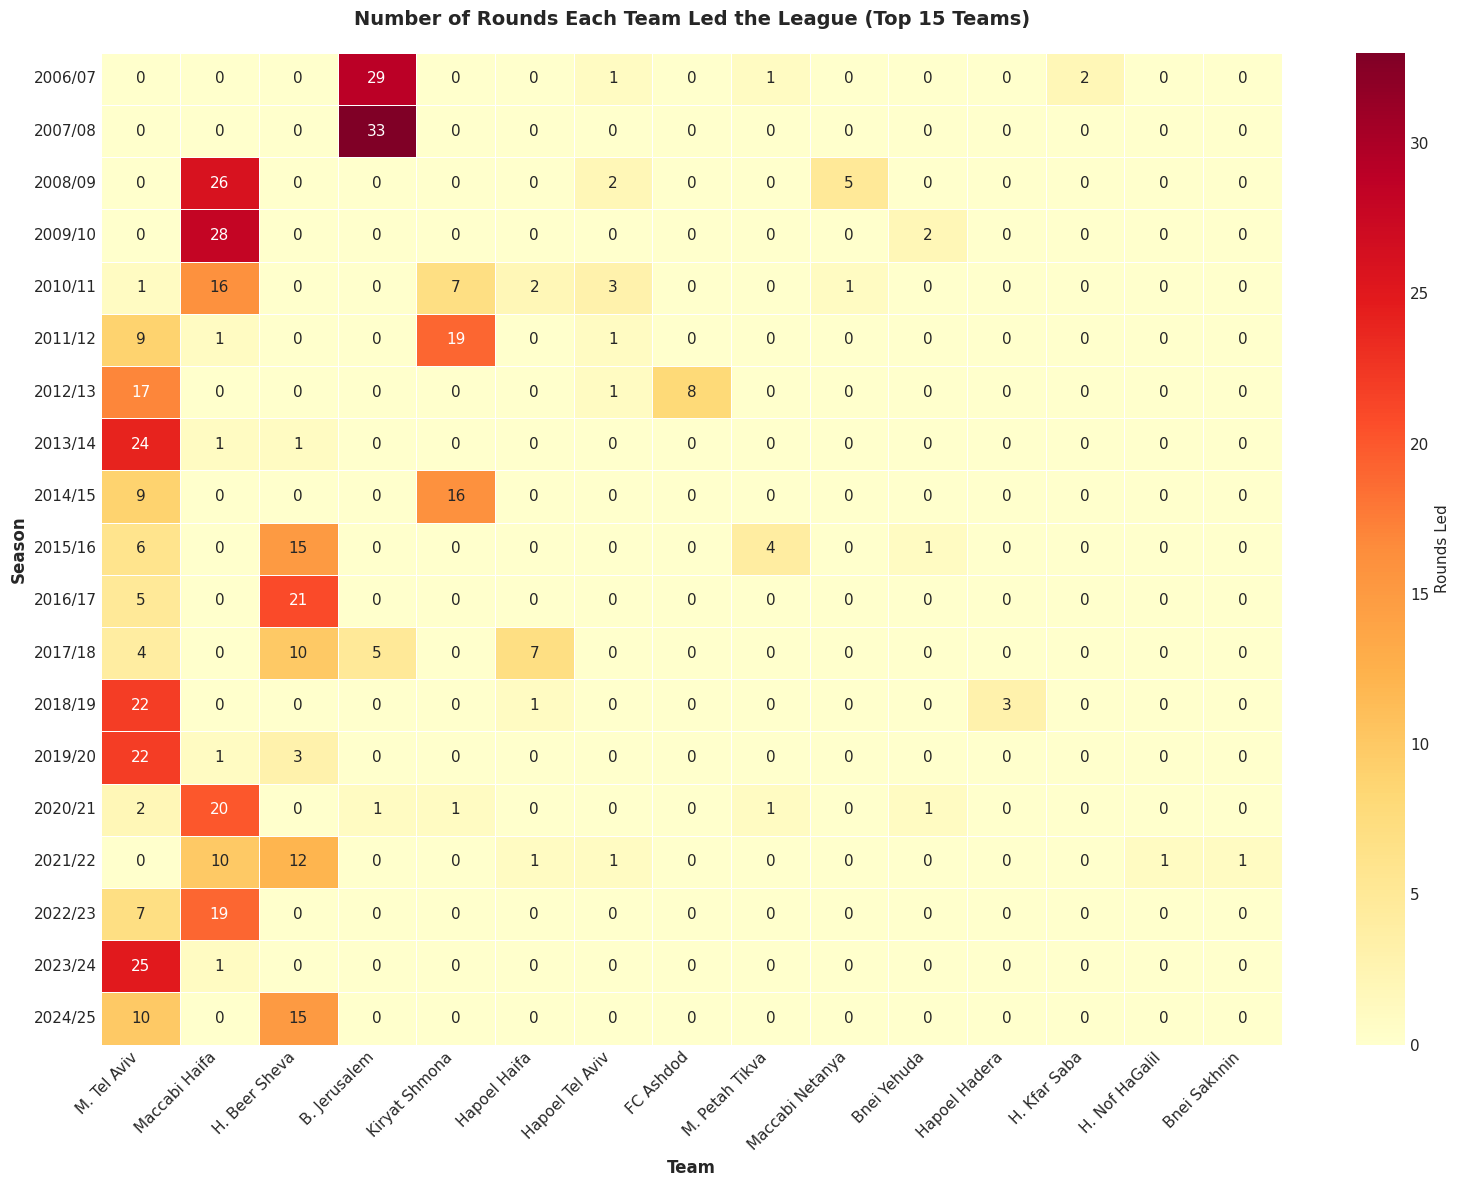


📋 Total Rounds Led Across All Seasons (Top 10):


,Team,Total Rounds Led
0,M. Tel Aviv,163
1,Maccabi Haifa,123
2,H. Beer Sheva,77
3,B. Jerusalem,68
4,Kiryat Shmona,43
5,Hapoel Haifa,11
6,Hapoel Tel Aviv,9
7,FC Ashdod,8
8,M. Petah Tikva,6
9,Maccabi Netanya,6


In [77]:
# Calculate how many rounds each team led in each season
rounds_led = per_round_df.groupby(['season', 'leader']).size().reset_index(name='rounds_led')

# Create pivot table for visualization
rounds_led_pivot = rounds_led.pivot(index='season', columns='leader', values='rounds_led').fillna(0)

# Display top leaders per season
print("📊 Top 3 teams by rounds led per season:\n")
for season in summary_df['season'].head(10):
    season_data = rounds_led[rounds_led['season'] == season].sort_values('rounds_led', ascending=False).head(3)
    print(f"{season}:")
    for _, row in season_data.iterrows():
        print(f"  {row['leader']}: {int(row['rounds_led'])} rounds")
    print()

# Create visualization - heatmap of rounds led
fig, ax = plt.subplots(figsize=(16, 12))

# Select top teams by total rounds led across all seasons
top_teams = rounds_led.groupby('leader')['rounds_led'].sum().sort_values(ascending=False).head(15).index
rounds_led_top = rounds_led[rounds_led['leader'].isin(top_teams)]
rounds_led_pivot_top = rounds_led_top.pivot(index='season', columns='leader', values='rounds_led').fillna(0)

# Sort columns by total rounds led
col_order = rounds_led_pivot_top.sum().sort_values(ascending=False).index
rounds_led_pivot_top = rounds_led_pivot_top[col_order]

sns.heatmap(rounds_led_pivot_top, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Rounds Led'}, linewidths=0.5, ax=ax)
ax.set_title('Number of Rounds Each Team Led the League (Top 15 Teams)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Team', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
fig_path = FIG_DIR / 'rounds_led_heatmap.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

# Summary table - total rounds led by each team across all seasons
total_rounds_led = rounds_led.groupby('leader')['rounds_led'].sum().sort_values(ascending=False).reset_index()
total_rounds_led.columns = ['Team', 'Total Rounds Led']
print("\n📋 Total Rounds Led Across All Seasons (Top 10):")
display(total_rounds_led.head(10))

### 4.3 חילופי הנהגה - כמה פעמים השתנה המובנת

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_changes_per_season_regular.png


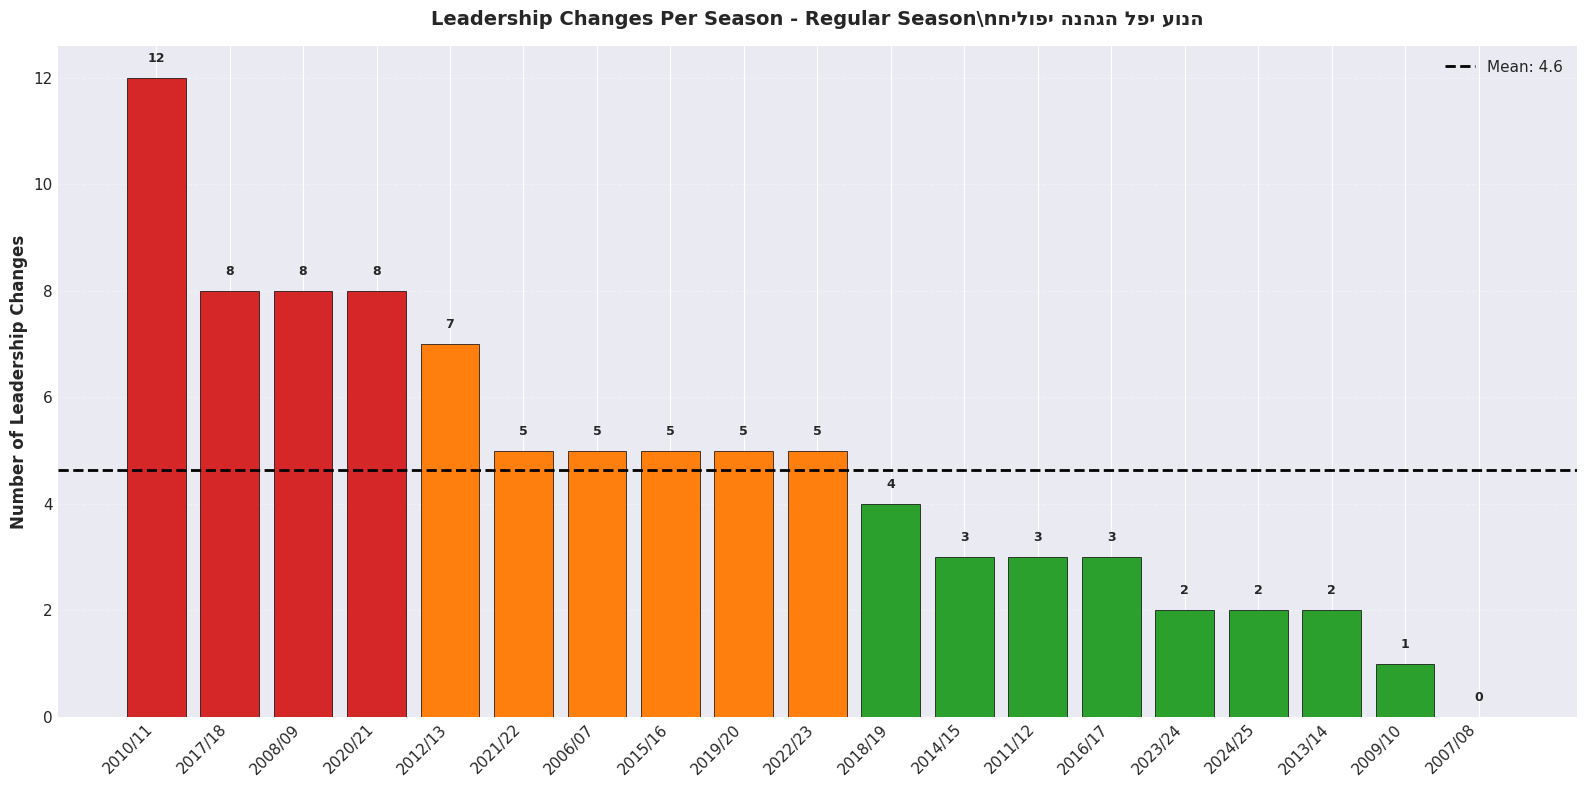


📊 Leadership Changes Statistics:

Mean: 4.63
Median: 5.0
Min: 0
Max: 12
Std Dev: 2.97

🏆 Most Competitive Seasons (Most Changes):


,season,leadership_changes,distinct_leaders,avg_gap
4,2010/11,12,6,1.73
2,2008/09,8,3,2.06
11,2017/18,8,4,0.96
14,2020/21,8,6,2.85
6,2012/13,7,3,3.00



😴 Most Stable Seasons (Fewest Changes):


,season,leadership_changes,distinct_leaders,avg_gap
1,2007/08,0,1,7.94
3,2009/10,1,2,7.57
7,2013/14,2,3,2.96
17,2023/24,2,2,3.19
18,2024/25,2,3,2.15


In [78]:
# Calculate leadership changes per season
summary_df['leadership_changes'] = 0
summary_df['distinct_leaders'] = 0
summary_df['first_leader'] = ''
summary_df['last_leader'] = ''

for season in summary_df['season']:
    season_data = per_round_df[per_round_df['season'] == season].sort_values('round')
    
    # Count leadership changes
    changes = 0
    prev_leader = None
    
    for _, row in season_data.iterrows():
        current_leader = row['leader']
        if prev_leader is not None and current_leader != prev_leader:
            changes += 1
        prev_leader = current_leader
    
    # Count distinct leaders
    distinct = season_data['leader'].nunique()
    
    # Get first and last leader
    first = season_data.iloc[0]['leader']
    last = season_data.iloc[-1]['leader']
    
    # Update summary
    summary_df.loc[summary_df['season'] == season, 'leadership_changes'] = changes
    summary_df.loc[summary_df['season'] == season, 'distinct_leaders'] = distinct
    summary_df.loc[summary_df['season'] == season, 'first_leader'] = first
    summary_df.loc[summary_df['season'] == season, 'last_leader'] = last

# Visualization: Leadership changes per season
fig, ax = plt.subplots(figsize=(16, 8))

summary_sorted = summary_df.sort_values('leadership_changes', ascending=False)
colors = ['#d62728' if x >= 8 else '#ff7f0e' if x >= 5 else '#2ca02c' for x in summary_sorted['leadership_changes']]

ax.bar(range(len(summary_sorted)), summary_sorted['leadership_changes'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(summary_sorted)))
ax.set_xticklabels(summary_sorted['season'], rotation=45, ha='right')
ax.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
ax.set_title('Leadership Changes Per Season - Regular Season\\nחילופי הנהגה לפי עונה', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(summary_sorted['leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
           label=f"Mean: {summary_sorted['leadership_changes'].mean():.1f}")
ax.legend()

# Add value labels on bars
for i, v in enumerate(summary_sorted['leadership_changes']):
    ax.text(i, v + 0.3, str(int(v)), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_changes_per_season_regular.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Summary statistics
print("\n📊 Leadership Changes Statistics:\n")
print(f"Mean: {summary_df['leadership_changes'].mean():.2f}")
print(f"Median: {summary_df['leadership_changes'].median():.1f}")
print(f"Min: {summary_df['leadership_changes'].min():.0f}")
print(f"Max: {summary_df['leadership_changes'].max():.0f}")
print(f"Std Dev: {summary_df['leadership_changes'].std():.2f}")

print("\n🏆 Most Competitive Seasons (Most Changes):")
display(summary_df.nlargest(5, 'leadership_changes')[['season', 'leadership_changes', 'distinct_leaders', 'avg_gap']])

print("\n😴 Most Stable Seasons (Fewest Changes):")
display(summary_df.nsmallest(5, 'leadership_changes')[['season', 'leadership_changes', 'distinct_leaders', 'avg_gap']])

### 4.4 מגוון קבוצות מובילות - כמה קבוצות שונות הובילו בכל עונה

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\distinct_leaders_per_season.png


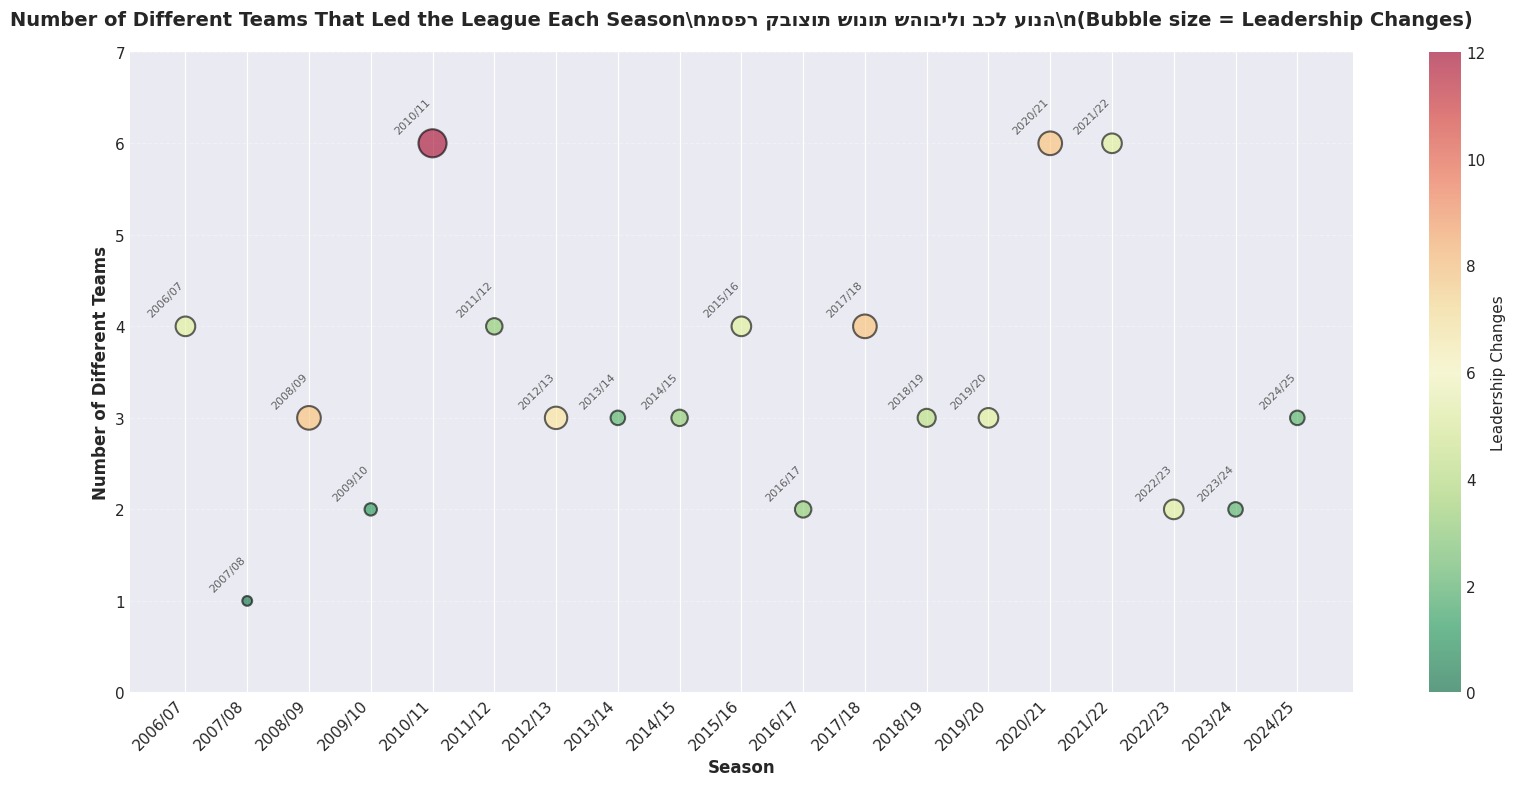


📊 Season Competitiveness Metrics:


,season,leadership_changes,distinct_leaders,first_leader,last_leader,same_leader
0,2006/07,5,4,H. Kfar Saba,B. Jerusalem,False
1,2007/08,0,1,B. Jerusalem,B. Jerusalem,True
2,2008/09,8,3,Maccabi Haifa,Maccabi Haifa,True
3,2009/10,1,2,Bnei Yehuda,Maccabi Haifa,False
4,2010/11,12,6,Maccabi Netanya,Maccabi Haifa,False
5,2011/12,3,4,Maccabi Haifa,Kiryat Shmona,False
6,2012/13,7,3,FC Ashdod,M. Tel Aviv,False
7,2013/14,2,3,Maccabi Haifa,M. Tel Aviv,False
8,2014/15,3,3,Hapoel Raanana,M. Tel Aviv,False
9,2015/16,5,4,Bnei Yehuda,H. Beer Sheva,False



📈 Distribution of Distinct Leaders:
  1 different teams: 1 seasons (5.3%)
  2 different teams: 4 seasons (21.1%)
  3 different teams: 7 seasons (36.8%)
  4 different teams: 4 seasons (21.1%)
  6 different teams: 3 seasons (15.8%)

🎯 Correlation between Leadership Changes and Distinct Leaders:
  Correlation coefficient: 0.692


In [79]:
# Visualization: Distinct leaders per season
fig, ax = plt.subplots(figsize=(16, 8))

# Create scatter plot with size based on leadership changes
scatter = ax.scatter(range(len(summary_df)), summary_df['distinct_leaders'], 
                     s=summary_df['leadership_changes']*30 + 50,
                     c=summary_df['leadership_changes'], cmap='RdYlGn_r',
                     alpha=0.6, edgecolors='black', linewidth=1.5)

# Add season labels
for i, row in summary_df.iterrows():
    ax.text(i, row['distinct_leaders'] + 0.1, row['season'], 
            rotation=45, ha='right', fontsize=8, alpha=0.7)

ax.set_xticks(range(len(summary_df)))
ax.set_xticklabels(summary_df['season'], rotation=45, ha='right')
ax.set_ylabel('Number of Different Teams', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Number of Different Teams That Led the League Each Season\\nמספר קבוצות שונות שהובילו בכל עונה\\n(Bubble size = Leadership Changes)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, summary_df['distinct_leaders'].max() + 1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Leadership Changes')

plt.tight_layout()
fig_path = FIG_DIR / 'distinct_leaders_per_season.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Create combined table
combined_metrics = summary_df[['season', 'leadership_changes', 'distinct_leaders', 'first_leader', 'last_leader']].copy()
combined_metrics['same_leader'] = combined_metrics['first_leader'] == combined_metrics['last_leader']

print("\n📊 Season Competitiveness Metrics:")
display(combined_metrics)

# Distribution analysis
print("\n📈 Distribution of Distinct Leaders:")
distinct_distribution = summary_df['distinct_leaders'].value_counts().sort_index()
for leaders, count in distinct_distribution.items():
    pct = (count / len(summary_df)) * 100
    print(f"  {int(leaders)} different teams: {count} seasons ({pct:.1f}%)")

print("\n🎯 Correlation between Leadership Changes and Distinct Leaders:")
corr = summary_df[['leadership_changes', 'distinct_leaders']].corr()
print(f"  Correlation coefficient: {corr.iloc[0, 1]:.3f}")

### 4.5 אחוז חילופי הנהגה - תדירות השינויים

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_change_percentage.png


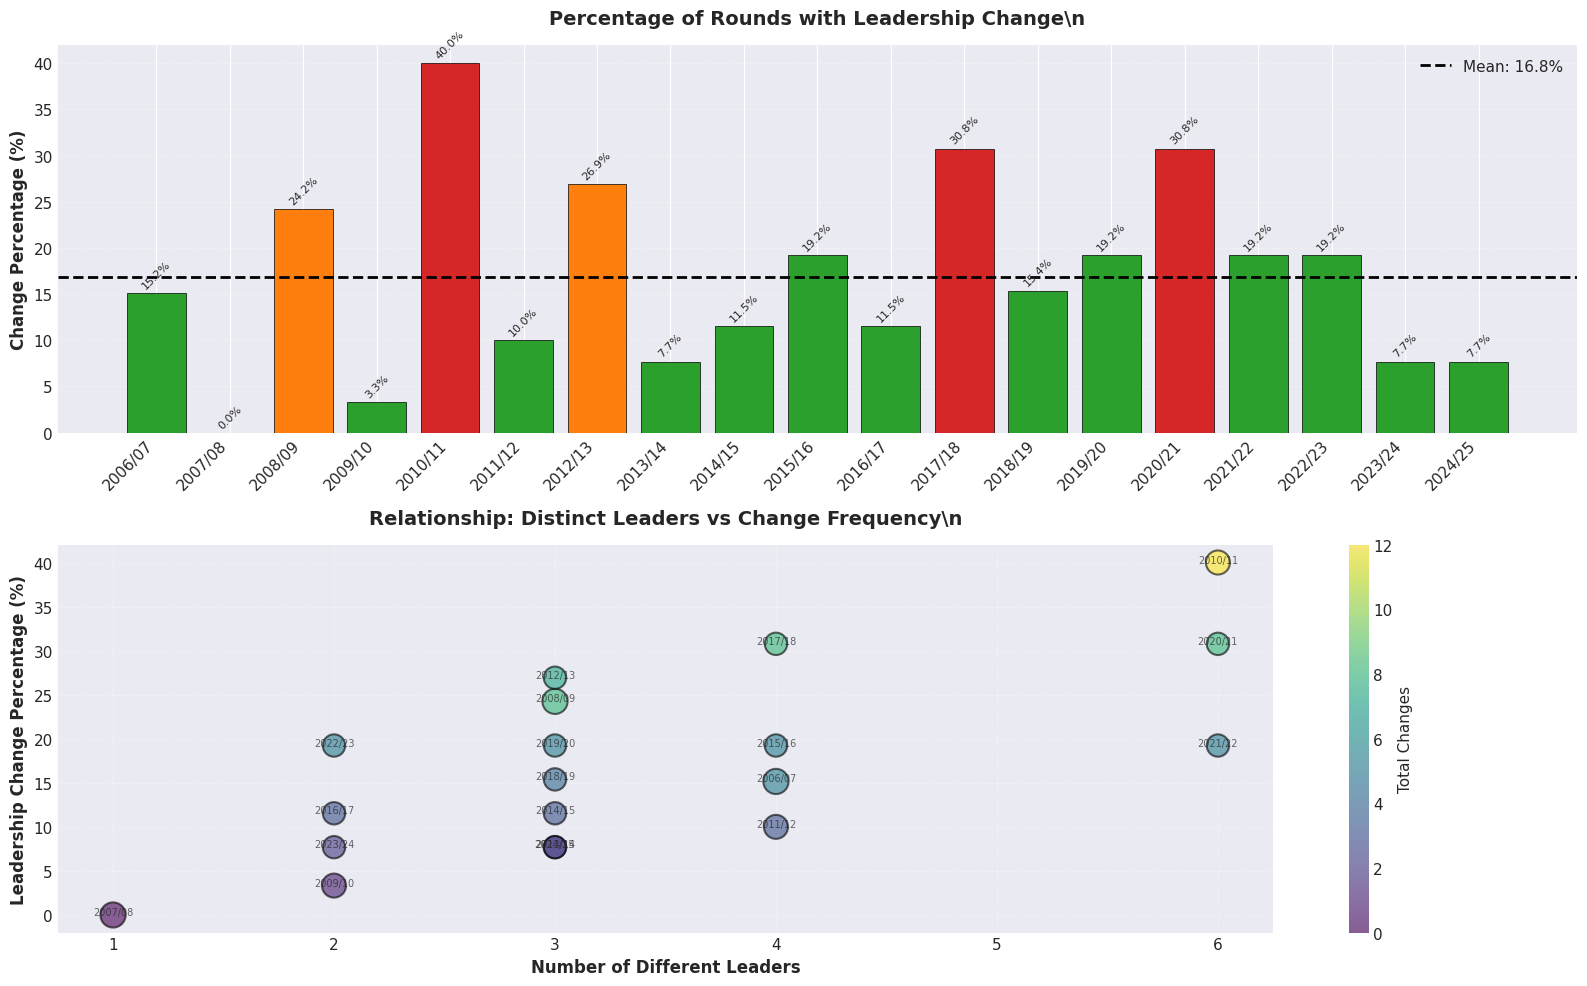


📊 Seasons by Leadership Change Frequency:

Most Dynamic (highest change %):


,season,leadership_changes,rounds,change_percentage,distinct_leaders
4,2010/11,12,30,40.000000,6
11,2017/18,8,26,30.769231,4
14,2020/21,8,26,30.769231,6
6,2012/13,7,26,26.923077,3
2,2008/09,8,33,24.242424,3



Most Stable (lowest change %):


,season,leadership_changes,rounds,change_percentage,distinct_leaders
17,2023/24,2,26,7.692308,2
18,2024/25,2,26,7.692308,3
7,2013/14,2,26,7.692308,3
3,2009/10,1,30,3.333333,2
1,2007/08,0,33,0.000000,1



📈 Overall Statistics:
  Mean change percentage: 16.82%
  Median change percentage: 15.38%
  Std deviation: 10.35%
  Range: 0.00% - 40.00%


In [107]:
# Calculate percentage of rounds with leadership change
summary_df['change_percentage'] = (summary_df['leadership_changes'] / summary_df['rounds']) * 100

# Visualization: Change percentage per season
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Bar chart
ax1 = axes[0]
colors2 = ['#d62728' if x >= 30 else '#ff7f0e' if x >= 20 else '#2ca02c' for x in summary_df['change_percentage']]
ax1.bar(range(len(summary_df)), summary_df['change_percentage'], color=colors2, edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(summary_df['season'], rotation=45, ha='right')
ax1.set_ylabel('Change Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Percentage of Rounds with Leadership Change\\n', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(summary_df['change_percentage'].mean(), color='black', linestyle='--', linewidth=2, 
            label=f"Mean: {summary_df['change_percentage'].mean():.1f}%")
ax1.legend()

# Add value labels
for i, v in enumerate(summary_df['change_percentage']):
    ax1.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=8, rotation=45)

# Scatter plot: Change % vs Distinct Leaders
ax2 = axes[1]
scatter = ax2.scatter(summary_df['distinct_leaders'], summary_df['change_percentage'],
                     s=summary_df['rounds']*10, alpha=0.6, 
                     c=summary_df['leadership_changes'], cmap='viridis',
                     edgecolors='black', linewidth=1.5)

# Add season labels
for _, row in summary_df.iterrows():
    ax2.annotate(row['season'], (row['distinct_leaders'], row['change_percentage']),
                fontsize=7, alpha=0.7, ha='center')

ax2.set_xlabel('Number of Different Leaders', fontsize=12, fontweight='bold')
ax2.set_ylabel('Leadership Change Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Relationship: Distinct Leaders vs Change Frequency\\n', 
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax2, label='Total Changes')

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_change_percentage.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Summary table with percentages
summary_with_pct = summary_df[['season', 'leadership_changes', 'rounds', 'change_percentage', 'distinct_leaders']].copy()
summary_with_pct = summary_with_pct.sort_values('change_percentage', ascending=False)

print("\n📊 Seasons by Leadership Change Frequency:\n")
print("Most Dynamic (highest change %):")
display(summary_with_pct.head(5))

print("\nMost Stable (lowest change %):")
display(summary_with_pct.tail(5))

print("\n📈 Overall Statistics:")
print(f"  Mean change percentage: {summary_df['change_percentage'].mean():.2f}%")
print(f"  Median change percentage: {summary_df['change_percentage'].median():.2f}%")
print(f"  Std deviation: {summary_df['change_percentage'].std():.2f}%")
print(f"  Range: {summary_df['change_percentage'].min():.2f}% - {summary_df['change_percentage'].max():.2f}%")

### 4.6 ניתוח פער נקודות - סיכום מקיף לכל העונות

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\points_gap_all_seasons_summary.png


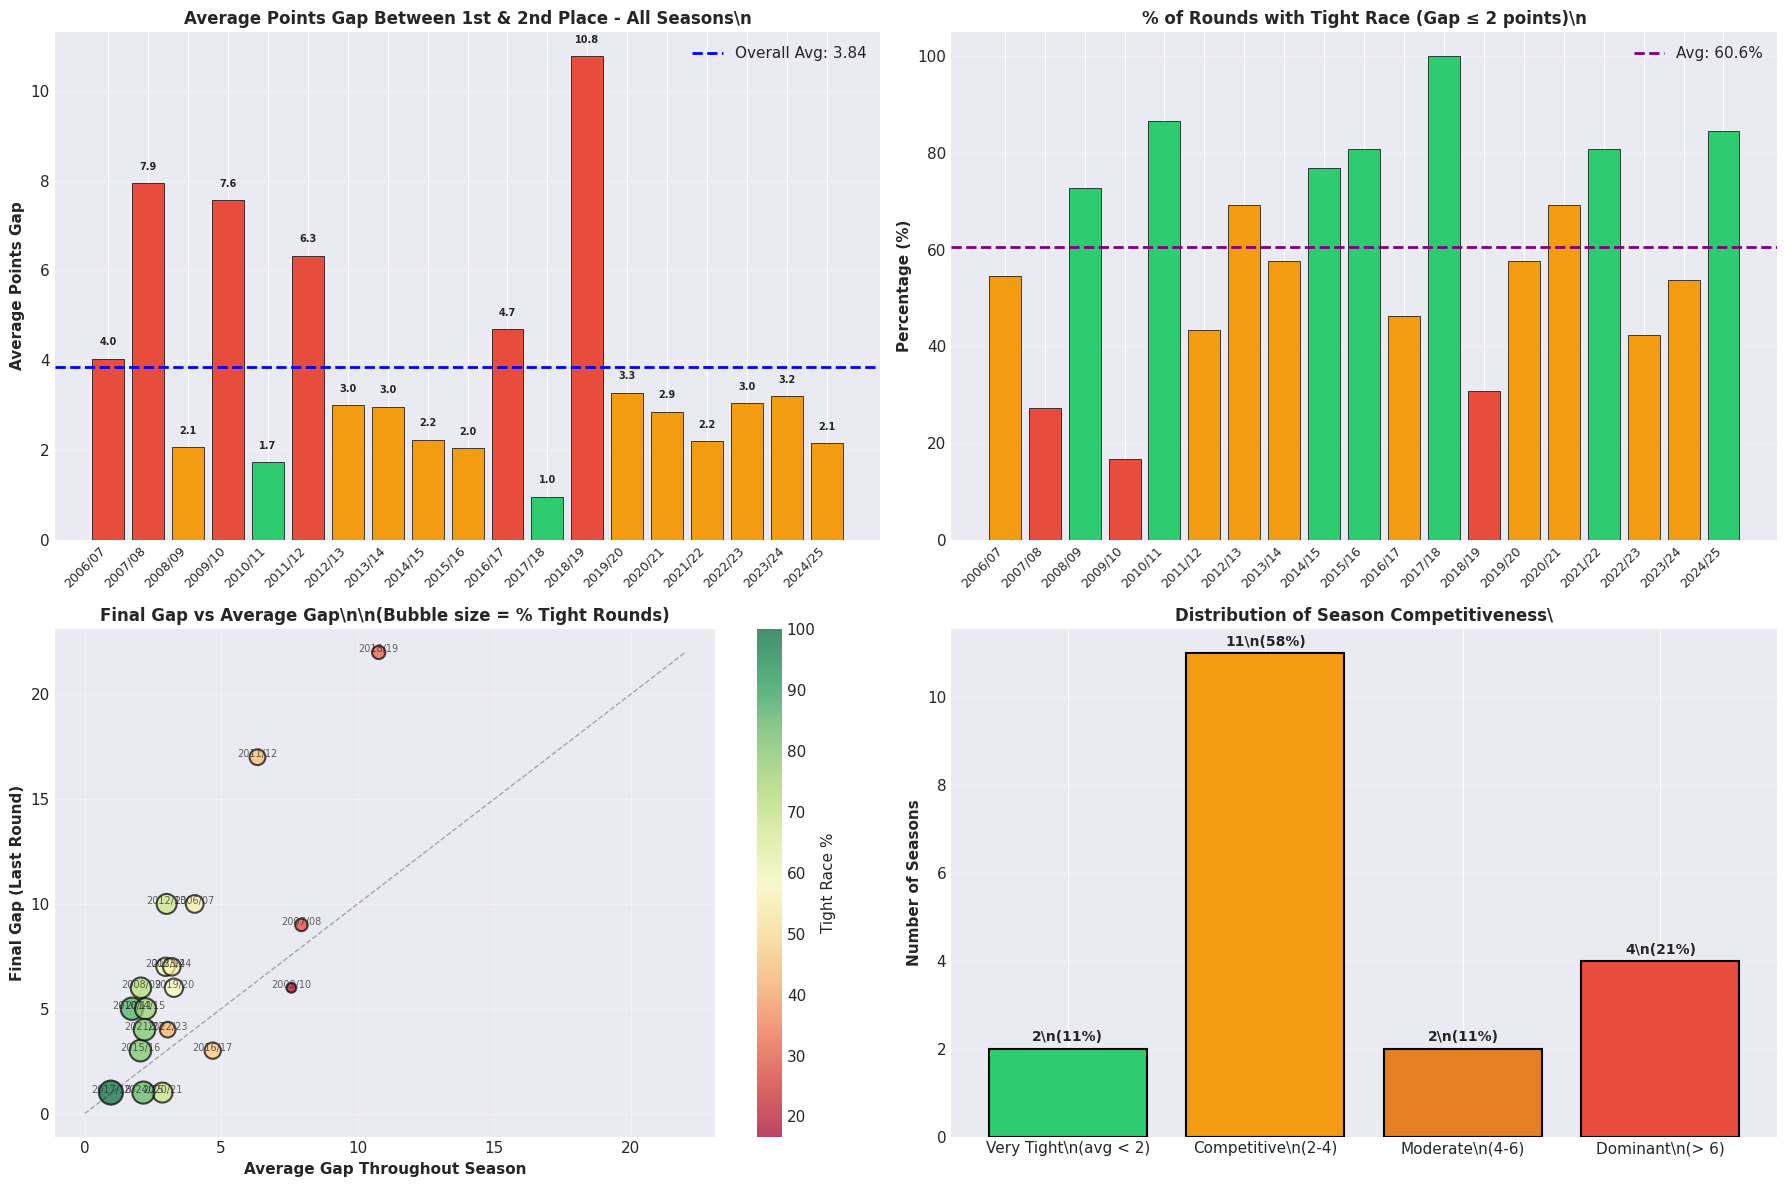


📊 POINTS GAP ANALYSIS - SUMMARY STATISTICS

📈 Overall Statistics:
   Total seasons analyzed: 19
   Average gap (overall): 3.84 points
   Most competitive season: 2017/18 (0.96 pts)
   Least competitive season: 2018/19 (10.77 pts)

🎯 Tight Race Analysis:
   Average tight race %: 60.6%
   Seasons with >50% tight rounds: 13
   Seasons with <20% tight rounds: 1


In [108]:
# Use the existing all_scraped_gaps_df data that we already have!
# This is much better than recalculating - it's the actual Transfermarkt scraped data

# Create comprehensive visualization of points gap across all seasons
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Average Gap per Season
ax1 = axes[0, 0]
colors = ['#2ecc71' if x < 2 else '#f39c12' if x < 4 else '#e74c3c' 
          for x in stats_df['avg_gap']]
bars1 = ax1.bar(range(len(stats_df)), stats_df['avg_gap'], 
               color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(len(stats_df)))
ax1.set_xticklabels(stats_df['season'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Average Points Gap', fontsize=11, fontweight='bold')
ax1.set_title('Average Points Gap Between 1st & 2nd Place - All Seasons\\n', 
              fontsize=12, fontweight='bold')
ax1.axhline(stats_df['avg_gap'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f'Overall Avg: {stats_df["avg_gap"].mean():.2f}')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Add value labels on bars
for i, (idx, row) in enumerate(stats_df.iterrows()):
    ax1.text(i, row['avg_gap'] + 0.3, f"{row['avg_gap']:.1f}", 
            ha='center', fontsize=7, fontweight='bold')

# 2. Tight Race Percentage
ax2 = axes[0, 1]
colors2 = ['#2ecc71' if x > 70 else '#f39c12' if x > 40 else '#e74c3c' 
           for x in stats_df['tight_pct']]
bars2 = ax2.bar(range(len(stats_df)), stats_df['tight_pct'], 
        color=colors2, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(stats_df)))
ax2.set_xticklabels(stats_df['season'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('% of Rounds with Tight Race (Gap ≤ 2 points)\\n', 
              fontsize=12, fontweight='bold')
ax2.axhline(stats_df['tight_pct'].mean(), color='purple', linestyle='--', 
            linewidth=2, label=f'Avg: {stats_df["tight_pct"].mean():.1f}%')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

# 3. Final Gap vs Average Gap
ax3 = axes[1, 0]
scatter = ax3.scatter(stats_df['avg_gap'], stats_df['final_gap'], 
                     s=stats_df['tight_pct']*3, 
                     c=stats_df['tight_pct'], cmap='RdYlGn',
                     alpha=0.7, edgecolors='black', linewidth=1.5)
for _, row in stats_df.iterrows():
    ax3.annotate(row['season'], (row['avg_gap'], row['final_gap']),
                fontsize=7, alpha=0.7, ha='center')
ax3.set_xlabel('Average Gap Throughout Season', fontsize=11, fontweight='bold')
ax3.set_ylabel('Final Gap (Last Round)', fontsize=11, fontweight='bold')
ax3.set_title('Final Gap vs Average Gap\\n\\n(Bubble size = % Tight Rounds)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3, label='Tight Race %')

# Add diagonal line (where final = average)
max_val = max(stats_df['avg_gap'].max(), stats_df['final_gap'].max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)

# 4. Distribution of Race Competitiveness
ax4 = axes[1, 1]
categories = ['Very Tight\\n(avg < 2)', 'Competitive\\n(2-4)', 
              'Moderate\\n(4-6)', 'Dominant\\n(> 6)']
counts = [
    (stats_df['avg_gap'] < 2).sum(),
    ((stats_df['avg_gap'] >= 2) & (stats_df['avg_gap'] < 4)).sum(),
    ((stats_df['avg_gap'] >= 4) & (stats_df['avg_gap'] < 6)).sum(),
    (stats_df['avg_gap'] >= 6).sum()
]
colors4 = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars4 = ax4.bar(categories, counts, color=colors4, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of Seasons', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Season Competitiveness\\', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, count) in enumerate(zip(bars4, counts)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}\\n({count/len(stats_df)*100:.0f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'points_gap_all_seasons_summary.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("📊 POINTS GAP ANALYSIS - SUMMARY STATISTICS")
print("="*80)
print(f"\n📈 Overall Statistics:")
print(f"   Total seasons analyzed: {len(stats_df)}")
print(f"   Average gap (overall): {stats_df['avg_gap'].mean():.2f} points")
print(f"   Most competitive season: {stats_df.loc[stats_df['avg_gap'].idxmin(), 'season']} ({stats_df['avg_gap'].min():.2f} pts)")
print(f"   Least competitive season: {stats_df.loc[stats_df['avg_gap'].idxmax(), 'season']} ({stats_df['avg_gap'].max():.2f} pts)")
print(f"\n🎯 Tight Race Analysis:")
print(f"   Average tight race %: {stats_df['tight_pct'].mean():.1f}%")
print(f"   Seasons with >50% tight rounds: {(stats_df['tight_pct'] > 50).sum()}")
print(f"   Seasons with <20% tight rounds: {(stats_df['tight_pct'] < 20).sum()}")

## 5. Regular Season Visualizations
### גרפים - ניתוח החרוץ האליפות בעונה הרגילה

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\seasons_avg_gap_comparison.png


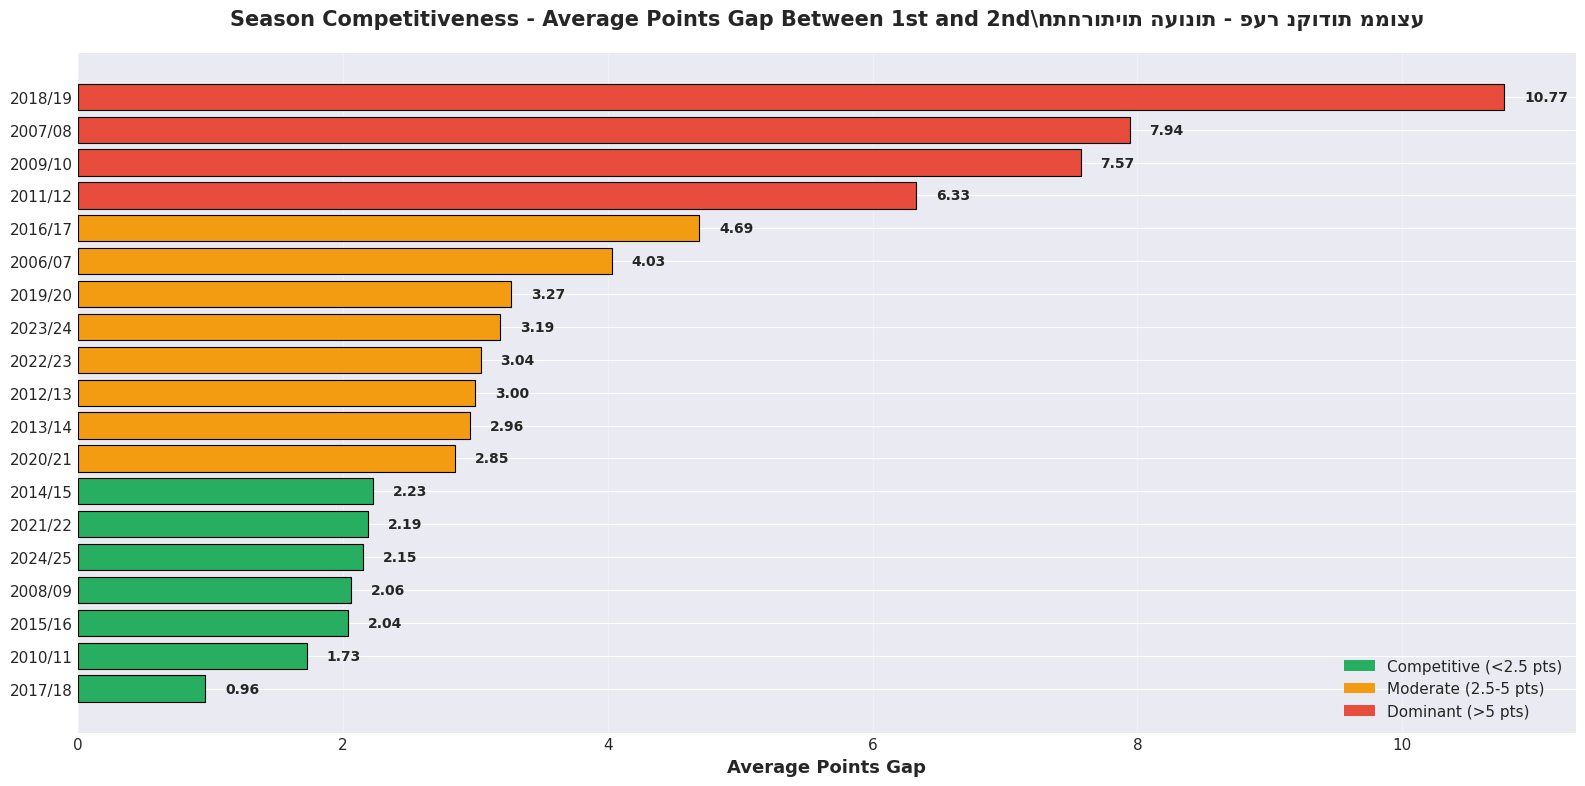

In [82]:
# Visualization 2: Compare all seasons - Average gap
fig, ax = plt.subplots(figsize=(16, 8))

# Sort by average gap
stats_sorted = stats_df.sort_values('avg_gap')

# Color code: green (competitive) to red (dominant)
colors = ['#27ae60' if x < 2.5 else '#f39c12' if x < 5 else '#e74c3c' for x in stats_sorted['avg_gap']]

bars = ax.barh(range(len(stats_sorted)), stats_sorted['avg_gap'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(stats_sorted)))
ax.set_yticklabels(stats_sorted['season'])
ax.set_xlabel('Average Points Gap', fontsize=13, fontweight='bold')
ax.set_title('Season Competitiveness - Average Points Gap Between 1st and 2nd\\nתחרותיות העונות - פער נקודות ממוצע', 
             fontsize=15, fontweight='bold', pad=20)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, stats_sorted['avg_gap'])):
    ax.text(val + 0.15, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Competitive (<2.5 pts)'),
    Patch(facecolor='#f39c12', label='Moderate (2.5-5 pts)'),
    Patch(facecolor='#e74c3c', label='Dominant (>5 pts)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()

fig_path = FIG_DIR / 'seasons_avg_gap_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

In [83]:
# Team name mapping: BetExplorer (playoff files) → Transfermarkt (regular season)
BETEXPLORER_TO_TM = {
    "Beitar Jerusalem": "B. Jerusalem",
    "Hapoel Beer Sheva": "Hapoel Be'er Sheva",
    "Hapoel Haifa": "Hapoel Haifa",
    "Hapoel Tel Aviv": "Hapoel Tel Aviv",
    "Maccabi Haifa": "Maccabi Haifa",
    "Maccabi Netanya": "Maccabi Netanya",
    "Maccabi Petah Tikva": "M. Petah Tikva",
    "Maccabi Tel Aviv": "M. Tel Aviv",
    "Hapoel Ramat Gan": "Hapoel Ramat Gan",
    "Ironi Kiryat Shmona": "Kiryat Shmona",
    "Bnei Yehuda Tel Aviv": "Bnei Yehuda",
    "Bnei Sakhnin": "Bnei Sachnin",
    "Hapoel Hadera": "Hapoel Hadera",
    "Ashdod": "FC Ashdod",
    "Hapoel Kfar Saba": "H. Kfar Saba",
    "Ironi Ramat HaSharon": "Ramat haSharon",
    "Hapoel Acre": "Hapoel Acre"
}

def map_team_name(betexplorer_name):
    """Map BetExplorer team name to Transfermarkt name"""
    return BETEXPLORER_TO_TM.get(betexplorer_name, betexplorer_name)

print("✅ Team name mapping created!")

✅ Team name mapping created!


In [84]:
def calculate_playoff_gaps(season_str):
    """
    Calculate playoff gaps with correct point transfer from regular season
    
    Handles two playoff formats:
    1. 2009/10-2011/12: Points divided (halved or reduced)
    2. 2012/13-2024/25: Full points transferred
    
    Args:
        season_str: Season like "2017/18"
    
    Returns:
        DataFrame with playoff gap data, or None if no playoff
    """
    # Check if playoff file exists in scraped_betexplorer directory
    # Format: championship_2017_18.csv (not 2017_2018)
    playoff_file = PLAYOFF_DIR / 'scraped_betexplorer' / f'championship_{season_str.replace("/", "_")}.csv'
    
    if not playoff_file.exists():
        print(f"  ⚠️ Playoff file not found: {playoff_file}")
        return None
    
    # Load playoff matches
    playoff_df = pd.read_csv(playoff_file)
    
    if len(playoff_df) == 0:
        return None
    
    # Get regular season final standings
    regular_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season_str]
    
    if len(regular_data) == 0:
        print(f"  ⚠️ No regular season data for {season_str}")
        return None
    
    # Get final round standings
    final_round = regular_data['round'].max()
    
    # Get all unique teams in playoff
    playoff_teams = set(playoff_df['home_team'].unique()) | set(playoff_df['away_team'].unique())
    
    # Map team names from BetExplorer to Transfermarkt
    playoff_teams_mapped = {map_team_name(team) for team in playoff_teams}
    
    # Initialize points from regular season
    starting_points = {}
    
    # Determine format based on season
    year = int(season_str.split('/')[0])
    
    # קיזוז היה רק ב-2009/10 ו-2010/11
    if season_str in ['2009/10', '2010/11']:  # Only these two seasons had point reduction
        # For these seasons, points were halved or divided
        # Get top 6 teams from regular season
        # We'll use the actual scraped standings to get the correct points
        
        # Get all teams' points from final round by scraping
        final_round_standings = scrape_transfermarkt_standings(season_str, final_round)
        
        if final_round_standings is not None:
            # Top 6 teams went to championship playoff
            top6 = final_round_standings.head(6)
            
            for _, row in top6.iterrows():
                team = row['team']
                # Points were halved (rounded down)
                starting_points[team] = row['points'] // 2
        
        print(f"  📊 {season_str} (קיזוז): Starting points halved")
    
    else:  # All other seasons: Full points transferred
        # Get all teams' final points
        final_round_standings = scrape_transfermarkt_standings(season_str, final_round)
        
        if final_round_standings is not None:
            # Top 6 teams went to championship playoff  
            top6 = final_round_standings.head(6)
            
            for _, row in top6.iterrows():
                team = row['team']
                # Full points transferred
                starting_points[team] = row['points']
        
        print(f"  📊 {season_str} (נקודות מלאות): Full points transferred")
    
    if not starting_points:
        print(f"  ❌ Could not get starting points for {season_str}")
        return None
    
    # Calculate points after each playoff round
    # Group playoff matches by round
    playoff_df_sorted = playoff_df.sort_values('round')
    
    # Create standings dictionary
    standings = starting_points.copy()
    
    gaps_data = []
    
    for round_num in sorted(playoff_df_sorted['round'].unique()):
        round_matches = playoff_df_sorted[playoff_df_sorted['round'] == round_num]
        
        # Process each match
        for _, match in round_matches.iterrows():
            home_team = map_team_name(match['home_team'])
            away_team = map_team_name(match['away_team'])
            home_score = match['home_goals']
            away_score = match['away_goals']
            
            # Award points
            if home_score > away_score:
                standings[home_team] = standings.get(home_team, 0) + 3
            elif away_score > home_score:
                standings[away_team] = standings.get(away_team, 0) + 3
            else:  # Draw
                standings[home_team] = standings.get(home_team, 0) + 1
                standings[away_team] = standings.get(away_team, 0) + 1
        
        # Get top 2
        sorted_teams = sorted(standings.items(), key=lambda x: x[1], reverse=True)
        
        if len(sorted_teams) >= 2:
            leader, leader_pts = sorted_teams[0]
            second, second_pts = sorted_teams[1]
            gap = leader_pts - second_pts
            
            gaps_data.append({
                'season': season_str,
                'round': round_num,
                'leader': leader,
                'leader_points': leader_pts,
                'second': second,
                'second_points': second_pts,
                'gap': gap
            })
    
    if not gaps_data:
        return None
    
    df = pd.DataFrame(gaps_data)
    print(f"  ✅ Collected {len(df)} playoff rounds")
    
    return df

print("✅ Playoff calculation function created!")

✅ Playoff calculation function created!


In [85]:
# ============================================================================
# LOAD PLAYOFF GAPS DATA
# ============================================================================
# Load the accurate playoff gaps data (with gap, leader, second columns)

print("="*80)
print("🏆 LOADING PLAYOFF GAPS DATA")
print("="*80)
print()

# Main playoff gaps file with full data (gap, leader, second, etc.)
PLAYOFF_GAPS_FILE = SCRAPED_DATA_DIR / "playoff_gaps_all_seasons.csv"

# Check if main playoff gaps file exists
if PLAYOFF_GAPS_FILE.exists():
    print(f"✅ Loading playoff gaps data from: {PLAYOFF_GAPS_FILE.name}")
    
    # Load detailed playoff gaps data
    all_playoff_gaps_df = pd.read_csv(PLAYOFF_GAPS_FILE)
    
    print("="*80)
    print(f"✅ PLAYOFF DATA LOADED SUCCESSFULLY")
    print("="*80)
    print()
    print(f"📊 Playoff data summary:")
    print(f"   Total records: {len(all_playoff_gaps_df):,}")
    print(f"   Seasons: {all_playoff_gaps_df['season'].nunique()}")
    print(f"   Columns: {', '.join(all_playoff_gaps_df.columns.tolist())}")
    print()
    
    # Show summary per season
    print("📋 Playoff rounds per season:")
    for season in sorted(all_playoff_gaps_df['season'].unique()):
        count = len(all_playoff_gaps_df[all_playoff_gaps_df['season'] == season])
        avg_gap = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season]['gap'].mean()
        print(f"   {season}: {count} rounds, avg gap: {avg_gap:.2f} pts")
    print()
    
    # Show sample data
    print("📋 Sample playoff data:")
    display(all_playoff_gaps_df.head(10))
    
else:
    print(f"⚠️ Main playoff gaps file not found: {PLAYOFF_GAPS_FILE.name}")
    print(f"   This file should have been created by cell 25.")
    print(f"   Please run cell 25 to create the playoff gaps data.")
    print()
    
    # Check for the old leader-changes-only CSV
    PLAYOFF_DETAILED_FILE = SCRAPED_DATA_DIR / "playoff_first_place_changes_detailed.csv"
    
    if PLAYOFF_DETAILED_FILE.exists():
        print(f"⚠️ Found old format playoff file (leader changes only): {PLAYOFF_DETAILED_FILE.name}")
        print(f"   This file doesn't have gap data needed for analysis.")
        print(f"   Please run cell 25 to create the proper playoff gaps data.")
    
    print()
    print("Attempting to calculate playoff gaps as fallback...")
    all_playoff_gaps = []
    playoff_seasons = [s for s in all_scraped_gaps_df['season'].unique() if int(s.split('/')[0]) >= 2009]
    
    for season in playoff_seasons:
        print(f"Processing {season}...")
        playoff_gap_df = calculate_playoff_gaps(season)
        
        if playoff_gap_df is not None:
            all_playoff_gaps.append(playoff_gap_df)
    
    if all_playoff_gaps:
        all_playoff_gaps_df = pd.concat(all_playoff_gaps, ignore_index=True)
        print(f"✅ Calculated playoff data for {all_playoff_gaps_df['season'].nunique()} seasons")
        
        # Save for future use
        all_playoff_gaps_df.to_csv(PLAYOFF_GAPS_FILE, index=False)
        print(f"💾 Saved to: {PLAYOFF_GAPS_FILE}")
    else:
        print("❌ No playoff data available")
        all_playoff_gaps_df = None

🏆 LOADING PLAYOFF GAPS DATA

⚠️ Main playoff gaps file not found: playoff_gaps_all_seasons.csv
   This file should have been created by cell 25.
   Please run cell 25 to create the playoff gaps data.

⚠️ Found old format playoff file (leader changes only): playoff_first_place_changes_detailed.csv
   This file doesn't have gap data needed for analysis.
   Please run cell 25 to create the proper playoff gaps data.

Attempting to calculate playoff gaps as fallback...
Processing 2009/10...
  📊 2009/10 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds
Processing 2010/11...
  📊 2010/11 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds
Processing 2011/12...
  📊 2011/12 (נקודות מלאות): Full points transferred
  ✅ Collected 7 playoff rounds
Processing 2012/13...
  📊 2012/13 (נקודות מלאות): Full points transferred
  ✅ Collected 10 playoff rounds
Processing 2013/14...
  📊 2013/14 (נקודות מלאות): Full points transferred
  ✅ Collected 10 playoff rounds
Processing 2014/15..

In [86]:
# Compare regular season vs playoff gaps
if all_playoff_gaps_df is not None:
    comparison_data = []
    
    for season in all_playoff_gaps_df['season'].unique():
        # Regular season final gap
        reg_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
        reg_final_gap = reg_data.iloc[-1]['gap']
        reg_avg_gap = reg_data['gap'].mean()
        
        # Playoff final gap
        playoff_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season]
        playoff_final_gap = playoff_data.iloc[-1]['gap']
        playoff_avg_gap = playoff_data['gap'].mean()
        
        # Determine outcome
        if playoff_final_gap > reg_final_gap:
            outcome = "Gap increased"
        elif playoff_final_gap < reg_final_gap:
            outcome = "Gap decreased"
        else:
            outcome = "Gap stayed same"
        
        comparison_data.append({
            'season': season,
            'reg_final_gap': reg_final_gap,
            'playoff_final_gap': playoff_final_gap,
            'gap_change': playoff_final_gap - reg_final_gap,
            'reg_avg_gap': round(reg_avg_gap, 2),
            'playoff_avg_gap': round(playoff_avg_gap, 2),
            'outcome': outcome
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("="*80)
    print("📊 REGULAR SEASON vs PLAYOFF COMPARISON")
    print("="*80)
    print()
    print(comparison_df.to_string(index=False))
    print()
    print("="*80)
    print("📈 Summary:")
    print("="*80)
    print(f"Gap increased in playoffs: {len(comparison_df[comparison_df['gap_change'] > 0])} seasons")
    print(f"Gap decreased in playoffs: {len(comparison_df[comparison_df['gap_change'] < 0])} seasons")
    print(f"Gap stayed same: {len(comparison_df[comparison_df['gap_change'] == 0])} seasons")
    print()
    print(f"Average gap change: {comparison_df['gap_change'].mean():.2f} points")
else:
    print("⚠️ No playoff data available for comparison")
    comparison_df = None

📊 REGULAR SEASON vs PLAYOFF COMPARISON

 season  reg_final_gap  playoff_final_gap  gap_change  reg_avg_gap  playoff_avg_gap       outcome
2009/10              6                  0          -6         7.57             1.00 Gap decreased
2010/11              5                  8           3         1.73             4.60 Gap increased
2011/12             17                 14          -3         6.33            15.14 Gap decreased
2012/13             10                 13           3         3.00            12.10 Gap increased
2013/14              7                 16           9         2.96            10.90 Gap increased
2014/15              5                  6           1         2.23             7.60 Gap increased
2015/16              3                  2          -1         2.04             2.00 Gap decreased
2016/17              3                 13          10         4.69             8.00 Gap increased
2017/18              1                  9           8         0.96            

### 6.1 ניתוח חילופי הנהגה בפלייאוף

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_changes_regular_vs_playoff.png


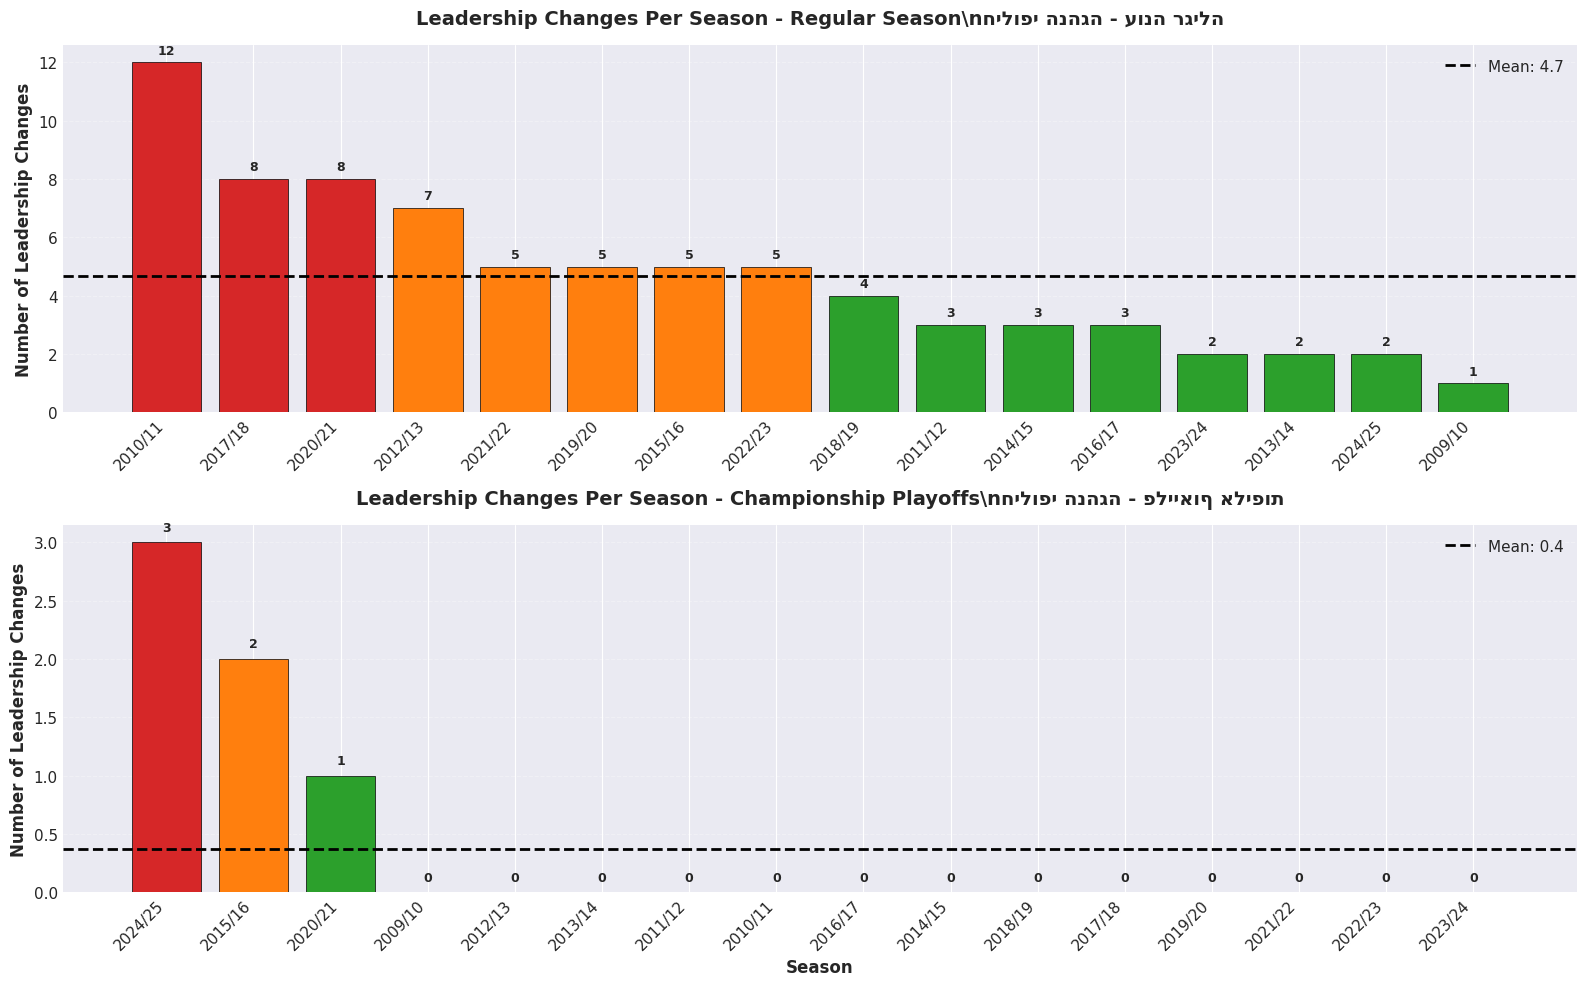


📊 Leadership Changes Statistics:



,Phase,Mean,Median,Min,Max,Std Dev
0,Regular Season,4.6875,4.5,1,12,2.891799
1,Championship Playoffs,0.3750,0.0,0,3,0.885061



🏆 Most Competitive Playoff Seasons:


,season,playoff_leadership_changes,playoff_distinct_leaders
15,2024/25,3,2
6,2015/16,2,2
11,2020/21,1,2
0,2009/10,0,1
1,2010/11,0,1



😴 Most Stable Playoff Seasons:


,season,playoff_leadership_changes,playoff_distinct_leaders
0,2009/10,0,1
1,2010/11,0,1
2,2011/12,0,1
3,2012/13,0,1
4,2013/14,0,1


In [87]:
# Calculate leadership changes for playoffs
if all_playoff_gaps_df is not None:
    playoff_summary_data = []
    
    for season in all_playoff_gaps_df['season'].unique():
        season_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season].sort_values('round')
        
        # Count leadership changes
        changes = 0
        prev_leader = None
        
        for _, row in season_data.iterrows():
            current_leader = row['leader']
            if prev_leader is not None and current_leader != prev_leader:
                changes += 1
            prev_leader = current_leader
        
        # Count distinct leaders
        distinct = season_data['leader'].nunique()
        
        # Get first and last leader
        first = season_data.iloc[0]['leader']
        last = season_data.iloc[-1]['leader']
        
        playoff_summary_data.append({
            'season': season,
            'playoff_leadership_changes': changes,
            'playoff_distinct_leaders': distinct,
            'playoff_first_leader': first,
            'playoff_last_leader': last,
            'playoff_rounds': len(season_data)
        })
    
    playoff_summary_df = pd.DataFrame(playoff_summary_data)
    
    # Visualization: Compare regular season vs playoff leadership changes
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Regular season (from summary_df)
    ax1 = axes[0]
    summary_sorted = summary_df[summary_df['season'].isin(playoff_summary_df['season'])].sort_values('leadership_changes', ascending=False)
    colors = ['#d62728' if x >= 8 else '#ff7f0e' if x >= 5 else '#2ca02c' for x in summary_sorted['leadership_changes']]
    
    ax1.bar(range(len(summary_sorted)), summary_sorted['leadership_changes'], color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_xticks(range(len(summary_sorted)))
    ax1.set_xticklabels(summary_sorted['season'], rotation=45, ha='right')
    ax1.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
    ax1.set_title('Leadership Changes Per Season - Regular Season\\nחילופי הנהגה - עונה רגילה', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.axhline(summary_sorted['leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
               label=f"Mean: {summary_sorted['leadership_changes'].mean():.1f}")
    ax1.legend()
    
    # Add value labels on bars
    for i, v in enumerate(summary_sorted['leadership_changes']):
        ax1.text(i, v + 0.3, str(int(v)), ha='center', fontsize=9, fontweight='bold')
    
    # Playoff comparison
    ax2 = axes[1]
    playoff_sorted = playoff_summary_df.sort_values('playoff_leadership_changes', ascending=False)
    colors_playoff = ['#d62728' if x >= 3 else '#ff7f0e' if x >= 2 else '#2ca02c' for x in playoff_sorted['playoff_leadership_changes']]
    
    ax2.bar(range(len(playoff_sorted)), playoff_sorted['playoff_leadership_changes'], color=colors_playoff, edgecolor='black', linewidth=0.5)
    ax2.set_xticks(range(len(playoff_sorted)))
    ax2.set_xticklabels(playoff_sorted['season'], rotation=45, ha='right')
    ax2.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax2.set_title('Leadership Changes Per Season - Championship Playoffs\\nחילופי הנהגה - פלייאוף אליפות', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.axhline(playoff_sorted['playoff_leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
               label=f"Mean: {playoff_sorted['playoff_leadership_changes'].mean():.1f}")
    ax2.legend()
    
    # Add value labels on bars
    for i, v in enumerate(playoff_sorted['playoff_leadership_changes']):
        ax2.text(i, v + 0.1, str(int(v)), ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    fig_path = FIG_DIR / 'leadership_changes_regular_vs_playoff.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {fig_path}")
    plt.show()
    
    # Summary statistics table
    print("\n📊 Leadership Changes Statistics:\n")
    stats_table = pd.DataFrame({
        'Phase': ['Regular Season', 'Championship Playoffs'],
        'Mean': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].mean(), 
                 playoff_summary_df['playoff_leadership_changes'].mean()],
        'Median': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].median(), 
                   playoff_summary_df['playoff_leadership_changes'].median()],
        'Min': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].min(), 
                playoff_summary_df['playoff_leadership_changes'].min()],
        'Max': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].max(), 
                playoff_summary_df['playoff_leadership_changes'].max()],
        'Std Dev': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].std(), 
                    playoff_summary_df['playoff_leadership_changes'].std()],
    })
    display(stats_table)
    
    print("\n🏆 Most Competitive Playoff Seasons:")
    display(playoff_summary_df.nlargest(5, 'playoff_leadership_changes')[['season', 'playoff_leadership_changes', 'playoff_distinct_leaders']])
    
    print("\n😴 Most Stable Playoff Seasons:")
    display(playoff_summary_df.nsmallest(5, 'playoff_leadership_changes')[['season', 'playoff_leadership_changes', 'playoff_distinct_leaders']])
else:
    print("⚠️ No playoff data available for leadership changes analysis")

## 9. Championship Contenders Analysis
### ניתוח קבוצות בתמונת האליפות - כמה קבוצות היו "בתמונה" בכל מחזור

**הגדרה:** קבוצה נחשבת "בתמונת האליפות" אם היא בפער של **≤6 נקודות** מהמקום הראשון.

In [89]:
print("="*80)
print("🏆 CHAMPIONSHIP CONTENDERS ANALYSIS")
print("="*80)
print()
print("📋 Definition: A team is a 'contender' if within 6 points of 1st place")
print("⚠️ NOTE: Analysis starts from ROUND 7 to avoid early-season noise")
print("   (All teams start at 0 points, making rounds 1-6 artificially crowded)")
print()

# We need to scrape full standings for each round to get all teams' points
# Let's use a cache to avoid re-scraping

MIN_ROUND = 7  # Start analysis from round 7
CONTENDERS_CACHE_FILE = SCRAPED_DATA_DIR / 'championship_contenders_per_round_from_r7.csv'

if CONTENDERS_CACHE_FILE.exists():
    print("✅ Loading cached contenders data (from round 7)...")
    contenders_df = pd.read_csv(CONTENDERS_CACHE_FILE)
    print(f"   Loaded: {len(contenders_df)} records")
    print()
else:
    print("⚠️ No cache found. Scraping full standings for all seasons...")
    print("   This will take ~10-15 minutes...")
    print()
    
    contenders_data = []
    
    # Process each season
    for season in sorted(all_scraped_gaps_df['season'].unique()):
        season_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
        max_round = season_data['round'].max()
        
        print(f"📊 Processing {season} ({max_round} rounds, starting from round {MIN_ROUND})...")
        
        for round_num in range(MIN_ROUND, max_round + 1):  # Start from round 7
            # Scrape full standings for this round
            standings = scrape_transfermarkt_standings(season, round_num)
            
            if standings is not None and len(standings) > 0:
                # Get leader's points
                leader_points = standings.iloc[0]['points']
                
                # Count teams within 6 points
                contenders = standings[standings['points'] >= leader_points - 6]
                num_contenders = len(contenders)
                
                # Get team names
                contender_teams = ', '.join(contenders['team'].tolist())
                
                contenders_data.append({
                    'season': season,
                    'round': round_num,
                    'leader_points': leader_points,
                    'num_contenders': num_contenders,
                    'contender_teams': contender_teams
                })
            else:
                print(f"  ⚠️ Failed to scrape round {round_num}")
            
            # Small delay to avoid overwhelming server
            time.sleep(0.3)
        
        print(f"  ✅ Completed {season}")
    
    contenders_df = pd.DataFrame(contenders_data)
    
    # Save to cache
    contenders_df.to_csv(CONTENDERS_CACHE_FILE, index=False, encoding='utf-8-sig')
    print()
    print(f"💾 Saved cache to: {CONTENDERS_CACHE_FILE}")
    print()

print("="*80)
print("📊 CONTENDERS DATA SUMMARY")
print("="*80)
print()
print(f"Total records: {len(contenders_df)}")
print(f"Seasons: {contenders_df['season'].nunique()}")
print(f"Average contenders per round (overall): {contenders_df['num_contenders'].mean():.2f}")
print(f"Median contenders per round: {contenders_df['num_contenders'].median():.1f}")
print(f"Max contenders in a single round: {contenders_df['num_contenders'].max()}")
print(f"Min contenders in a single round: {contenders_df['num_contenders'].min()}")
print()

# Calculate average contenders per season
season_contenders = contenders_df.groupby('season').agg({
    'num_contenders': ['mean', 'median', 'max', 'min', 'std']
}).round(2)

season_contenders.columns = ['Avg Contenders', 'Median Contenders', 'Max Contenders', 'Min Contenders', 'Std Dev']
season_contenders = season_contenders.reset_index()

print("📋 Average contenders per season:")
print()
display(season_contenders)
print()

# Most competitive seasons (highest avg contenders)
print("🏆 Most Competitive Seasons (Most teams in title race):")
display(season_contenders.nlargest(5, 'Avg Contenders')[['season', 'Avg Contenders', 'Max Contenders']])
print()

# Least competitive seasons
print("😴 Least Competitive Seasons (Fewest teams in title race):")
display(season_contenders.nsmallest(5, 'Avg Contenders')[['season', 'Avg Contenders', 'Min Contenders']])
print()

🏆 CHAMPIONSHIP CONTENDERS ANALYSIS

📋 Definition: A team is a 'contender' if within 6 points of 1st place
⚠️ NOTE: Analysis starts from ROUND 7 to avoid early-season noise
   (All teams start at 0 points, making rounds 1-6 artificially crowded)

✅ Loading cached contenders data (from round 7)...
   Loaded: 400 records

📊 CONTENDERS DATA SUMMARY

Total records: 400
Seasons: 19
Average contenders per round (overall): 2.70
Median contenders per round: 2.0
Max contenders in a single round: 10
Min contenders in a single round: 1

📋 Average contenders per season:



,season,Avg Contenders,Median Contenders,Max Contenders,Min Contenders,Std Dev
0,2006/07,3.76,3.0,8,1,2.50
1,2007/08,1.52,1.0,4,1,0.98
2,2008/09,2.63,3.0,4,2,0.69
3,2009/10,1.12,1.0,2,1,0.34
4,2010/11,3.54,3.0,9,1,2.11
5,2011/12,3.96,2.0,10,1,3.71
6,2012/13,2.37,3.0,4,1,0.96
7,2013/14,2.50,2.0,7,1,1.43
8,2014/15,2.84,3.0,4,2,0.50
9,2015/16,2.90,2.0,8,2,1.83



🏆 Most Competitive Seasons (Most teams in title race):


,season,Avg Contenders,Max Contenders
11,2017/18,4.28,7
5,2011/12,3.96,10
0,2006/07,3.76,8
4,2010/11,3.54,9
18,2024/25,3.45,7



😴 Least Competitive Seasons (Fewest teams in title race):


,season,Avg Contenders,Min Contenders
3,2009/10,1.12,1
12,2018/19,1.15,1
1,2007/08,1.52,1
10,2016/17,2.00,1
13,2019/20,2.26,2


💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\contenders_per_season_bar.png


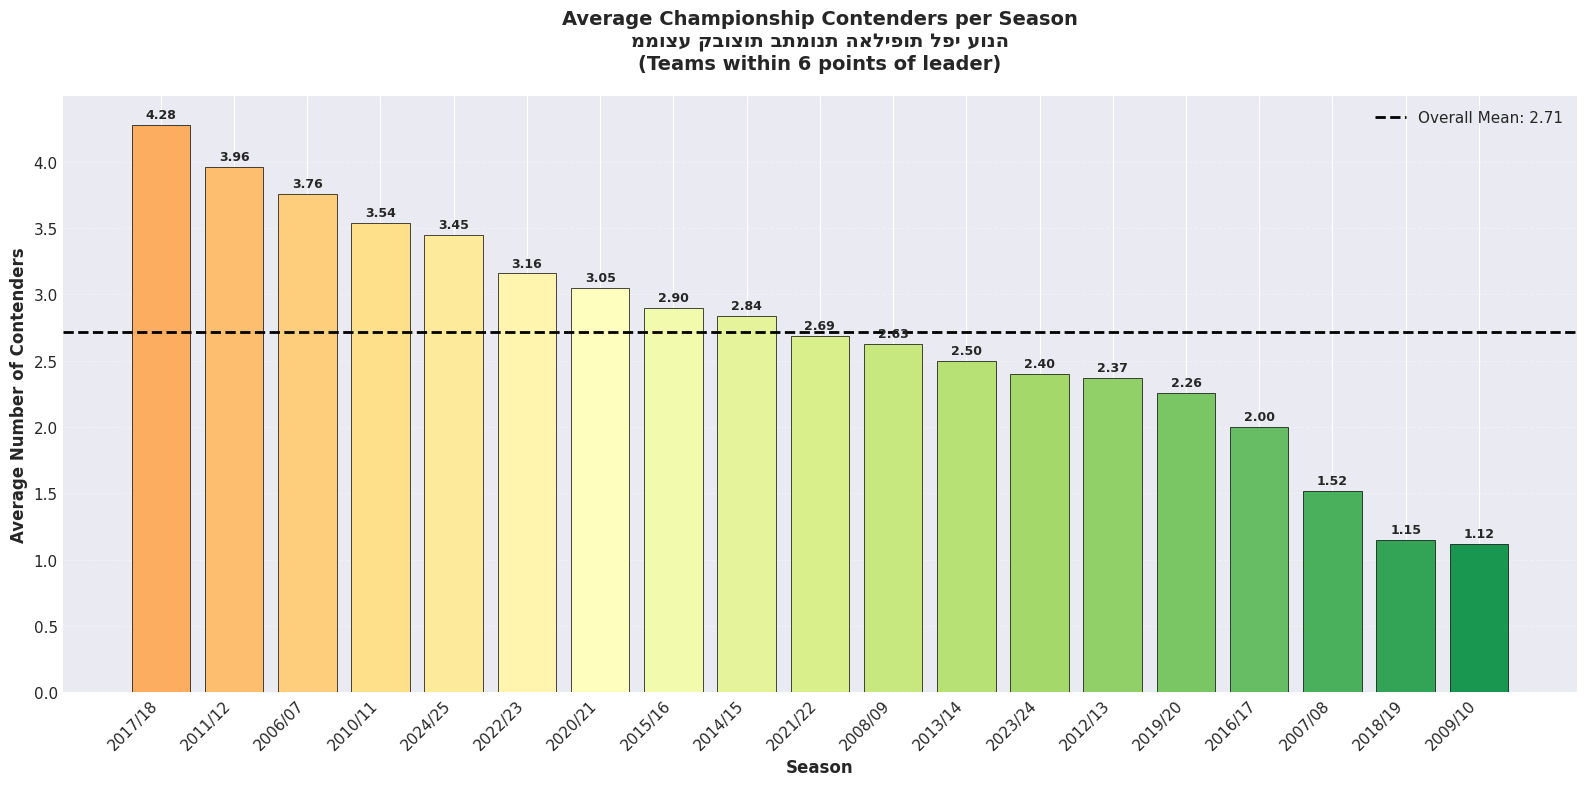

In [90]:
# Visualization 1: Average contenders per season (bar chart)
fig, ax = plt.subplots(figsize=(16, 8))

season_avg_contenders = season_contenders.sort_values('Avg Contenders', ascending=False)

# Color code: more contenders = more competitive (green), fewer = less competitive (red)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(season_avg_contenders)))

bars = ax.bar(range(len(season_avg_contenders)), 
              season_avg_contenders['Avg Contenders'],
              color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(len(season_avg_contenders)))
ax.set_xticklabels(season_avg_contenders['season'], rotation=45, ha='right')
ax.set_ylabel('Average Number of Contenders', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Average Championship Contenders per Season\nממוצע קבוצות בתמונת האליפות לפי עונה\n(Teams within 6 points of leader)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add mean line
mean_contenders = season_avg_contenders['Avg Contenders'].mean()
ax.axhline(mean_contenders, color='black', linestyle='--', linewidth=2, 
           label=f'Overall Mean: {mean_contenders:.2f}')
ax.legend(fontsize=11)

# Add value labels on bars
for i, (idx, row) in enumerate(season_avg_contenders.iterrows()):
    ax.text(i, row['Avg Contenders'] + 0.05, f"{row['Avg Contenders']:.2f}", 
            ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'contenders_per_season_bar.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\contenders_over_time_sample_seasons.png


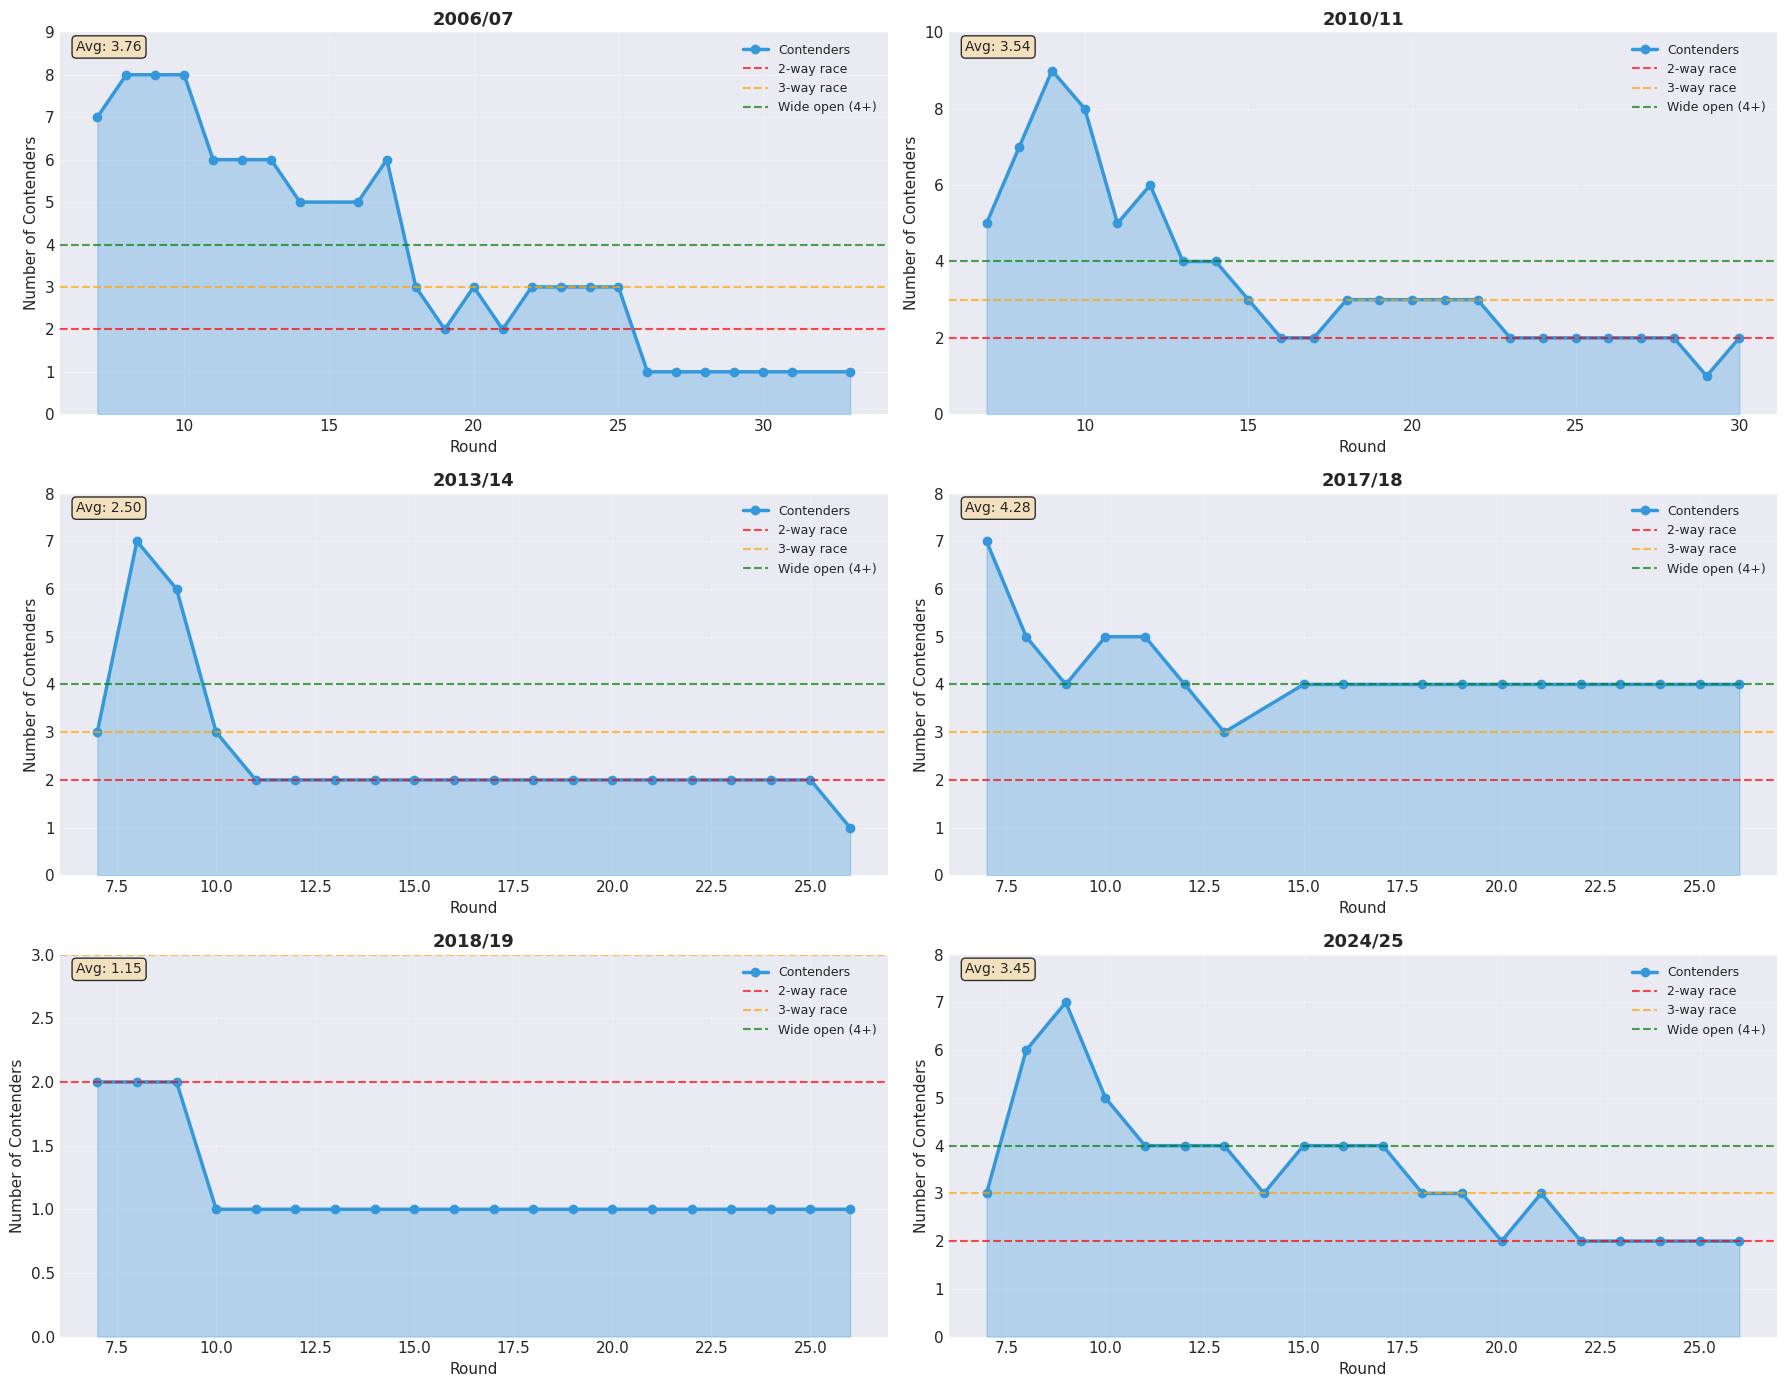

In [91]:
# Visualization 2: Contenders over time (line plot for selected seasons)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

# Select 6 interesting seasons
sample_seasons = [
    '2006/07',  # Early season
    '2010/11',  # Competitive
    '2013/14',  # Mid-period
    '2017/18',  # Most competitive
    '2018/19',  # Least competitive
    '2024/25'   # Latest season
]

for idx, season in enumerate(sample_seasons):
    ax = axes[idx]
    season_data = contenders_df[contenders_df['season'] == season]
    
    # Plot contenders over rounds
    ax.plot(season_data['round'], season_data['num_contenders'], 
            marker='o', linewidth=2.5, markersize=6, color='#3498db', label='Contenders')
    ax.fill_between(season_data['round'], season_data['num_contenders'], 
                     alpha=0.3, color='#3498db')
    
    # Add horizontal lines for reference
    ax.axhline(2, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='2-way race')
    ax.axhline(3, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='3-way race')
    ax.axhline(4, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Wide open (4+)')
    
    # Styling
    ax.set_title(f'{season}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Number of Contenders', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='upper right')
    ax.set_ylim(0, season_data['num_contenders'].max() + 1)
    
    # Add statistics text
    avg_contenders = season_data['num_contenders'].mean()
    text_str = f'Avg: {avg_contenders:.2f}'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',   
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
fig_path = FIG_DIR / 'contenders_over_time_sample_seasons.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\contenders_distribution.png


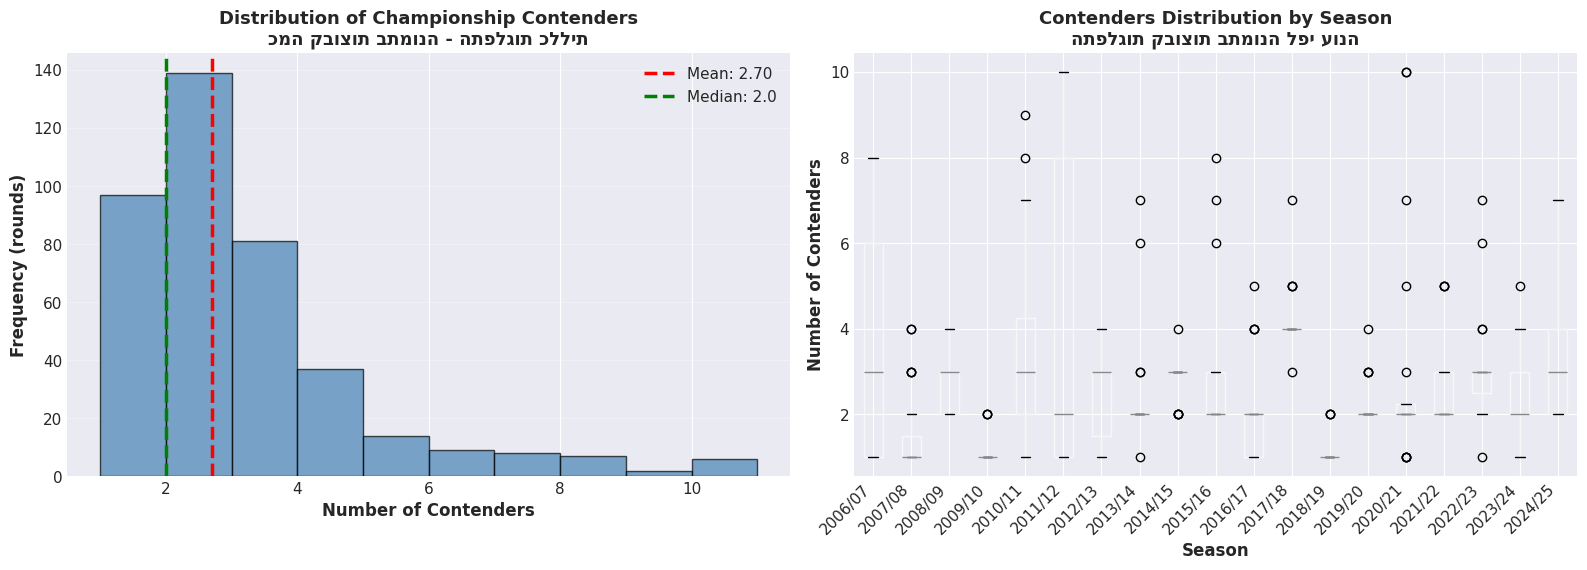

In [92]:
# Visualization 3: Distribution of contenders (histogram)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of contenders per round (all data)
ax1.hist(contenders_df['num_contenders'], bins=range(1, contenders_df['num_contenders'].max() + 2), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(contenders_df['num_contenders'].mean(), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {contenders_df["num_contenders"].mean():.2f}')
ax1.axvline(contenders_df['num_contenders'].median(), color='green', linestyle='--', linewidth=2.5, 
           label=f'Median: {contenders_df["num_contenders"].median():.1f}')
ax1.set_xlabel('Number of Contenders', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency (rounds)', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Championship Contenders\nכמה קבוצות בתמונה - התפלגות כללית', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Box plot by season
contenders_df.boxplot(column='num_contenders', by='season', ax=ax2)
ax2.set_title('Contenders Distribution by Season\nהתפלגות קבוצות בתמונה לפי עונה', 
              fontsize=13, fontweight='bold')
ax2.set_xlabel('Season', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Contenders', fontsize=12, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
fig_path = FIG_DIR / 'contenders_distribution.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

In [93]:
# Analysis: Race type classification (2-way, 3-way, wide open)
print("\n" + "="*80)
print("🎯 RACE TYPE CLASSIFICATION")
print("="*80)
print()

# Classify each round
contenders_df['race_type'] = contenders_df['num_contenders'].apply(
    lambda x: '2-way race' if x == 2 else ('3-way race' if x == 3 else ('Wide open (4+)' if x >= 4 else 'Runaway (1)'))
)

# Overall distribution
race_type_counts = contenders_df['race_type'].value_counts()
race_type_pcts = (race_type_counts / len(contenders_df) * 100).round(1)

print("📊 Overall race type distribution:")
print()
for race_type, count in race_type_counts.items():
    pct = race_type_pcts[race_type]
    print(f"  {race_type:20s}: {count:4d} rounds ({pct:5.1f}%)")
print()

# By season
print("📋 Race type breakdown by season:")
print()

race_type_by_season = contenders_df.groupby(['season', 'race_type']).size().unstack(fill_value=0)
race_type_by_season_pct = race_type_by_season.div(race_type_by_season.sum(axis=1), axis=0) * 100

# Calculate dominant race type per season
dominant_type = race_type_by_season_pct.idxmax(axis=1)

season_race_summary = pd.DataFrame({
    'Season': race_type_by_season.index,
    'Dominant Type': dominant_type.values,
    '2-way (%)': race_type_by_season_pct.get('2-way race', pd.Series(0, index=race_type_by_season.index)).round(1),
    '3-way (%)': race_type_by_season_pct.get('3-way race', pd.Series(0, index=race_type_by_season.index)).round(1),
    'Wide open (%)': race_type_by_season_pct.get('Wide open (4+)', pd.Series(0, index=race_type_by_season.index)).round(1),
    'Runaway (%)': race_type_by_season_pct.get('Runaway (1)', pd.Series(0, index=race_type_by_season.index)).round(1)
})

display(season_race_summary)
print()

# Insights
print("💡 Key Insights:")
print()
print(f"  • Most common race type: {race_type_counts.idxmax()}")
print(f"  • Typical Israeli title race: {race_type_pcts.idxmax()} ({race_type_pcts.max():.1f}% of rounds)")
print(f"  • True 2-way races: {race_type_pcts.get('2-way race', 0):.1f}% of all rounds")
print(f"  • Wide open races (4+ teams): {race_type_pcts.get('Wide open (4+)', 0):.1f}% of all rounds")
print()


🎯 RACE TYPE CLASSIFICATION

📊 Overall race type distribution:

  2-way race          :  139 rounds ( 34.8%)
  Runaway (1)         :   97 rounds ( 24.2%)
  Wide open (4+)      :   83 rounds ( 20.8%)
  3-way race          :   81 rounds ( 20.2%)

📋 Race type breakdown by season:



,Season,Dominant Type,2-way (%),3-way (%),Wide open (%),Runaway (%)
season,,,,,,
2006/07,2006/07,Wide open (4+),8.0,24.0,40.0,28.0
2007/08,2007/08,Runaway (1),7.4,11.1,7.4,74.1
2008/09,2008/09,2-way race,48.1,40.7,11.1,0.0
2009/10,2009/10,Runaway (1),12.5,0.0,0.0,87.5
2010/11,2010/11,2-way race,37.5,25.0,33.3,4.2
2011/12,2011/12,Runaway (1),21.7,4.3,34.8,39.1
2012/13,2012/13,3-way race,15.8,52.6,5.3,26.3
2013/14,2013/14,2-way race,75.0,10.0,10.0,5.0
2014/15,2014/15,3-way race,21.1,73.7,5.3,0.0



💡 Key Insights:

  • Most common race type: 2-way race
  • Typical Israeli title race: 2-way race (34.8% of rounds)
  • True 2-way races: 34.8% of all rounds
  • Wide open races (4+ teams): 20.8% of all rounds



💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\race_type_by_season_stacked.png


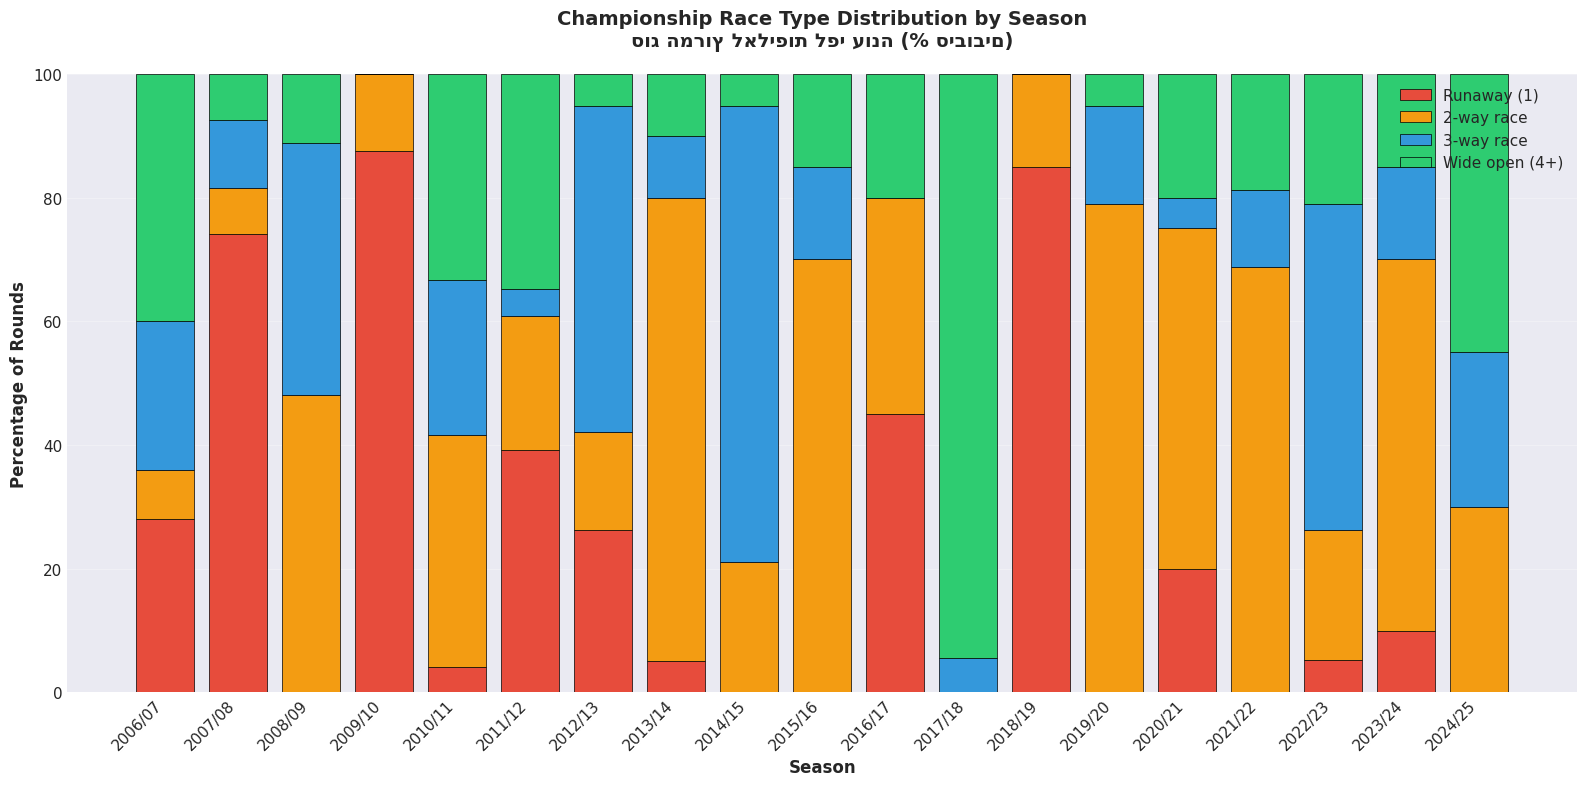

In [94]:
# Visualization 4: Race type stacked bar chart by season
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data for stacked bar chart
race_type_order = ['Runaway (1)', '2-way race', '3-way race', 'Wide open (4+)']
colors_race = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

# Create stacked bar chart
bottom = np.zeros(len(race_type_by_season_pct))

for i, race_type in enumerate(race_type_order):
    if race_type in race_type_by_season_pct.columns:
        values = race_type_by_season_pct[race_type].values
        ax.bar(range(len(race_type_by_season_pct)), values, bottom=bottom, 
               label=race_type, color=colors_race[i], edgecolor='black', linewidth=0.5)
        bottom += values

ax.set_xticks(range(len(race_type_by_season_pct)))
ax.set_xticklabels(race_type_by_season_pct.index, rotation=45, ha='right')
ax.set_ylabel('Percentage of Rounds', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Championship Race Type Distribution by Season\nסוג המרוץ לאליפות לפי עונה (% סיבובים)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'race_type_by_season_stacked.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

### 9.1 Leadership Stability Score - יציבות המקום הראשון
**מדד יציבות:** `stability_score = max_rounds_led / total_rounds`

- **יציבות גבוהה (>0.7)** → עונה נשלטה על ידי קבוצה אחת (תחרות חלשה)
- **יציבות בינונית (0.4-0.7)** → תחרות מאוזנת
- **יציבות נמוכה (<0.4)** → תחרות חזקה מאוד

In [95]:
print("\n" + "="*80)
print("📊 LEADERSHIP STABILITY ANALYSIS")
print("="*80)
print()

# Calculate stability score for each season
# Stability = (max rounds led by one team) / (total rounds)
# High stability = one team dominated, Low stability = competitive race

stability_data = []

for season in sorted(per_round_df['season'].unique()):
    season_data = per_round_df[per_round_df['season'] == season]
    total_rounds = len(season_data)
    
    # Count rounds led by each team
    leader_counts = season_data['leader'].value_counts()
    max_rounds_led = leader_counts.max()
    dominant_team = leader_counts.idxmax()
    
    # Calculate stability score
    stability_score = max_rounds_led / total_rounds
    
    stability_data.append({
        'season': season,
        'total_rounds': total_rounds,
        'dominant_team': dominant_team,
        'rounds_led': max_rounds_led,
        'stability_score': round(stability_score, 3)
    })

stability_df = pd.DataFrame(stability_data)

# Classify stability
def classify_stability(score):
    if score >= 0.7:
        return 'High (Weak Competition)'
    elif score >= 0.4:
        return 'Medium (Balanced)'
    else:
        return 'Low (Strong Competition)'

stability_df['classification'] = stability_df['stability_score'].apply(classify_stability)

print("📋 Leadership Stability by Season:")
print()
display(stability_df)
print()

print("="*80)
print("📈 STABILITY STATISTICS")
print("="*80)
print()
print(f"Average stability score: {stability_df['stability_score'].mean():.3f}")
print(f"Median stability score: {stability_df['stability_score'].median():.3f}")
print(f"Min stability (most competitive): {stability_df['stability_score'].min():.3f}")
print(f"Max stability (least competitive): {stability_df['stability_score'].max():.3f}")
print()

# Distribution of stability classifications
print("📊 Stability Classification Distribution:")
print()
for classification, count in stability_df['classification'].value_counts().items():
    pct = (count / len(stability_df)) * 100
    print(f"  {classification:30s}: {count:2d} seasons ({pct:5.1f}%)")
print()

# Most stable seasons (dominated by one team)
print("🏆 Most Stable Seasons (One Team Dominated):")
display(stability_df.nlargest(5, 'stability_score')[['season', 'dominant_team', 'rounds_led', 'total_rounds', 'stability_score']])
print()

# Least stable seasons (highly competitive)
print("⚔️ Least Stable Seasons (Highly Competitive):")
display(stability_df.nsmallest(5, 'stability_score')[['season', 'dominant_team', 'rounds_led', 'total_rounds', 'stability_score']])
print()


📊 LEADERSHIP STABILITY ANALYSIS

📋 Leadership Stability by Season:



,season,total_rounds,dominant_team,rounds_led,stability_score,classification
0,2006/07,33,B. Jerusalem,29,0.879,High (Weak Competition)
1,2007/08,33,B. Jerusalem,33,1.000,High (Weak Competition)
2,2008/09,33,Maccabi Haifa,26,0.788,High (Weak Competition)
3,2009/10,30,Maccabi Haifa,28,0.933,High (Weak Competition)
4,2010/11,30,Maccabi Haifa,16,0.533,Medium (Balanced)
5,2011/12,30,Kiryat Shmona,19,0.633,Medium (Balanced)
6,2012/13,26,M. Tel Aviv,17,0.654,Medium (Balanced)
7,2013/14,26,M. Tel Aviv,24,0.923,High (Weak Competition)
8,2014/15,26,Kiryat Shmona,16,0.615,Medium (Balanced)
9,2015/16,26,H. Beer Sheva,15,0.577,Medium (Balanced)



📈 STABILITY STATISTICS

Average stability score: 0.733
Median stability score: 0.769
Min stability (most competitive): 0.385
Max stability (least competitive): 1.000

📊 Stability Classification Distribution:

  High (Weak Competition)       : 11 seasons ( 57.9%)
  Medium (Balanced)             :  7 seasons ( 36.8%)
  Low (Strong Competition)      :  1 seasons (  5.3%)

🏆 Most Stable Seasons (One Team Dominated):


,season,dominant_team,rounds_led,total_rounds,stability_score
1,2007/08,B. Jerusalem,33,33,1.000
17,2023/24,M. Tel Aviv,25,26,0.962
3,2009/10,Maccabi Haifa,28,30,0.933
7,2013/14,M. Tel Aviv,24,26,0.923
0,2006/07,B. Jerusalem,29,33,0.879



⚔️ Least Stable Seasons (Highly Competitive):


,season,dominant_team,rounds_led,total_rounds,stability_score
11,2017/18,H. Beer Sheva,10,26,0.385
15,2021/22,H. Beer Sheva,12,26,0.462
4,2010/11,Maccabi Haifa,16,30,0.533
9,2015/16,H. Beer Sheva,15,26,0.577
18,2024/25,H. Beer Sheva,15,26,0.577


💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_stability_score.png


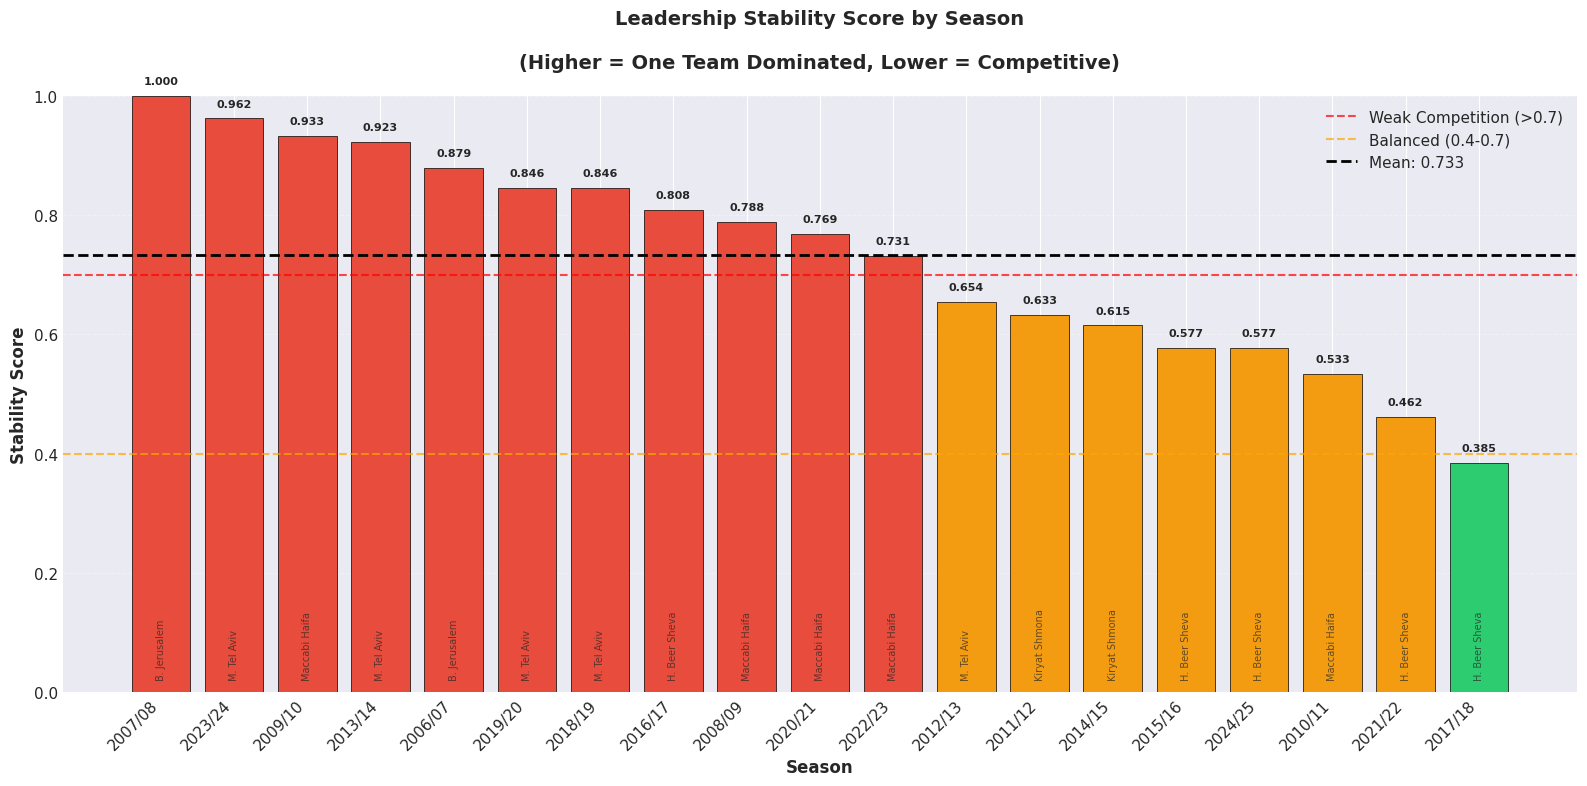

In [109]:
# Visualization 1: Stability score bar chart
fig, ax = plt.subplots(figsize=(16, 8))

# Sort by stability score
stability_sorted = stability_df.sort_values('stability_score', ascending=False)

# Color code based on classification
colors = []
for score in stability_sorted['stability_score']:
    if score >= 0.7:
        colors.append('#e74c3c')  # Red - weak competition
    elif score >= 0.4:
        colors.append('#f39c12')  # Orange - balanced
    else:
        colors.append('#2ecc71')  # Green - strong competition

bars = ax.bar(range(len(stability_sorted)), stability_sorted['stability_score'],
              color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(len(stability_sorted)))
ax.set_xticklabels(stability_sorted['season'], rotation=45, ha='right')
ax.set_ylabel('Stability Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Leadership Stability Score by Season\n\n(Higher = One Team Dominated, Lower = Competitive)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add threshold lines
ax.axhline(0.7, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Weak Competition (>0.7)')
ax.axhline(0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Balanced (0.4-0.7)')

# Add mean line
mean_stability = stability_sorted['stability_score'].mean()
ax.axhline(mean_stability, color='black', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_stability:.3f}')
ax.legend(fontsize=11, loc='upper right')

# Add value labels on bars
for i, (idx, row) in enumerate(stability_sorted.iterrows()):
    ax.text(i, row['stability_score'] + 0.02, f"{row['stability_score']:.3f}", 
            ha='center', fontsize=8, fontweight='bold')
    # Add team name below bar
    ax.text(i, 0.02, row['dominant_team'], 
            ha='center', fontsize=7, rotation=90, va='bottom', alpha=0.7)

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_stability_score.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\stability_correlations.png


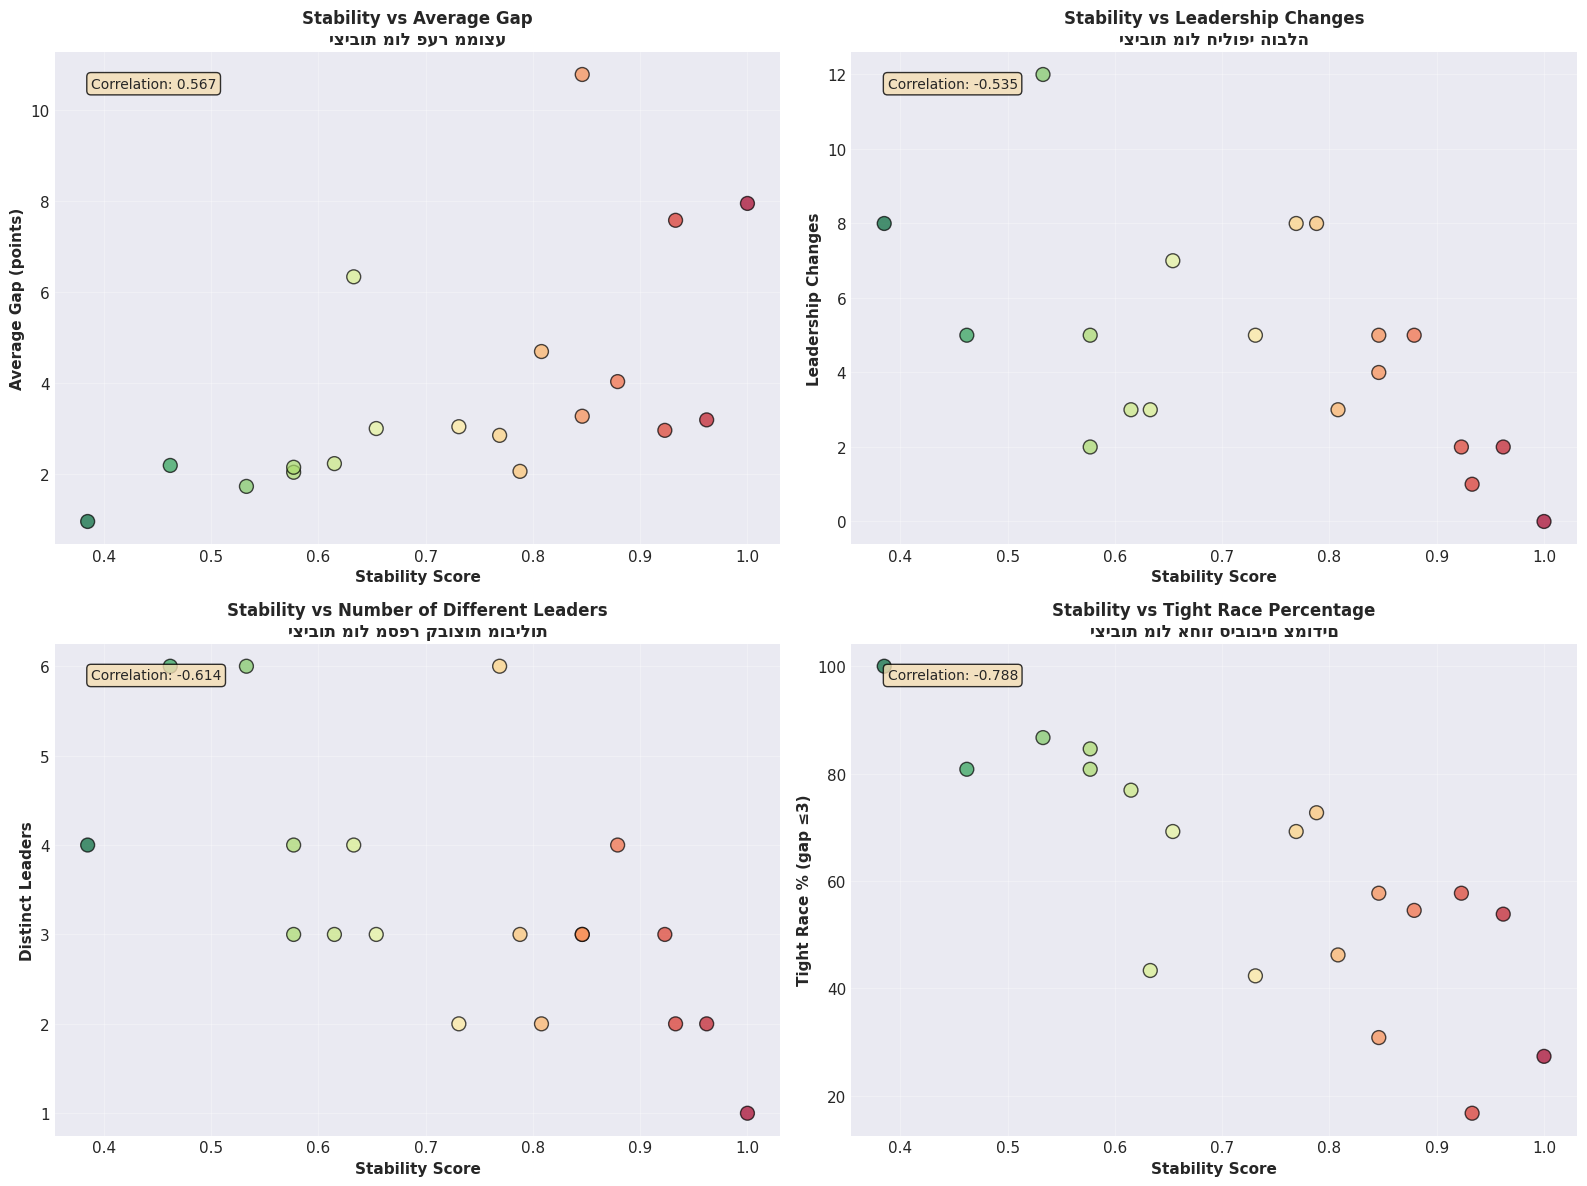


🔍 KEY CORRELATIONS

Stability vs Average Gap:        +0.567  (Moderate)
Stability vs Leadership Changes: -0.535  (Moderate)
Stability vs Distinct Leaders:   -0.614  (Moderate)
Stability vs Tight Race %:       -0.788  (Strong negative)



In [97]:
# Visualization 2: Correlation between stability and other metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Merge stability with summary_df
merged_df = stability_df.merge(summary_df[['season', 'avg_gap', 'leadership_changes', 'distinct_leaders', 'tight_pct']], 
                                on='season')

# 1. Stability vs Average Gap
scatter1 = ax1.scatter(merged_df['stability_score'], merged_df['avg_gap'], 
                       s=100, c=merged_df['stability_score'], cmap='RdYlGn_r',
                       alpha=0.7, edgecolors='black', linewidth=1)
ax1.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Gap (points)', fontsize=11, fontweight='bold')
ax1.set_title('Stability vs Average Gap\nיציבות מול פער ממוצע', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add correlation coefficient
corr1 = merged_df['stability_score'].corr(merged_df['avg_gap'])
ax1.text(0.05, 0.95, f'Correlation: {corr1:.3f}', transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Stability vs Leadership Changes
scatter2 = ax2.scatter(merged_df['stability_score'], merged_df['leadership_changes'], 
                       s=100, c=merged_df['stability_score'], cmap='RdYlGn_r',
                       alpha=0.7, edgecolors='black', linewidth=1)
ax2.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Leadership Changes', fontsize=11, fontweight='bold')
ax2.set_title('Stability vs Leadership Changes\nיציבות מול חילופי הובלה', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

corr2 = merged_df['stability_score'].corr(merged_df['leadership_changes'])
ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}', transform=ax2.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Stability vs Distinct Leaders
scatter3 = ax3.scatter(merged_df['stability_score'], merged_df['distinct_leaders'], 
                       s=100, c=merged_df['stability_score'], cmap='RdYlGn_r',
                       alpha=0.7, edgecolors='black', linewidth=1)
ax3.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Distinct Leaders', fontsize=11, fontweight='bold')
ax3.set_title('Stability vs Number of Different Leaders\nיציבות מול מספר קבוצות מובילות', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

corr3 = merged_df['stability_score'].corr(merged_df['distinct_leaders'])
ax3.text(0.05, 0.95, f'Correlation: {corr3:.3f}', transform=ax3.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. Stability vs Tight Race %
scatter4 = ax4.scatter(merged_df['stability_score'], merged_df['tight_pct'], 
                       s=100, c=merged_df['stability_score'], cmap='RdYlGn_r',
                       alpha=0.7, edgecolors='black', linewidth=1)
ax4.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
ax4.set_ylabel('Tight Race % (gap ≤3)', fontsize=11, fontweight='bold')
ax4.set_title('Stability vs Tight Race Percentage\nיציבות מול אחוז סיבובים צמודים', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

corr4 = merged_df['stability_score'].corr(merged_df['tight_pct'])
ax4.text(0.05, 0.95, f'Correlation: {corr4:.3f}', transform=ax4.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
fig_path = FIG_DIR / 'stability_correlations.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

print("\n" + "="*80)
print("🔍 KEY CORRELATIONS")
print("="*80)
print()
print(f"Stability vs Average Gap:        {corr1:+.3f}  {'(Strong positive)' if abs(corr1) > 0.7 else '(Moderate)' if abs(corr1) > 0.4 else '(Weak)'}")
print(f"Stability vs Leadership Changes: {corr2:+.3f}  {'(Strong negative)' if abs(corr2) > 0.7 else '(Moderate)' if abs(corr2) > 0.4 else '(Weak)'}")
print(f"Stability vs Distinct Leaders:   {corr3:+.3f}  {'(Strong negative)' if abs(corr3) > 0.7 else '(Moderate)' if abs(corr3) > 0.4 else '(Weak)'}")
print(f"Stability vs Tight Race %:       {corr4:+.3f}  {'(Strong negative)' if abs(corr4) > 0.7 else '(Moderate)' if abs(corr4) > 0.4 else '(Weak)'}")
print()

## 10. League Structure Analysis - השפעת מבנה הליגה על התחרותיות

**מטרה:** לבדוק איך מספר הקבוצות ופורמט הפלייאוף משפיעים על רמת התחרות

**תקופות שונות:**
- **2006/07-2008/09:** 12 קבוצות, 33 מחזורים (ללא פלייאוף)
- **2009/10-2011/12:** 16 קבוצות, 30 מחזורים (פלייאוף עם קיזוז נקודות)
- **2012/13-2024/25:** 14 קבוצות, 26 מחזורים (פלייאוף עם נקודות מלאות)

In [98]:
print("="*80)
print("🏟️ LEAGUE STRUCTURE ANALYSIS")
print("="*80)
print()

# Define league structure periods
def classify_league_structure(season):
    """Classify season by number of teams and playoff format"""
    if season in ['2006/07', '2007/08', '2008/09']:
        return '12 teams (No Playoff)', 12, 'No Playoff'
    elif season in ['2009/10', '2010/11', '2011/12']:
        return '16 teams (Playoff w/ Reduction)', 16, 'Playoff Split Points'
    else:  # 2012/13 onwards
        return '14 teams (Playoff Full Points)', 14, 'Playoff Full Points'

# Add structure classification to summary_df
summary_df['structure'] = summary_df['season'].apply(lambda s: classify_league_structure(s)[0])
summary_df['num_teams'] = summary_df['season'].apply(lambda s: classify_league_structure(s)[1])
summary_df['playoff_format'] = summary_df['season'].apply(lambda s: classify_league_structure(s)[2])

# Also add to stability_df
stability_df['structure'] = stability_df['season'].apply(lambda s: classify_league_structure(s)[0])
stability_df['num_teams'] = stability_df['season'].apply(lambda s: classify_league_structure(s)[1])
stability_df['playoff_format'] = stability_df['season'].apply(lambda s: classify_league_structure(s)[2])

print("📋 League Structure Classification:")
print()
structure_counts = summary_df['structure'].value_counts().sort_index()
for structure, count in structure_counts.items():
    print(f"  {structure:35s}: {count} seasons")
print()

# Calculate average metrics by structure
print("="*80)
print("📊 COMPETITIVENESS BY LEAGUE STRUCTURE")
print("="*80)
print()

structure_metrics = summary_df.groupby('structure').agg({
    'avg_gap': 'mean',
    'leadership_changes': 'mean',
    'distinct_leaders': 'mean',
    'tight_pct': 'mean',
    'rounds': 'first'
}).round(2)

# Add stability score
stability_by_structure = stability_df.groupby('structure')['stability_score'].mean().round(3)
structure_metrics['stability_score'] = stability_by_structure

structure_metrics.columns = ['Avg Gap', 'Leadership Changes', 'Distinct Leaders', 'Tight %', 'Rounds', 'Stability']

print("Average metrics by league structure:")
print()
display(structure_metrics)
print()

# Statistical comparison
print("="*80)
print("🔍 KEY FINDINGS")
print("="*80)
print()

metrics_12 = structure_metrics.loc['12 teams (No Playoff)']
metrics_14 = structure_metrics.loc['14 teams (Playoff Full Points)']
metrics_16 = structure_metrics.loc['16 teams (Playoff w/ Reduction)']

print("1️⃣ AVERAGE GAP (Lower = More Competitive):")
print(f"   12 teams: {metrics_12['Avg Gap']:.2f} points")
print(f"   14 teams: {metrics_14['Avg Gap']:.2f} points")
print(f"   16 teams: {metrics_16['Avg Gap']:.2f} points")
print()

print("2️⃣ LEADERSHIP CHANGES (Higher = More Dynamic):")
print(f"   12 teams: {metrics_12['Leadership Changes']:.1f} changes")
print(f"   14 teams: {metrics_14['Leadership Changes']:.1f} changes")
print(f"   16 teams: {metrics_16['Leadership Changes']:.1f} changes")
print()

print("3️⃣ DISTINCT LEADERS (Higher = More Teams in Race):")
print(f"   12 teams: {metrics_12['Distinct Leaders']:.1f} teams")
print(f"   14 teams: {metrics_14['Distinct Leaders']:.1f} teams")
print(f"   16 teams: {metrics_16['Distinct Leaders']:.1f} teams")
print()

print("4️⃣ TIGHT RACE % (Higher = More Competitive):")
print(f"   12 teams: {metrics_12['Tight %']:.1f}%")
print(f"   14 teams: {metrics_14['Tight %']:.1f}%")
print(f"   16 teams: {metrics_16['Tight %']:.1f}%")
print()

print("5️⃣ STABILITY SCORE (Lower = More Competitive):")
print(f"   12 teams: {metrics_12['Stability']:.3f}")
print(f"   14 teams: {metrics_14['Stability']:.3f}")
print(f"   16 teams: {metrics_16['Stability']:.3f}")
print()

print("="*80)
print("💡 INTERPRETATIONS")
print("="*80)
print()

# Comparisons
if metrics_16['Leadership Changes'] < metrics_12['Leadership Changes']:
    print("✅ 16 teams → FEWER leadership changes than 12 teams")
    print("   (Larger league = less competitive title race)")
else:
    print("❌ 16 teams → MORE leadership changes than 12 teams")

print()

if metrics_12['Tight %'] > metrics_14['Tight %']:
    print("✅ 12 teams → MORE tight races than 14 teams")
    print("   (Smaller league = closer competition)")
else:
    print("❌ 12 teams → LESS tight races than 14 teams")

print()

if metrics_16['Stability'] > metrics_14['Stability']:
    print("✅ 16 teams → HIGHER stability than 14 teams")
    print("   (Larger league = one team dominates more)")
else:
    print("❌ 16 teams → LOWER stability than 14 teams")

print()

🏟️ LEAGUE STRUCTURE ANALYSIS

📋 League Structure Classification:

  12 teams (No Playoff)              : 3 seasons
  14 teams (Playoff Full Points)     : 13 seasons
  16 teams (Playoff w/ Reduction)    : 3 seasons

📊 COMPETITIVENESS BY LEAGUE STRUCTURE

Average metrics by league structure:



,Avg Gap,Leadership Changes,Distinct Leaders,Tight %,Rounds,Stability
structure,,,,,,
12 teams (No Playoff),4.68,4.33,2.67,51.50,33,0.889
14 teams (Playoff Full Points),3.33,4.54,3.38,65.38,26,0.704
16 teams (Playoff w/ Reduction),5.21,5.33,4.00,48.90,30,0.700



🔍 KEY FINDINGS

1️⃣ AVERAGE GAP (Lower = More Competitive):
   12 teams: 4.68 points
   14 teams: 3.33 points
   16 teams: 5.21 points

2️⃣ LEADERSHIP CHANGES (Higher = More Dynamic):
   12 teams: 4.3 changes
   14 teams: 4.5 changes
   16 teams: 5.3 changes

3️⃣ DISTINCT LEADERS (Higher = More Teams in Race):
   12 teams: 2.7 teams
   14 teams: 3.4 teams
   16 teams: 4.0 teams

4️⃣ TIGHT RACE % (Higher = More Competitive):
   12 teams: 51.5%
   14 teams: 65.4%
   16 teams: 48.9%

5️⃣ STABILITY SCORE (Lower = More Competitive):
   12 teams: 0.889
   14 teams: 0.704
   16 teams: 0.700

💡 INTERPRETATIONS

❌ 16 teams → MORE leadership changes than 12 teams

❌ 12 teams → LESS tight races than 14 teams

❌ 16 teams → LOWER stability than 14 teams



💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\league_structure_comparison.png


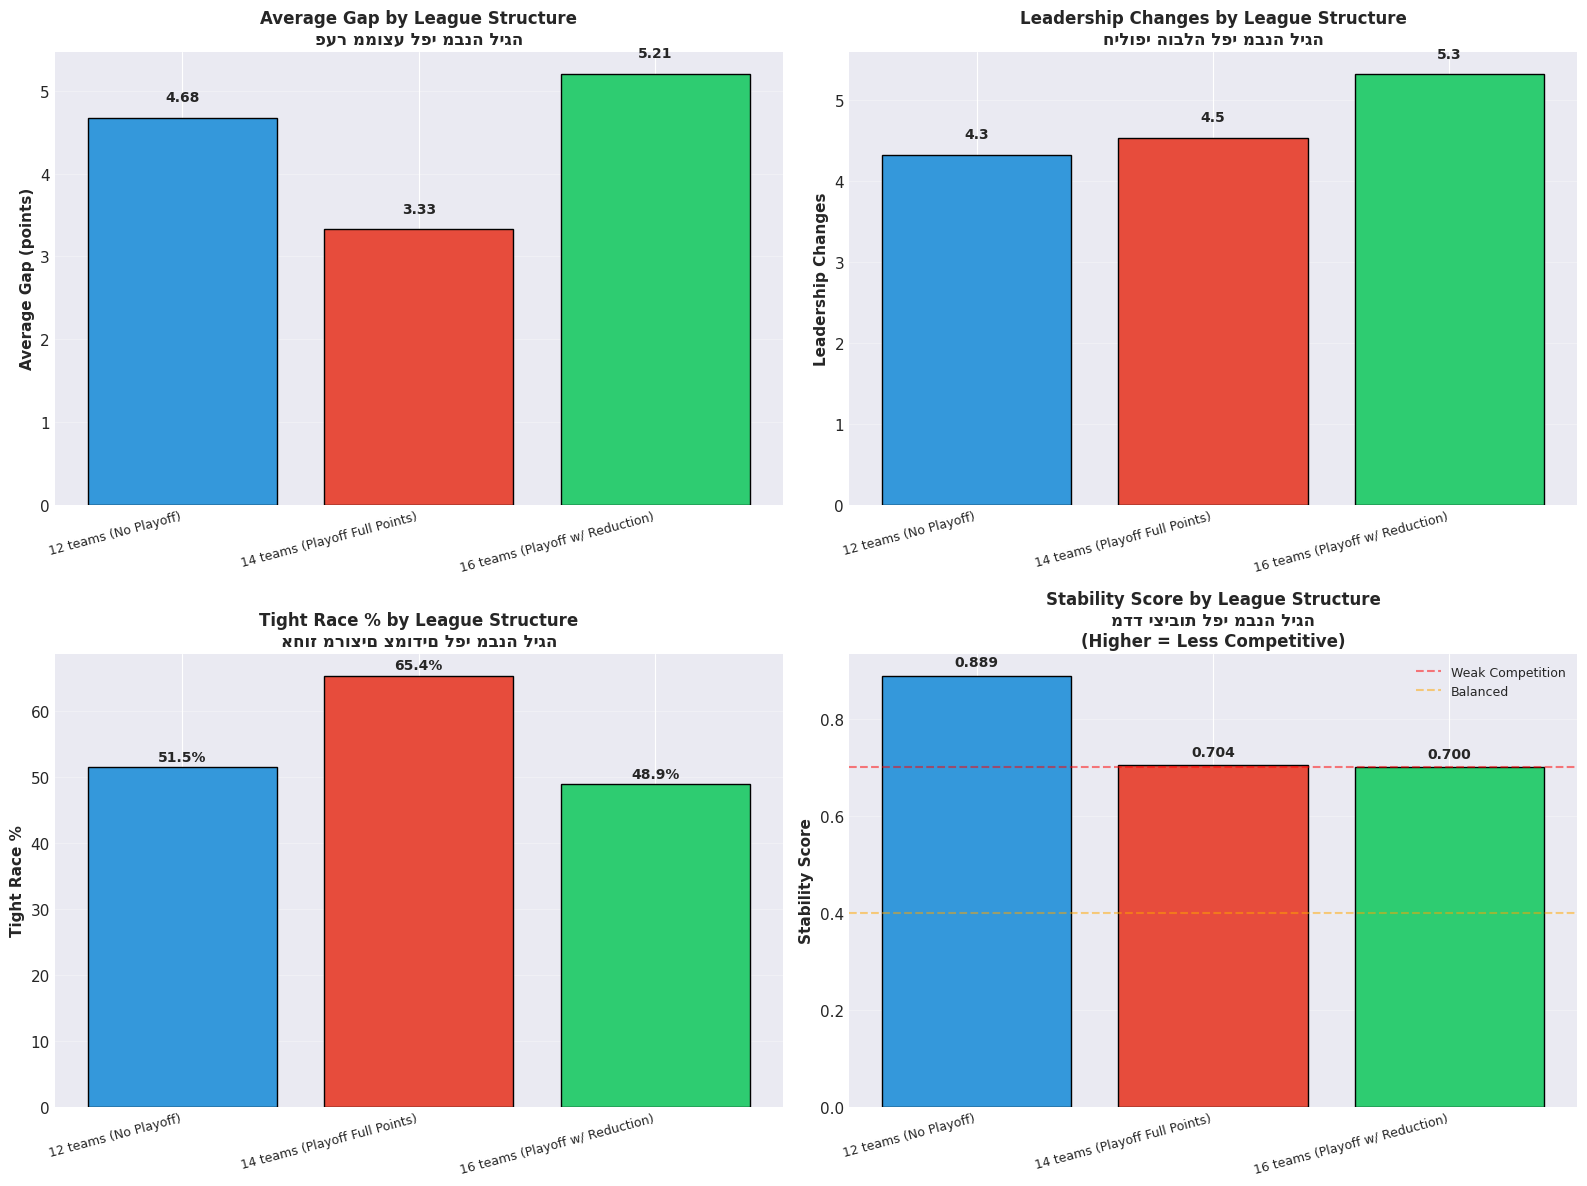

In [99]:
# Visualization 1: Comparison of metrics by league structure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

structures = structure_metrics.index
x_pos = np.arange(len(structures))
colors_struct = ['#3498db', '#e74c3c', '#2ecc71']

# 1. Average Gap
bars1 = ax1.bar(x_pos, structure_metrics['Avg Gap'], color=colors_struct, edgecolor='black', linewidth=1)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(structures, rotation=15, ha='right', fontsize=9)
ax1.set_ylabel('Average Gap (points)', fontsize=11, fontweight='bold')
ax1.set_title('Average Gap by League Structure\nפער ממוצע לפי מבנה ליגה', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.2f}', ha='center', fontsize=10, fontweight='bold')

# 2. Leadership Changes
bars2 = ax2.bar(x_pos, structure_metrics['Leadership Changes'], color=colors_struct, edgecolor='black', linewidth=1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(structures, rotation=15, ha='right', fontsize=9)
ax2.set_ylabel('Leadership Changes', fontsize=11, fontweight='bold')
ax2.set_title('Leadership Changes by League Structure\nחילופי הובלה לפי מבנה ליגה', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}', ha='center', fontsize=10, fontweight='bold')

# 3. Tight Race %
bars3 = ax3.bar(x_pos, structure_metrics['Tight %'], color=colors_struct, edgecolor='black', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(structures, rotation=15, ha='right', fontsize=9)
ax3.set_ylabel('Tight Race %', fontsize=11, fontweight='bold')
ax3.set_title('Tight Race % by League Structure\nאחוז מרוצים צמודים לפי מבנה ליגה', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', fontsize=10, fontweight='bold')

# 4. Stability Score
bars4 = ax4.bar(x_pos, structure_metrics['Stability'], color=colors_struct, edgecolor='black', linewidth=1)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(structures, rotation=15, ha='right', fontsize=9)
ax4.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
ax4.set_title('Stability Score by League Structure\nמדד יציבות לפי מבנה ליגה\n(Higher = Less Competitive)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(0.7, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Weak Competition')
ax4.axhline(0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Balanced')
ax4.legend(fontsize=9)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'league_structure_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\4146961281.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_gap, labels=[s.split('(')[0].strip() for s in structures_order],
C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\4146961281.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_changes, labels=[s.split('(')[0].strip() for s in structures_order],
C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\4146961281.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(data_tight, labels=[s.split('(')[0].strip() for s in structures_order],
C:\Users\niti

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\league_structure_distributions.png


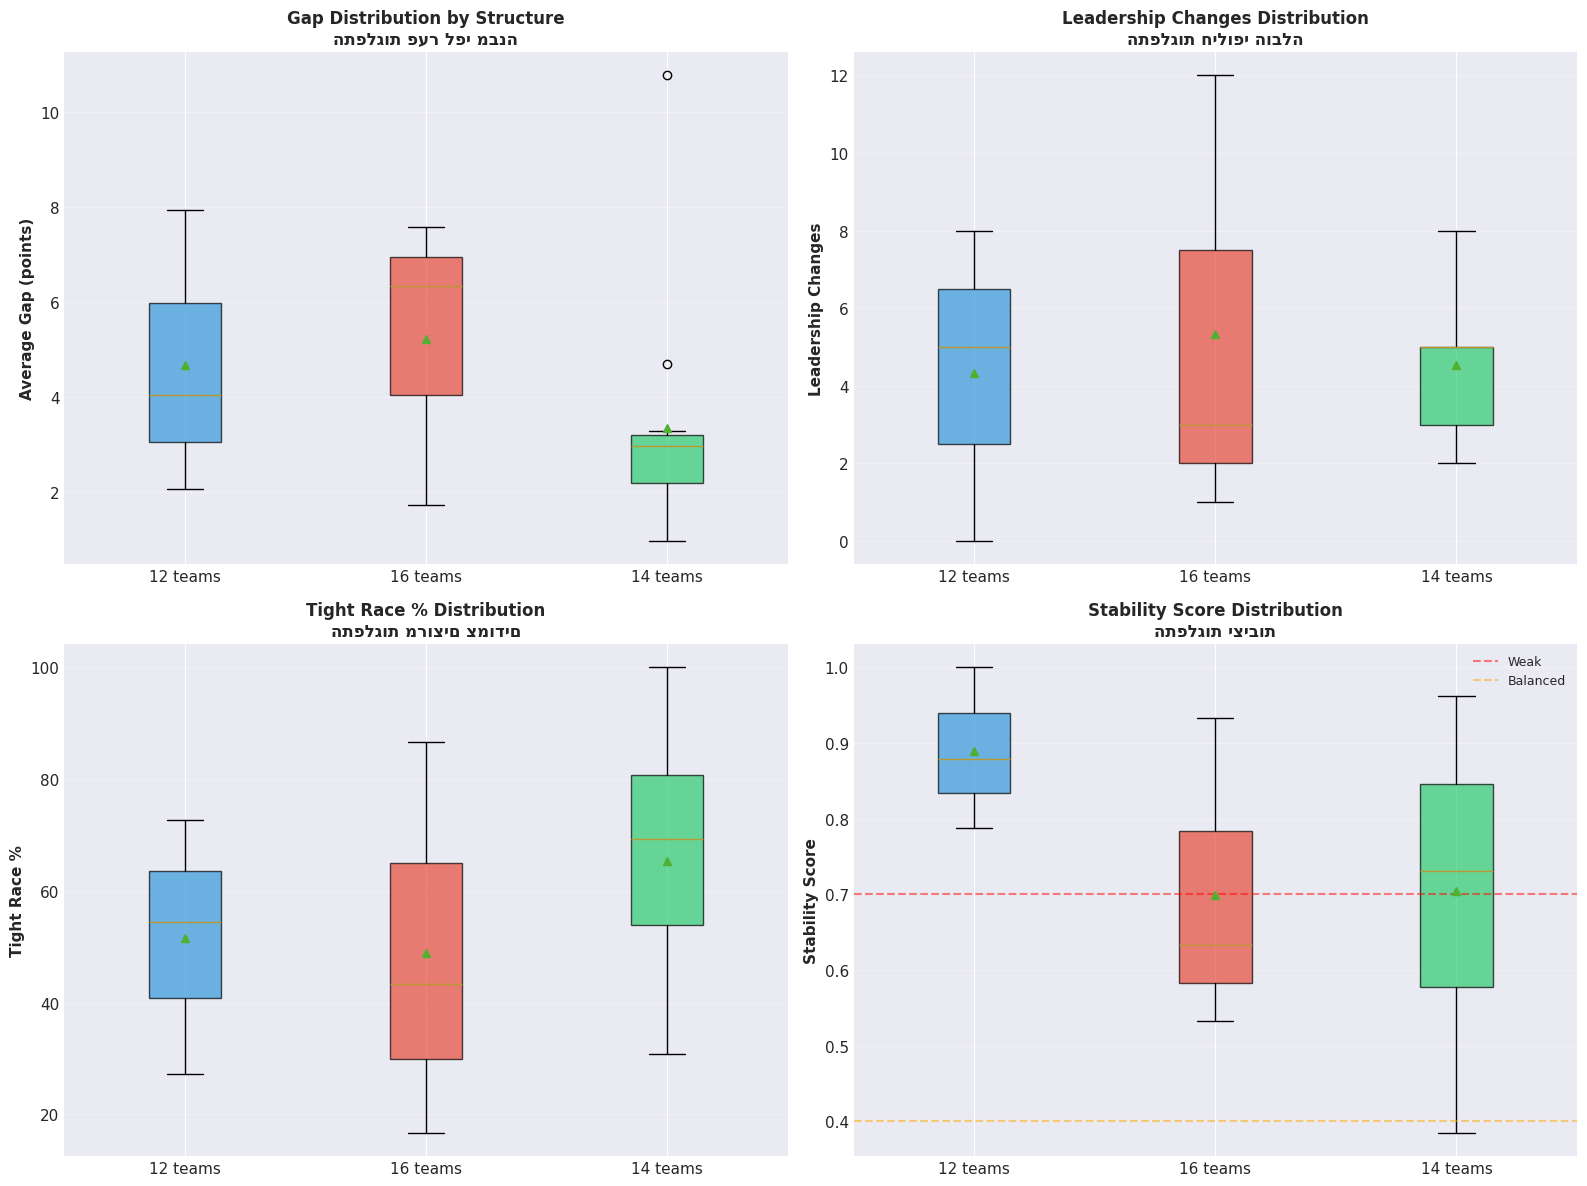

In [100]:
# Visualization 2: Box plots showing distribution within each structure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for box plots
structures_order = ['12 teams (No Playoff)', '16 teams (Playoff w/ Reduction)', '14 teams (Playoff Full Points)']

# 1. Average Gap distribution
ax1 = axes[0, 0]
data_gap = [summary_df[summary_df['structure'] == s]['avg_gap'].values for s in structures_order]
bp1 = ax1.boxplot(data_gap, labels=[s.split('(')[0].strip() for s in structures_order], 
                   patch_artist=True, showmeans=True)
for patch, color in zip(bp1['boxes'], colors_struct):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Average Gap (points)', fontsize=11, fontweight='bold')
ax1.set_title('Gap Distribution by Structure\nהתפלגות פער לפי מבנה', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Leadership Changes distribution
ax2 = axes[0, 1]
data_changes = [summary_df[summary_df['structure'] == s]['leadership_changes'].values for s in structures_order]
bp2 = ax2.boxplot(data_changes, labels=[s.split('(')[0].strip() for s in structures_order], 
                   patch_artist=True, showmeans=True)
for patch, color in zip(bp2['boxes'], colors_struct):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Leadership Changes', fontsize=11, fontweight='bold')
ax2.set_title('Leadership Changes Distribution\nהתפלגות חילופי הובלה', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Tight % distribution
ax3 = axes[1, 0]
data_tight = [summary_df[summary_df['structure'] == s]['tight_pct'].values for s in structures_order]
bp3 = ax3.boxplot(data_tight, labels=[s.split('(')[0].strip() for s in structures_order], 
                   patch_artist=True, showmeans=True)
for patch, color in zip(bp3['boxes'], colors_struct):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('Tight Race %', fontsize=11, fontweight='bold')
ax3.set_title('Tight Race % Distribution\nהתפלגות מרוצים צמודים', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Stability distribution
ax4 = axes[1, 1]
data_stability = [stability_df[stability_df['structure'] == s]['stability_score'].values for s in structures_order]
bp4 = ax4.boxplot(data_stability, labels=[s.split('(')[0].strip() for s in structures_order], 
                   patch_artist=True, showmeans=True)
for patch, color in zip(bp4['boxes'], colors_struct):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
ax4.set_title('Stability Score Distribution\nהתפלגות יציבות', fontsize=12, fontweight='bold')
ax4.axhline(0.7, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Weak')
ax4.axhline(0.4, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Balanced')
ax4.legend(fontsize=9, loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'league_structure_distributions.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

## 7. Combined Analysis - Regular Season + Playoffs
### ניתוח משולב - עונה רגילה + פלייאוף

## 6. Playoff Analysis
### ניתוח פלייאוף - חישוב ידני עם העברת נקודות נכונה

**פורמטים שונים של הפלייאוף:**
- 2009/10-2011/12: פלייאוף עם קיזוז (חלק/חצי נקודות)
- 2012/13-2024/25: פלייאוף עם העברת נקודות מלאות

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\gap_over_time_sample_seasons.png


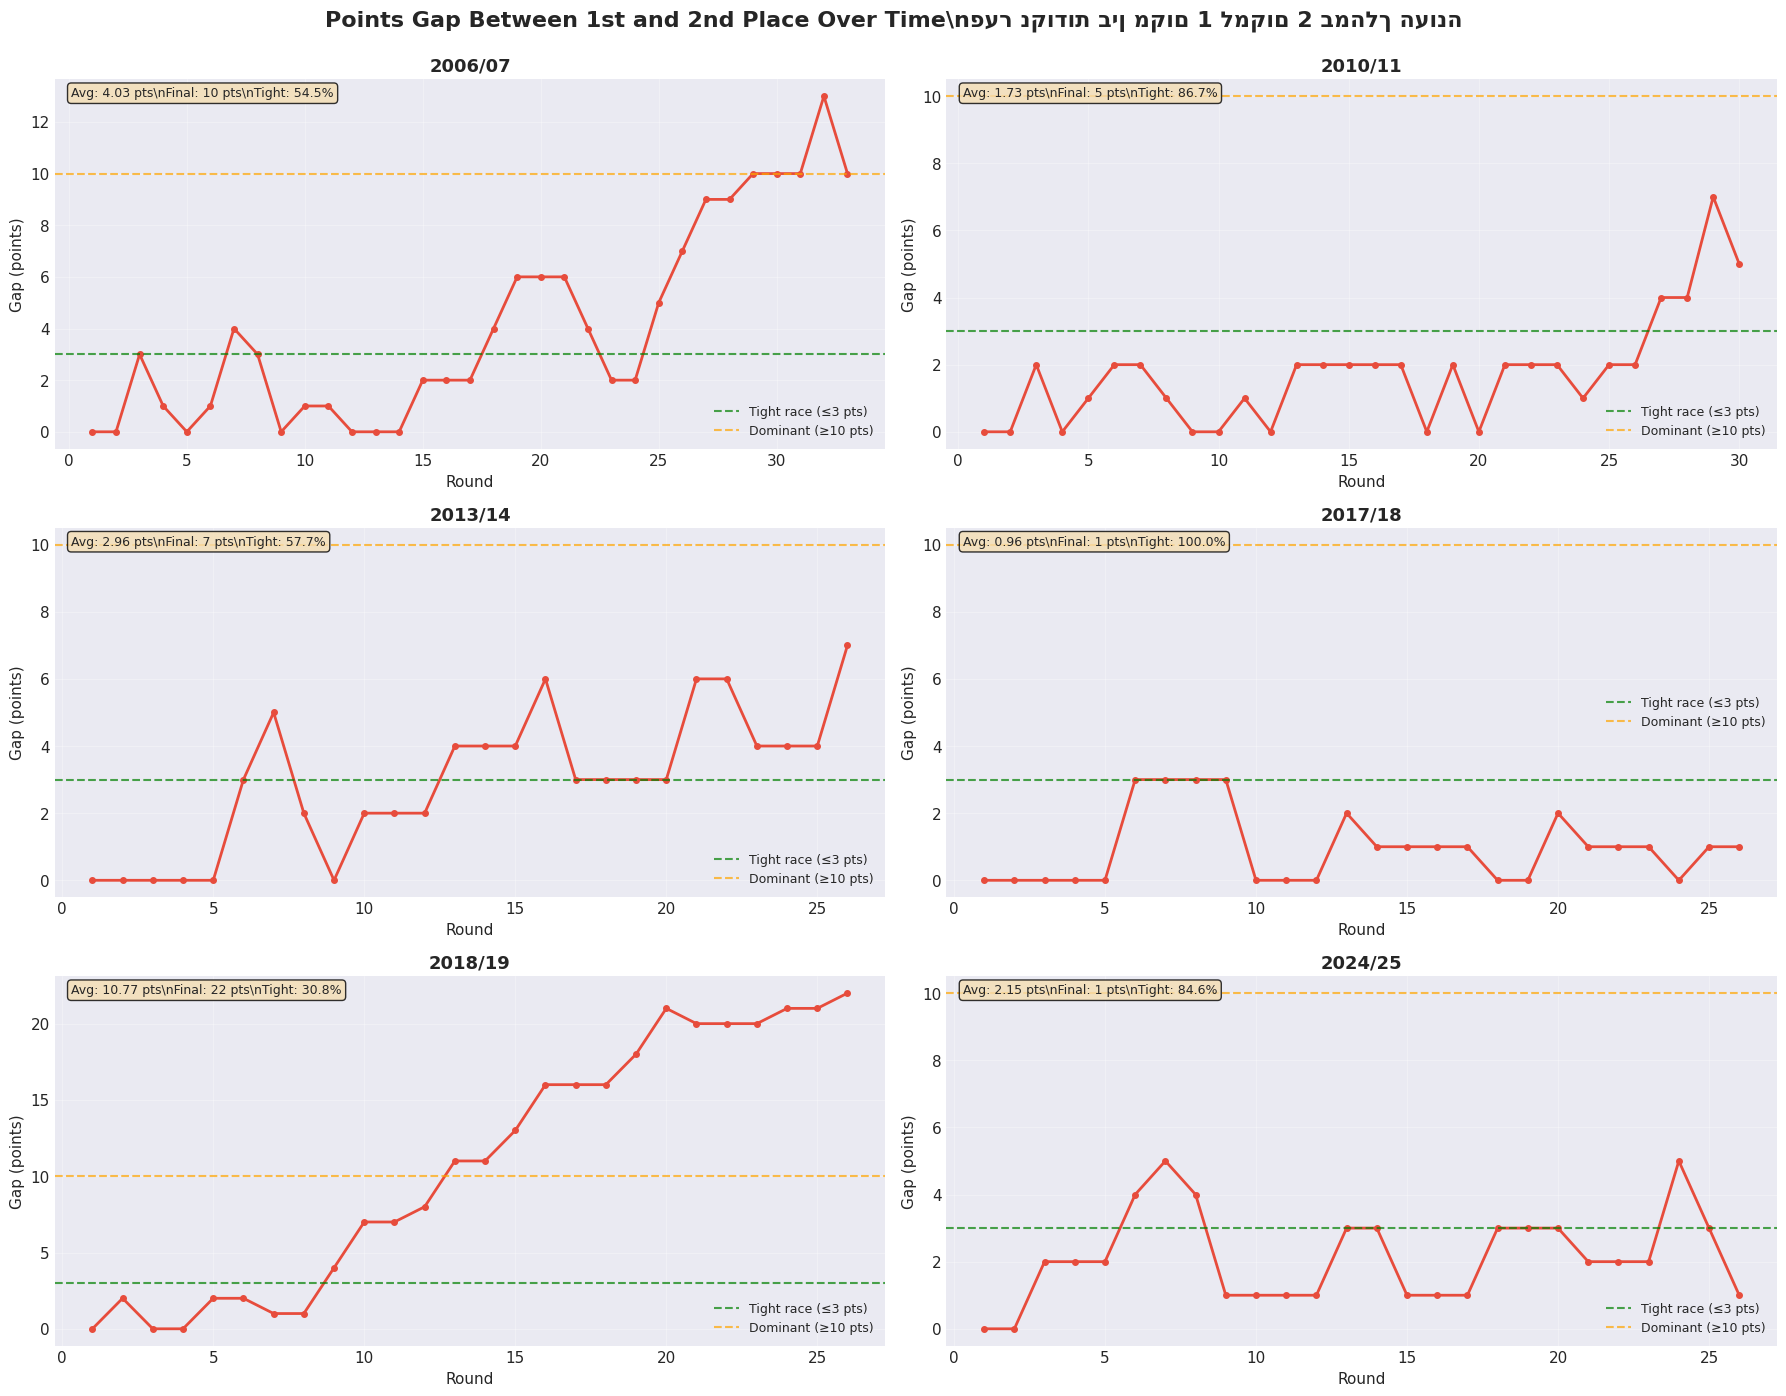

In [101]:
# Visualization 1: Gap over time for each season (sample of seasons)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

# Select 6 interesting seasons to display
interesting_seasons = [
    '2006/07',  # Early season
    '2010/11',  # Competitive (avg gap 1.73)
    '2013/14',  # Mid-period
    '2017/18',  # Most competitive (avg gap 0.96)
    '2018/19',  # Least competitive (avg gap 10.77)
    '2024/25'   # Latest season
]

for idx, season in enumerate(interesting_seasons):
    ax = axes[idx]
    season_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
    
    # Plot gap over rounds
    ax.plot(season_data['round'], season_data['gap'], 
            marker='o', linewidth=2, markersize=4, color='#e74c3c')
    
    # Add horizontal line at gap=3 (tight race threshold)
    ax.axhline(3, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Tight race (≤3 pts)')
    
    # Add horizontal line at gap=10 (dominant leader threshold)
    ax.axhline(10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Dominant (≥10 pts)')
    
    # Styling
    ax.set_title(f'{season}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Gap (points)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # Add statistics text
    avg_gap = stats_df[stats_df['season'] == season]['avg_gap'].values[0]
    final_gap = stats_df[stats_df['season'] == season]['final_gap'].values[0]
    tight_pct = stats_df[stats_df['season'] == season]['tight_pct'].values[0]
    
    text_str = f'Avg: {avg_gap:.2f} pts\\nFinal: {final_gap} pts\\nTight: {tight_pct:.1f}%'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Points Gap Between 1st and 2nd Place Over Time\\nפער נקודות בין מקום 1 למקום 2 במהלך העונה', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

fig_path = FIG_DIR / 'gap_over_time_sample_seasons.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

## 8. Export All Data Tables to CSV
### שמירת כל הטבלאות לקבצי CSV לשימוש עתידי

In [102]:
# Create dedicated directory for processed title race data
PROCESSED_DIR = DATA_DIR / 'processed' / 'title_race_analysis'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("💾 EXPORTING ALL DATA TABLES TO CSV")
print("="*80)
print()
print(f"📁 Output directory: {PROCESSED_DIR}")
print()

saved_files = []

# 1. Per-round data (all seasons, all rounds)
if 'per_round_df' in locals() and per_round_df is not None:
    file_path = PROCESSED_DIR / 'per_round_gaps_all_seasons.csv'
    per_round_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Per-round gaps', file_path, len(per_round_df)))
    print(f"✅ per_round_gaps_all_seasons.csv - {len(per_round_df)} rows")

# 2. Summary statistics per season
if 'summary_df' in locals() and summary_df is not None:
    file_path = PROCESSED_DIR / 'season_summary_statistics.csv'
    summary_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Season summary', file_path, len(summary_df)))
    print(f"✅ season_summary_statistics.csv - {len(summary_df)} seasons")

# 3. Rounds led by each team per season
if 'rounds_led' in locals() and rounds_led is not None:
    file_path = PROCESSED_DIR / 'rounds_led_by_team_per_season.csv'
    rounds_led.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Rounds led by team', file_path, len(rounds_led)))
    print(f"✅ rounds_led_by_team_per_season.csv - {len(rounds_led)} rows")

# 4. Total rounds led by each team (aggregated)
if 'total_rounds_led' in locals() and total_rounds_led is not None:
    file_path = PROCESSED_DIR / 'total_rounds_led_by_team.csv'
    total_rounds_led.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Total rounds led', file_path, len(total_rounds_led)))
    print(f"✅ total_rounds_led_by_team.csv - {len(total_rounds_led)} teams")

# 5. Combined metrics (leadership changes, distinct leaders, etc.)
if 'combined_metrics' in locals() and combined_metrics is not None:
    file_path = PROCESSED_DIR / 'season_competitiveness_metrics.csv'
    combined_metrics.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Competitiveness metrics', file_path, len(combined_metrics)))
    print(f"✅ season_competitiveness_metrics.csv - {len(combined_metrics)} seasons")

# 6. Leadership change percentages
if 'summary_with_pct' in locals() and summary_with_pct is not None:
    file_path = PROCESSED_DIR / 'leadership_change_percentages.csv'
    summary_with_pct.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Change percentages', file_path, len(summary_with_pct)))
    print(f"✅ leadership_change_percentages.csv - {len(summary_with_pct)} seasons")

# 7. Playoff gaps (all seasons with playoffs)
if 'all_playoff_gaps_df' in locals() and all_playoff_gaps_df is not None:
    file_path = PROCESSED_DIR / 'playoff_gaps_all_seasons.csv'
    all_playoff_gaps_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Playoff gaps', file_path, len(all_playoff_gaps_df)))
    print(f"✅ playoff_gaps_all_seasons.csv - {len(all_playoff_gaps_df)} rounds")

# 8. Playoff summary (leadership changes in playoffs)
if 'playoff_summary_df' in locals() and playoff_summary_df is not None:
    file_path = PROCESSED_DIR / 'playoff_summary_statistics.csv'
    playoff_summary_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Playoff summary', file_path, len(playoff_summary_df)))
    print(f"✅ playoff_summary_statistics.csv - {len(playoff_summary_df)} seasons")

# 9. Regular season vs Playoff comparison
if 'comparison_df' in locals() and comparison_df is not None:
    file_path = PROCESSED_DIR / 'regular_vs_playoff_comparison.csv'
    comparison_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Regular vs Playoff', file_path, len(comparison_df)))
    print(f"✅ regular_vs_playoff_comparison.csv - {len(comparison_df)} seasons")

# 10. Original scraped data (raw gaps)
if 'all_scraped_gaps_df' in locals() and all_scraped_gaps_df is not None:
    file_path = PROCESSED_DIR / 'raw_scraped_gaps_transfermarkt.csv'
    all_scraped_gaps_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Raw scraped data', file_path, len(all_scraped_gaps_df)))
    print(f"✅ raw_scraped_gaps_transfermarkt.csv - {len(all_scraped_gaps_df)} rows")

print()
print("="*80)
print(f"✅ EXPORT COMPLETED - {len(saved_files)} files saved")
print("="*80)
print()

# Create summary report
print("📊 Summary of exported files:")
print()
total_size = 0
for name, path, rows in saved_files:
    file_size = path.stat().st_size / 1024  # KB
    total_size += file_size
    print(f"  • {name:30s} {rows:5d} rows  {file_size:7.1f} KB")

print()
print(f"📦 Total size: {total_size:.1f} KB")
print()
print(f"📁 All files saved to: {PROCESSED_DIR}")

# Create a README file explaining the data
readme_path = PROCESSED_DIR / 'README.md'
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write("# Title Race Analysis - Processed Data\\n\\n")
    f.write("This directory contains processed data from the title race analysis of Israeli Premier League (Ligat Ha'al).\\n\\n")
    f.write("## Data Sources\\n")
    f.write("- **Transfermarkt**: Official match data and standings\\n")
    f.write("- **Analysis Period**: 2006/07 - 2024/25 (19 seasons)\\n\\n")
    f.write("## Files Description\\n\\n")
    f.write("### Core Data\\n")
    f.write("1. **raw_scraped_gaps_transfermarkt.csv** - Raw data scraped from Transfermarkt\\n")
    f.write("   - Round-by-round points gap between 1st and 2nd place\\n")
    f.write("   - Includes: season, round, leader, second place, points, gap\\n\\n")
    f.write("2. **per_round_gaps_all_seasons.csv** - Same as raw data (for compatibility)\\n\\n")
    f.write("### Season Statistics\\n")
    f.write("3. **season_summary_statistics.csv** - Summary statistics per season\\n")
    f.write("   - Average gap, final gap, min/max gap\\n")
    f.write("   - Tight rounds count and percentage\\n")
    f.write("   - Leadership changes, distinct leaders\\n\\n")
    f.write("### Leadership Analysis\\n")
    f.write("4. **rounds_led_by_team_per_season.csv** - How many rounds each team led per season\\n")
    f.write("5. **total_rounds_led_by_team.csv** - Total rounds led by each team (all seasons)\\n")
    f.write("6. **season_competitiveness_metrics.csv** - Leadership stability metrics\\n")
    f.write("7. **leadership_change_percentages.csv** - Frequency of leadership changes\\n\\n")
    f.write("### Playoff Data\\n")
    f.write("8. **playoff_gaps_all_seasons.csv** - Playoff championship round-by-round gaps\\n")
    f.write("9. **playoff_summary_statistics.csv** - Playoff leadership changes\\n")
    f.write("10. **regular_vs_playoff_comparison.csv** - Comparison of regular season vs playoff gaps\\n\\n")
    f.write("## Key Findings\\n")
    f.write("- Most competitive season: 2017/18 (avg gap: 0.96 points)\\n")
    f.write("- Least competitive season: 2018/19 (avg gap: 10.77 points)\\n")
    f.write("- Maccabi Tel Aviv led the most rounds overall: 163 rounds\\n")
    f.write("- Average tight race percentage: 60.6% of rounds with gap ≤2 points\\n\\n")
    f.write("## Notes\\n")
    f.write("- All data uses UTF-8 encoding with BOM for Hebrew compatibility\\n")
    f.write("- Playoff data starts from 2009/10 season\\n")
    f.write("- Point transfer in playoffs:\\n")
    f.write("  - 2009/10-2010/11: Points halved\\n")
    f.write("  - 2011/12 onwards: Full points transferred\\n\\n")
    f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")

print(f"📄 Created README.md with data documentation")
print()
print("🎉 All data exported successfully!")

💾 EXPORTING ALL DATA TABLES TO CSV

📁 Output directory: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\processed\title_race_analysis

✅ per_round_gaps_all_seasons.csv - 527 rows
✅ season_summary_statistics.csv - 19 seasons
✅ rounds_led_by_team_per_season.csv - 64 rows
✅ total_rounds_led_by_team.csv - 17 teams
✅ season_competitiveness_metrics.csv - 19 seasons
✅ leadership_change_percentages.csv - 19 seasons
✅ playoff_gaps_all_seasons.csv - 147 rounds
✅ playoff_summary_statistics.csv - 16 seasons
✅ regular_vs_playoff_comparison.csv - 16 seasons
✅ raw_scraped_gaps_transfermarkt.csv - 527 rows

✅ EXPORT COMPLETED - 10 files saved

📊 Summary of exported files:

  • Per-round gaps                   527 rows     24.0 KB
  • Season summary                    19 rows      2.7 KB
  • Rounds led by team                64 rows      1.6 KB
  • Total rounds led                  17 rows      0.3 KB
  • Competitiveness metrics           19 rows      0.9 KB
  • Change perce

---

## 11. 🎨 Advanced Visualizations | ויזואליזציות מתקדמות

תרשימים מתקדמים לניתוח מעמיק של מרוץ האליפות:
- **Heatmap**: מי הוביל בכל מחזור לאורך השנים
- **Lead Timeline**: ציר זמן של ההובלה בעונות שונות  
- **Gap Boxplots**: התפלגות הפערים לכל עונה
- **Leadership Changes**: חילופי הובלה לפי עונה

### 11.1 Heatmap: Leadership Timeline | מי הוביל מתי

🔥 LEADERSHIP HEATMAP


C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\4184691620.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_numeric = pivot_for_heatmap.replace(team_to_num)
C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\4184691620.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(top_leaders))


💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_heatmap.png


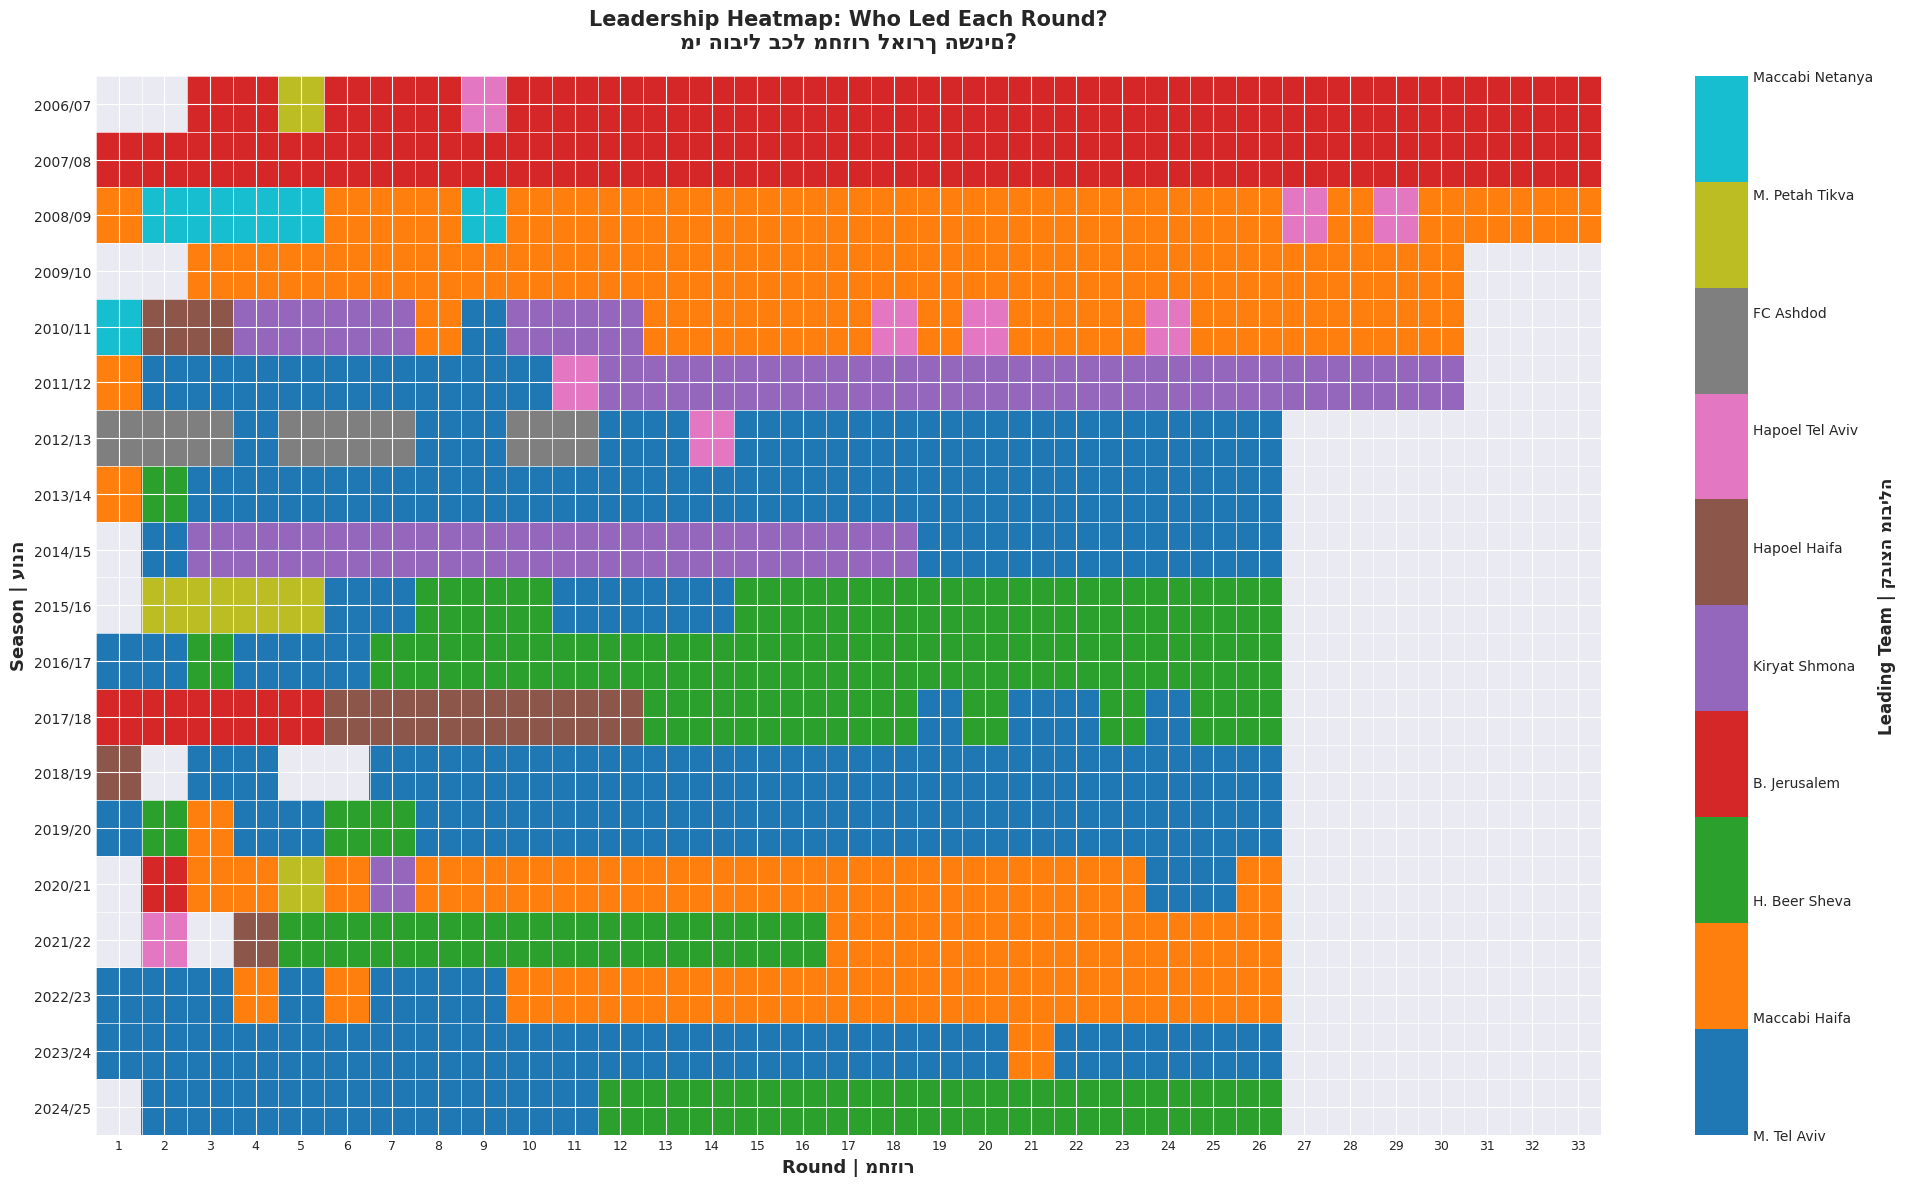


✅ Top 10 teams by rounds led:
    1. M. Tel Aviv                   : 163 rounds
    2. Maccabi Haifa                 : 123 rounds
    3. H. Beer Sheva                 :  77 rounds
    4. B. Jerusalem                  :  68 rounds
    5. Kiryat Shmona                 :  43 rounds
    6. Hapoel Haifa                  :  11 rounds
    7. Hapoel Tel Aviv               :   9 rounds
    8. FC Ashdod                     :   8 rounds
    9. M. Petah Tikva                :   6 rounds
   10. Maccabi Netanya               :   6 rounds


In [103]:
# Create heatmap showing which team led in each round across seasons
print("=" * 80)
print("🔥 LEADERSHIP HEATMAP")
print("=" * 80)

# Prepare data: for each season-round, who was the leader
heatmap_data = []
for season in per_round_df['season'].unique():
    season_data = per_round_df[per_round_df['season'] == season].sort_values('round')
    for _, row in season_data.iterrows():
        heatmap_data.append({
            'season': season,
            'round': row['round'],
            'leader': row['leader'],
            'gap': row['gap']
        })

heatmap_df = pd.DataFrame(heatmap_data)

# Get top 10 teams that led most often
top_leaders = heatmap_df['leader'].value_counts().head(10).index.tolist()
heatmap_filtered = heatmap_df[heatmap_df['leader'].isin(top_leaders)]

# Create pivot table: seasons × rounds, filled with team names
pivot_for_heatmap = heatmap_filtered.pivot_table(
    index='season', 
    columns='round', 
    values='leader', 
    aggfunc='first'
)

# Create numeric encoding for teams (for coloring)
team_to_num = {team: i for i, team in enumerate(top_leaders)}
pivot_numeric = pivot_for_heatmap.replace(team_to_num)

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 12))

# Use custom colormap
cmap = plt.cm.get_cmap('tab10', len(top_leaders))
im = ax.imshow(pivot_numeric.values, aspect='auto', cmap=cmap, interpolation='nearest')

# Set ticks
ax.set_xticks(range(len(pivot_numeric.columns)))
ax.set_xticklabels(pivot_numeric.columns, fontsize=9)
ax.set_yticks(range(len(pivot_numeric.index)))
ax.set_yticklabels(pivot_numeric.index, fontsize=10)

# Labels
ax.set_xlabel('Round | מחזור', fontsize=13, fontweight='bold')
ax.set_ylabel('Season | עונה', fontsize=13, fontweight='bold')
ax.set_title('Leadership Heatmap: Who Led Each Round?\nמי הוביל בכל מחזור לאורך השנים?', 
             fontsize=15, fontweight='bold', pad=20)

# Add colorbar with team names
cbar = plt.colorbar(im, ax=ax, ticks=range(len(top_leaders)))
cbar.ax.set_yticklabels(top_leaders, fontsize=10)
cbar.set_label('Leading Team | קבוצה מובילה', fontsize=12, fontweight='bold')

# Add grid
ax.set_xticks([x - 0.5 for x in range(len(pivot_numeric.columns) + 1)], minor=True)
ax.set_yticks([y - 0.5 for y in range(len(pivot_numeric.index) + 1)], minor=True)
ax.grid(which='minor', color='white', linewidth=0.5)

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_heatmap.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

print(f"\n✅ Top 10 teams by rounds led:")
for i, team in enumerate(top_leaders, 1):
    count = heatmap_df[heatmap_df['leader'] == team].shape[0]
    print(f"   {i:2d}. {team:30s}: {count:3d} rounds")

### 11.2 Lead Timeline | ציר זמן של ההובלה

📊 LEAD TIMELINE - SELECTED SEASONS
💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\lead_timeline_multiple_seasons.png


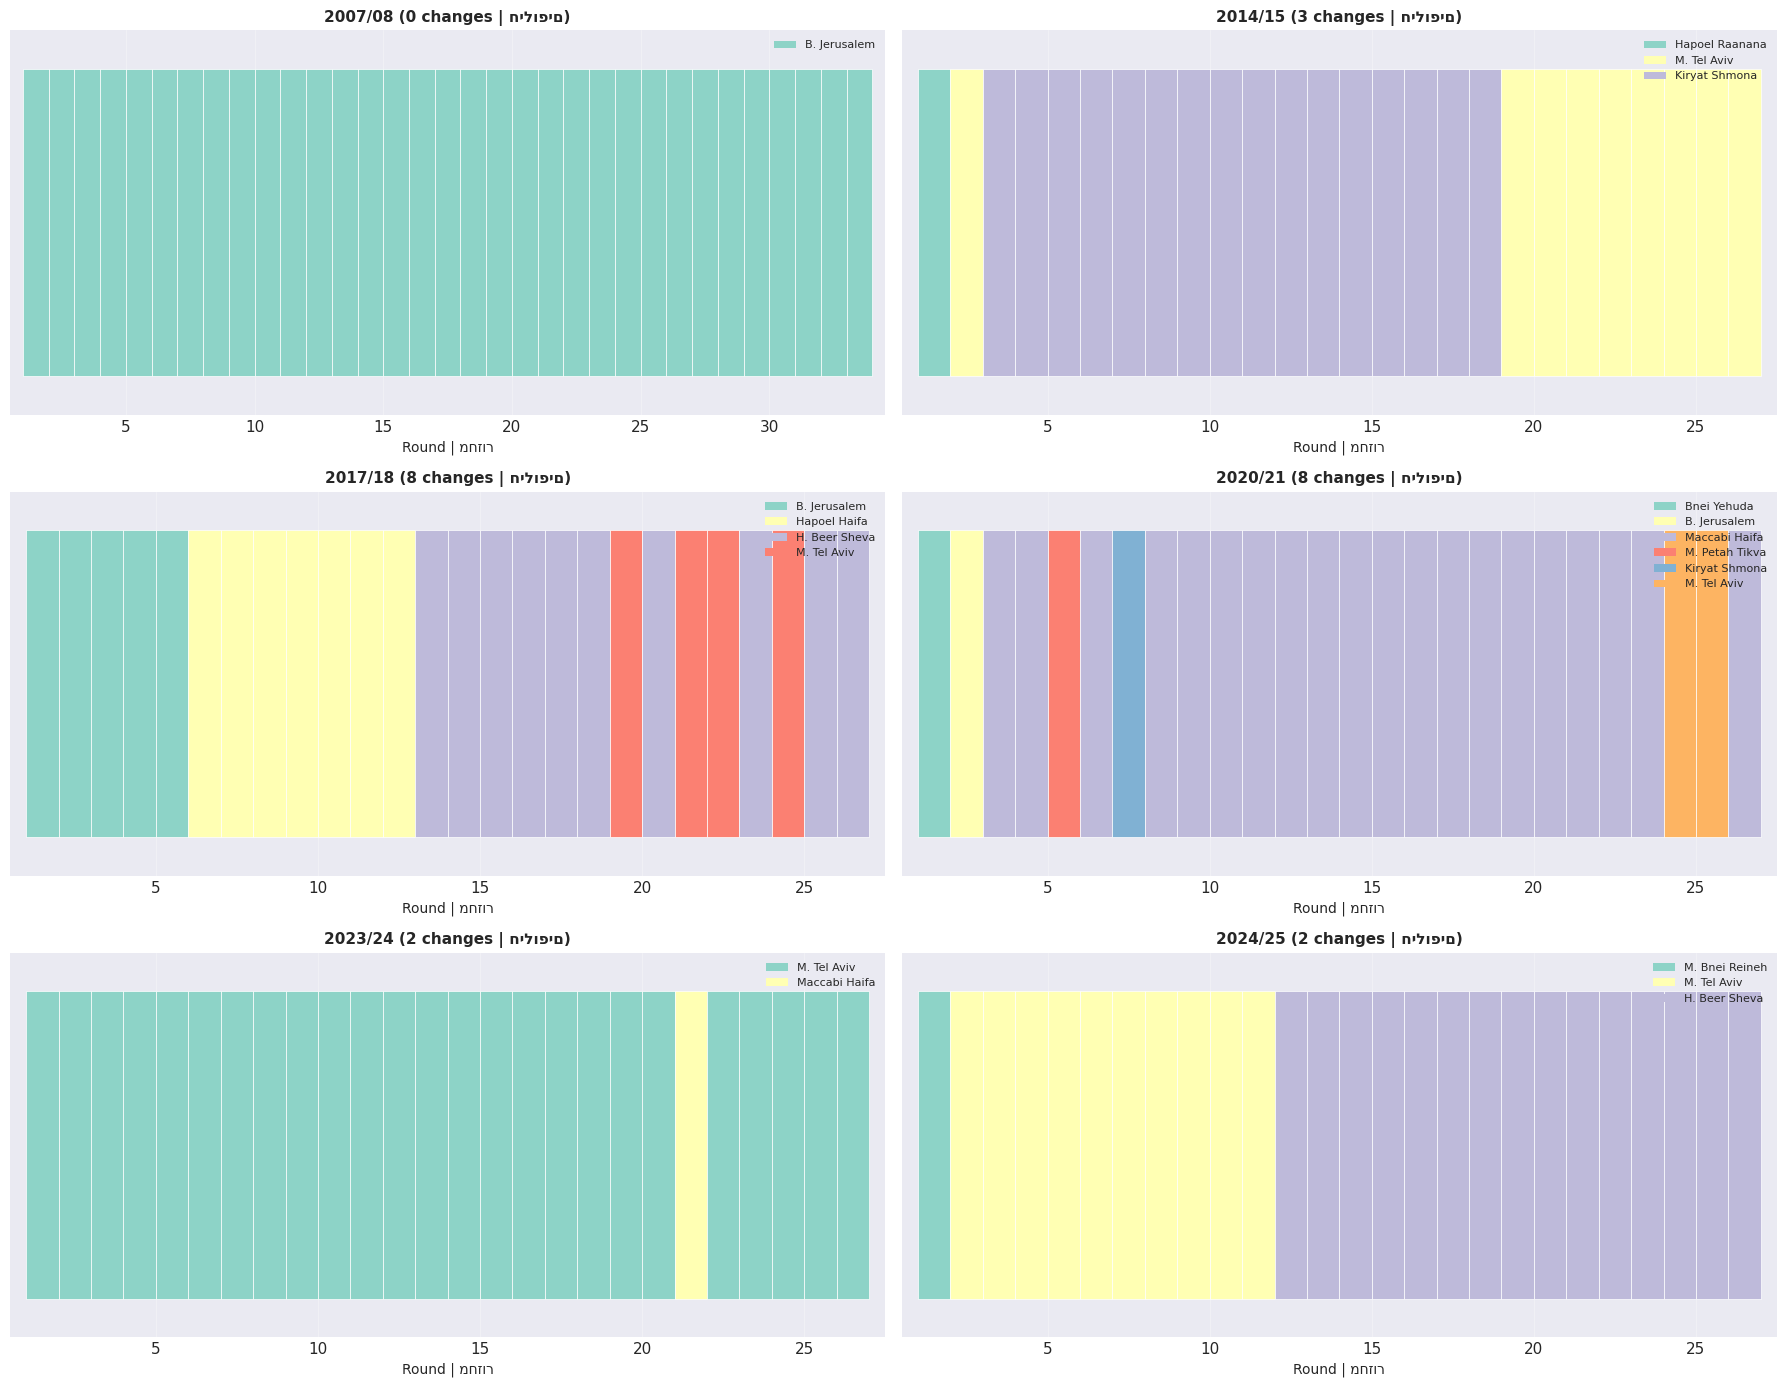


✅ Timeline visualization complete


In [104]:
# Timeline visualization showing leadership changes across multiple seasons
print("=" * 80)
print("📊 LEAD TIMELINE - SELECTED SEASONS")
print("=" * 80)

# Select interesting seasons: most competitive, least competitive, recent
interesting_timeline_seasons = [
    '2007/08',  # Dominant (B. Jerusalem)
    '2014/15',  # Maccabi Tel Aviv era
    '2017/18',  # Most competitive
    '2020/21',  # Recent competitive
    '2023/24',  # Most recent
    '2024/25'   # Current season
]

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, season in enumerate(interesting_timeline_seasons):
    ax = axes[idx]
    season_data = per_round_df[per_round_df['season'] == season].sort_values('round')
    
    if season_data.empty:
        ax.text(0.5, 0.5, f'No data for {season}', ha='center', va='center', fontsize=12)
        ax.set_title(f'{season}', fontsize=12, fontweight='bold')
        continue
    
    # Get all unique leaders in this season
    leaders_in_season = season_data['leader'].unique()
    team_colors = plt.cm.Set3(range(len(leaders_in_season)))
    color_map = {team: team_colors[i] for i, team in enumerate(leaders_in_season)}
    
    # Plot each round as a colored segment
    for i in range(len(season_data) - 1):
        current_round = season_data.iloc[i]
        next_round = season_data.iloc[i + 1]
        leader = current_round['leader']
        
        ax.barh(0, width=1, left=current_round['round'], 
                color=color_map[leader], edgecolor='white', linewidth=0.5)
    
    # Last round
    last_round = season_data.iloc[-1]
    ax.barh(0, width=1, left=last_round['round'], 
            color=color_map[last_round['leader']], edgecolor='white', linewidth=0.5)
    
    # Formatting
    ax.set_xlim(season_data['round'].min() - 0.5, season_data['round'].max() + 1.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Round | מחזור', fontsize=10)
    
    # Title with leadership changes count
    changes = summary_df[summary_df['season'] == season]['leadership_changes'].values[0]
    ax.set_title(f'{season} ({changes} changes | חילופים)', fontsize=11, fontweight='bold')
    
    # Legend
    legend_elements = [plt.Rectangle((0,0),1,1, fc=color_map[team], label=team) 
                       for team in leaders_in_season]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, framealpha=0.9)
    
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'lead_timeline_multiple_seasons.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

print("\n✅ Timeline visualization complete")

### 11.3 Gap Boxplots by Season | פערים לפי עונה

📦 GAP DISTRIBUTION BY SEASON


C:\Users\nitib\AppData\Local\Temp\ipykernel_30612\2145799762.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(gap_data, labels=seasons_sorted, patch_artist=True, showmeans=True,


💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\gap_boxplots_by_season.png


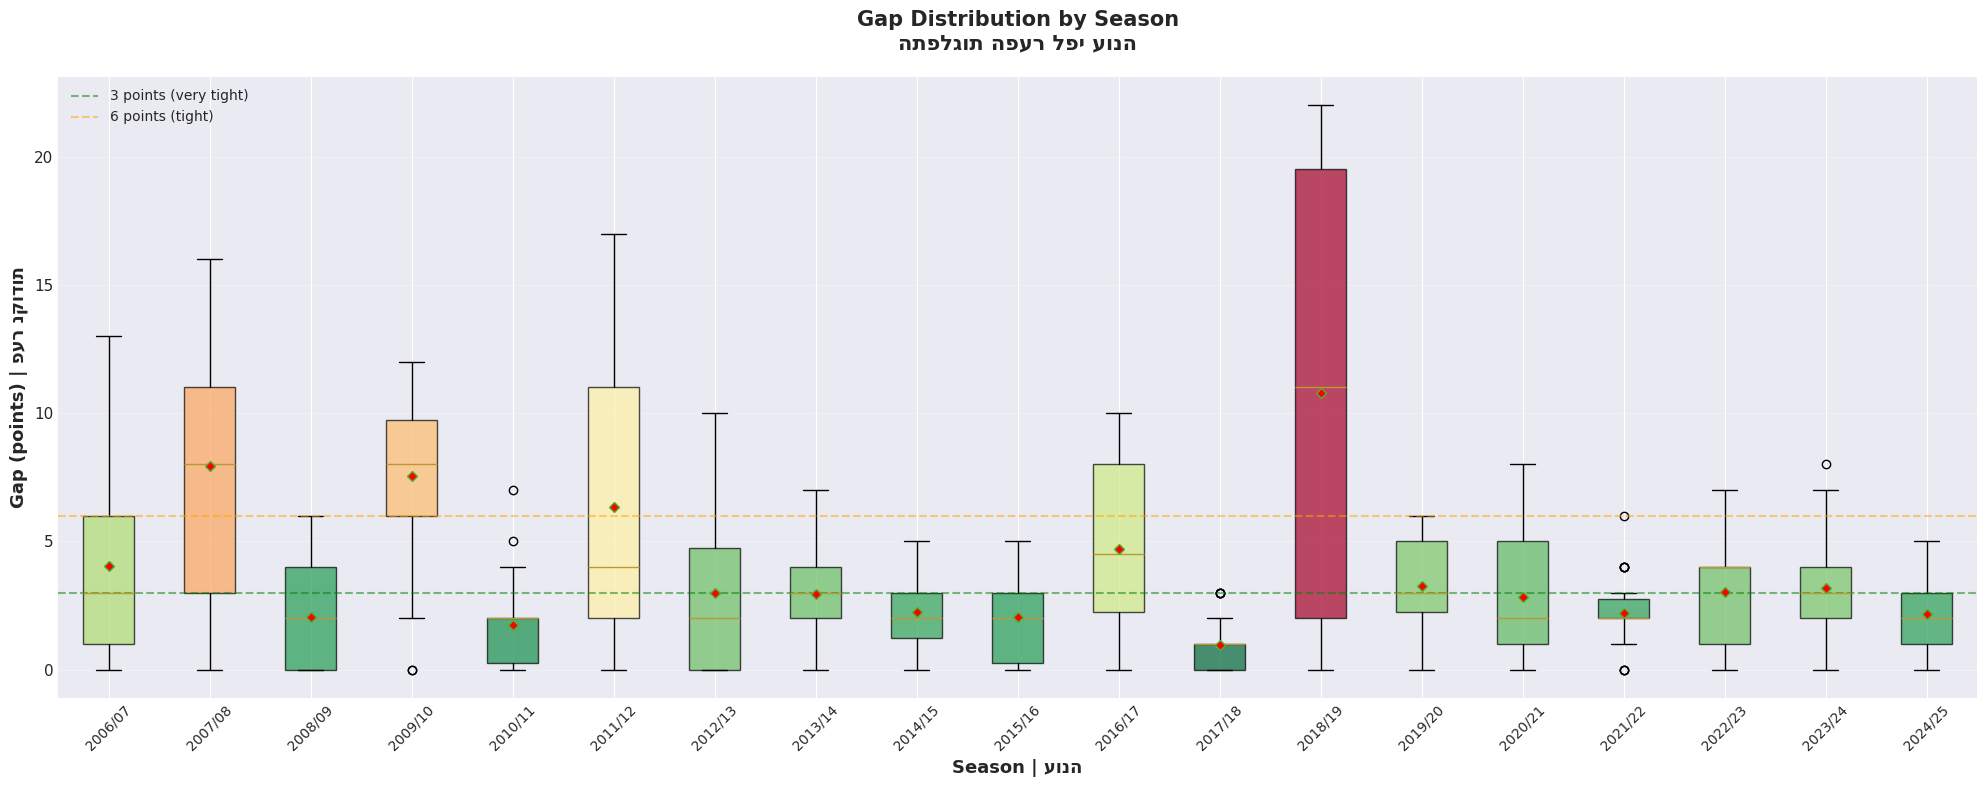


📊 Gap Statistics Summary:
   Overall median gap: 2.00 points
   Overall mean gap: 3.91 points
   Most competitive season (lowest median): 2017/18
   Least competitive season (highest median): 2018/19

✅ Gap boxplot visualization complete


In [105]:
# Boxplot showing distribution of gaps for each season
print("=" * 80)
print("📦 GAP DISTRIBUTION BY SEASON")
print("=" * 80)

# Prepare data for boxplot
seasons_sorted = sorted(per_round_df['season'].unique())
gap_data = [per_round_df[per_round_df['season'] == s]['gap'].values for s in seasons_sorted]

fig, ax = plt.subplots(figsize=(20, 8))

# Create boxplot
bp = ax.boxplot(gap_data, labels=seasons_sorted, patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=5))

# Color boxes by competitiveness (based on avg gap)
avg_gaps = [summary_df[summary_df['season'] == s]['avg_gap'].values[0] for s in seasons_sorted]
colors_gap = plt.cm.RdYlGn_r([(g - min(avg_gaps)) / (max(avg_gaps) - min(avg_gaps)) for g in avg_gaps])

for patch, color in zip(bp['boxes'], colors_gap):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Formatting
ax.set_xlabel('Season | עונה', fontsize=13, fontweight='bold')
ax.set_ylabel('Gap (points) | פער נקודות', fontsize=13, fontweight='bold')
ax.set_title('Gap Distribution by Season\nהתפלגות הפער לפי עונה', fontsize=15, fontweight='bold', pad=20)
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.grid(axis='y', alpha=0.3)

# Add horizontal reference lines
ax.axhline(3, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='3 points (very tight)')
ax.axhline(6, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='6 points (tight)')
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
fig_path = FIG_DIR / 'gap_boxplots_by_season.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Print statistics
print("\n📊 Gap Statistics Summary:")
print(f"   Overall median gap: {per_round_df['gap'].median():.2f} points")
print(f"   Overall mean gap: {per_round_df['gap'].mean():.2f} points")
print(f"   Most competitive season (lowest median): {seasons_sorted[np.argmin([np.median(g) for g in gap_data])]}")
print(f"   Least competitive season (highest median): {seasons_sorted[np.argmax([np.median(g) for g in gap_data])]}")
print("\n✅ Gap boxplot visualization complete")

### 11.4 Leadership Changes Bar Chart | חילופי הובלה

🔄 LEADERSHIP CHANGES ANALYSIS
💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_changes_comprehensive.png


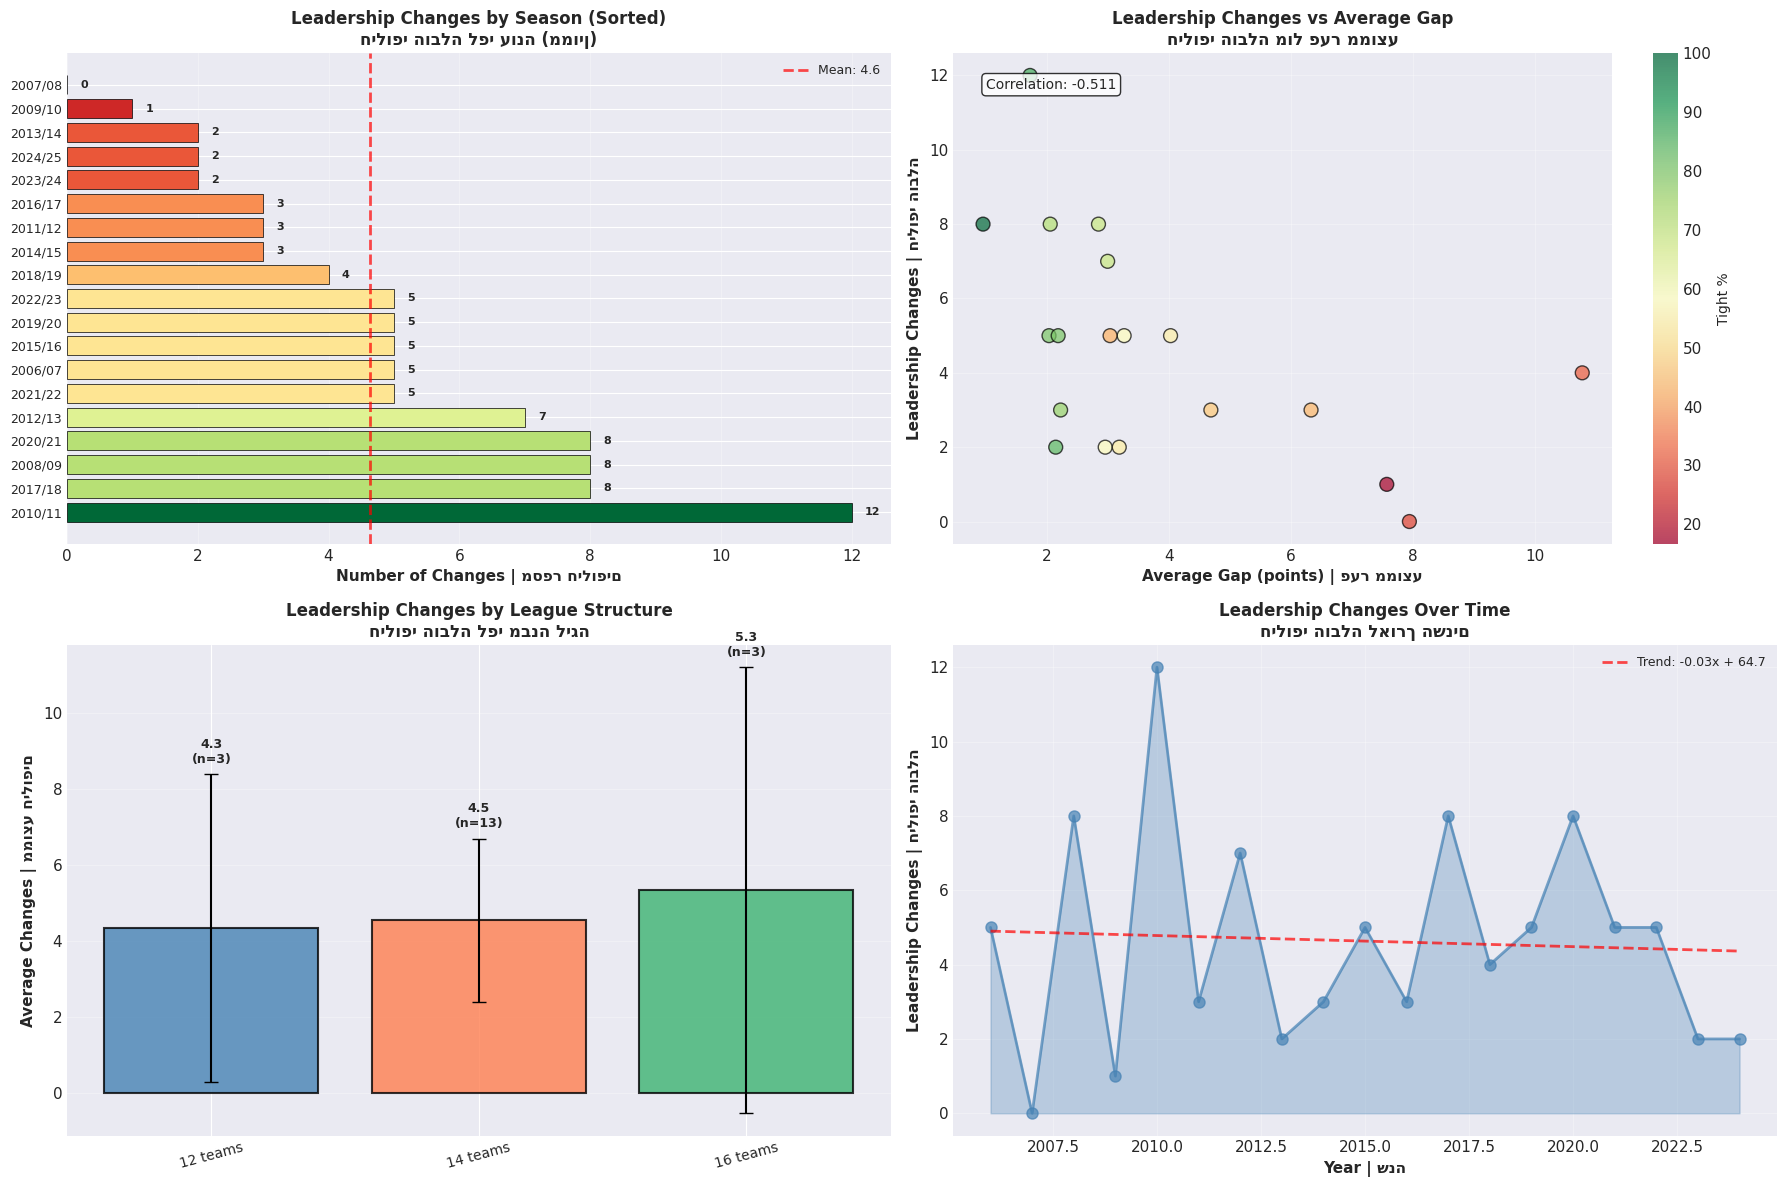


✅ Leadership changes analysis complete
   Mean changes per season: 4.63
   Median changes per season: 5.0
   Most dynamic season: 2010/11 (12 changes)
   Least dynamic season: 2007/08 (0 changes)


In [106]:
# Enhanced bar chart of leadership changes with multiple insights
print("=" * 80)
print("🔄 LEADERSHIP CHANGES ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Leadership changes by season (sorted)
ax1 = axes[0, 0]
changes_sorted = summary_df.sort_values('leadership_changes', ascending=False)
colors_changes = plt.cm.RdYlGn(
    (changes_sorted['leadership_changes'] - changes_sorted['leadership_changes'].min()) / 
    (changes_sorted['leadership_changes'].max() - changes_sorted['leadership_changes'].min())
)
bars1 = ax1.barh(range(len(changes_sorted)), changes_sorted['leadership_changes'], 
                 color=colors_changes, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(changes_sorted)))
ax1.set_yticklabels(changes_sorted['season'], fontsize=9)
ax1.set_xlabel('Number of Changes | מספר חילופים', fontsize=11, fontweight='bold')
ax1.set_title('Leadership Changes by Season (Sorted)\nחילופי הובלה לפי עונה (ממוין)', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(changes_sorted['leadership_changes'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f'Mean: {changes_sorted["leadership_changes"].mean():.1f}')
ax1.legend(fontsize=9)

# Add values on bars
for i, (bar, val) in enumerate(zip(bars1, changes_sorted['leadership_changes'])):
    ax1.text(val + 0.2, i, f'{val:.0f}', va='center', fontsize=8, fontweight='bold')

# 2. Changes vs Avg Gap scatter
ax2 = axes[0, 1]
scatter2 = ax2.scatter(summary_df['avg_gap'], summary_df['leadership_changes'], 
                       c=summary_df['tight_pct'], cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax2.set_xlabel('Average Gap (points) | פער ממוצע', fontsize=11, fontweight='bold')
ax2.set_ylabel('Leadership Changes | חילופי הובלה', fontsize=11, fontweight='bold')
ax2.set_title('Leadership Changes vs Average Gap\nחילופי הובלה מול פער ממוצע', 
              fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Tight %', fontsize=10)

# Add correlation
corr_changes_gap = summary_df['leadership_changes'].corr(summary_df['avg_gap'])
ax2.text(0.05, 0.95, f'Correlation: {corr_changes_gap:.3f}', 
         transform=ax2.transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Changes distribution by league structure
ax3 = axes[1, 0]
structure_changes = summary_df.groupby('structure')['leadership_changes'].agg(['mean', 'std', 'count'])
structures = structure_changes.index
x_pos = range(len(structures))
bars3 = ax3.bar(x_pos, structure_changes['mean'], yerr=structure_changes['std'], 
                color=['steelblue', 'coral', 'mediumseagreen'], 
                edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([s.split('(')[0].strip() for s in structures], fontsize=10, rotation=15)
ax3.set_ylabel('Average Changes | ממוצע חילופים', fontsize=11, fontweight='bold')
ax3.set_title('Leadership Changes by League Structure\nחילופי הובלה לפי מבנה ליגה', 
              fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add values and sample size
for i, (bar, mean, count) in enumerate(zip(bars3, structure_changes['mean'], structure_changes['count'])):
    ax3.text(i, mean + structure_changes.iloc[i]['std'] + 0.3, 
             f'{mean:.1f}\n(n={count})', ha='center', fontsize=9, fontweight='bold')

# 4. Changes over years (trend)
ax4 = axes[1, 1]
summary_df['year'] = summary_df['season'].str[:4].astype(int)
yearly_changes = summary_df.sort_values('year')
ax4.plot(yearly_changes['year'], yearly_changes['leadership_changes'], 
         marker='o', linewidth=2, markersize=8, color='steelblue', alpha=0.7)
ax4.fill_between(yearly_changes['year'], 0, yearly_changes['leadership_changes'], 
                 alpha=0.3, color='steelblue')
ax4.set_xlabel('Year | שנה', fontsize=11, fontweight='bold')
ax4.set_ylabel('Leadership Changes | חילופי הובלה', fontsize=11, fontweight='bold')
ax4.set_title('Leadership Changes Over Time\nחילופי הובלה לאורך השנים', 
              fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Add trend line
z = np.polyfit(yearly_changes['year'], yearly_changes['leadership_changes'], 1)
p = np.poly1d(z)
ax4.plot(yearly_changes['year'], p(yearly_changes['year']), 
         "r--", linewidth=2, alpha=0.7, label=f'Trend: {z[0]:.2f}x + {z[1]:.1f}')
ax4.legend(fontsize=9)

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_changes_comprehensive.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

print("\n✅ Leadership changes analysis complete")
print(f"   Mean changes per season: {summary_df['leadership_changes'].mean():.2f}")
print(f"   Median changes per season: {summary_df['leadership_changes'].median():.1f}")
print(f"   Most dynamic season: {changes_sorted.iloc[0]['season']} ({changes_sorted.iloc[0]['leadership_changes']:.0f} changes)")
print(f"   Least dynamic season: {changes_sorted.iloc[-1]['season']} ({changes_sorted.iloc[-1]['leadership_changes']:.0f} changes)")